***
# Clustering
MSDS 7331-407, Lab 3 
*Jenna Ford, Edward Fry, Christian Nava, and Jonathan Tan* 
***

## Table of Contents

<a href='#Section_1'> 1. Business Understanding 1 </a>  
<a href='#Section_2'> 2. Preparation and Dataset Loading </a>  
<a href='#Section_3'> 3. Data Understanding 1</a>  
<a href='#Section_4'> 4. Data Understanding 2 </a>  
<a href='#Section_5'> 5. Modeling and Evaluation 1 </a>  
<a href='#Section_6'> 6. Modeling and Evaluation 2 </a>  
<a href='#Section_7'> 7. Modeling and Evaluation 3 </a>  
<a href='#Section_8'> 8. Modeling and Evaluation 4 </a>  
<a href='#Section_9'> 9. Deployment </a>  
<a href='#Section_10'> 10. Exceptional Work </a>  

<a id = 'Section_1'></a>

## 1. Business Understanding

*(10 points)*

*Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?*

Dataset: [Diabetes 130-US hospitals 1999-2008](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008)

This dataset was filtered from 130 US hospitals and associated institutions from 1999 to 2008. It contains data on attributes of patients who were admitted to the hospital for at least 1 day where diabetes was any part of the diagnosis. It excludes patients who stayed for more than 14 days and patients who did not receive medication or laboratory tests of any kind. The primary attribute recorded is how long before that same patient was readmitted to a medical institution in this particular network, classified as readmitted within 30 days (yes), readmitted after 30 days (>30), or not yet (no). 

This dataset was likely collected in the interests of improving a medical entity's ability to estimate the readmission rates of diabetic patients. Due to the chronic nature of diabetes, patients who require some form of medical treatment are likely to continue to require treatment. Classifying the readmission status of diabetic patients based on other attributes is an integral part of predicting future hospital traffic, which has implications on the logistics of the healthcare network holistically. Being able to estimate the readmission status of diabetic patients would allow hospital administration to create long term plans for allocating funds, staff, equipment and space for diabetic patients. Ratios of readmission could be used to create performance metrics applicable to different hospitals or hospital networks, reflecting the ability of an institution to effectively treat diabetic patients (if regional demographic differences were appropriately accounted for). Financial entities could justify approval or retraction of various forms of funding depending on a hospital's projected readmission time for patients. Insurance companies would be able to maximize profits by adjusting coverage and/or premiums for patients classified for readmission. 

Our chosen metric for evaluating clustering models on patient readmission is Area Under the Curve - Receiver Operating Characteristics (AUC-ROC). The goal of a clustering algorithm in this context is to separate patients into clusters with the hope of improving AUC when classifying a patient into 1 of 3 groups; readmission >30, <30, or NO. A high AUC score will mean that the algorithm is successful at distinguishing between these types of patients. Due to the presence of categorical data, more traditional metrics like accuracy or distance measures are not as meaningful. 

There are a lot of different clusters that could be evaluated. We have chosen a small sample that we think could be interesting or could help improve AUC:

* Admission Source and Discharge Disposition
* Admission Source and Race
* Admission Source, Discharge Disposition and Admission Type
* Admission Source and Payer Code
* Admission Type and Payer Code
* Admission Source, Payer Code and Admission Type
* Discharge Disposition and Race
* Payer Code and Number of Procedures
* Discharge Disposition and Time in Hospital
* Discharge Disposition and Number of Diagnoses
* Payer Code and Number of Medications
* Payer Code and Diabetes Medication
* Race, Payer Code and Diabetes Medication
* Medication Change and Diabetes Medication
* Time in Hospital and Number of Diagnoses
* Number of Lab Procedures and Number of Procedures
* Number of Outpatient, Emergency and Inpatient Visits

The clusters we have chosen mainly center around relationships with admission, discharge and payer code (insurance). While all columns could yield interesting information, these are the columns we are most interested in. For example, how does the health insurance you have, combined with another variable(s) impact your change of being readmitted if you have diabetes?

Ideally, we would like a high AUC score and be able to accurately identify whether an individual will be readmitted to the hospital, and if so for how long. Chance would be 33.33% (since there are 3 classes). We need a model that is significantly better than chance. We will target an AUC of 75%, with hopes to achieve a higher AUC score.

<a id = 'Section_2'></a>

## 2. Preparation and Dataset Loading

In [2]:
import time
startTime = time.time()
import numpy as np
import pandas as pd
import sklearn
from pandas import DataFrame
import seaborn as sn
import seaborn as sns
import pylab as plt
import plotly.graph_objs as go
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
#import dtale #datavis thing

# Creating training and test sets
import sklearn

# File system management
import os.path

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Models and Metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from kmodes.kmodes import KModes
from sklearn import datasets
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import AgglomerativeClustering
import itertools #gaussian mixture clustering
from sklearn import mixture
#import mca #correspondence analysis

In [1]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [4]:
DATA_SOURCE="./diabetic_data.csv"

df_raw = pd.read_csv(DATA_SOURCE)

df = df_raw
print("The dataset has {:,} rows and {:,} columns".format(*df.shape))

The dataset has 101,766 rows and 50 columns


<a id = 'Section_3'></a>

## 3. Data Understanding 1

(10 points) 

*Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?*

The table below gives a description of the feature and identifies its type.

| Feature Name | Type | Description and Values |
|:---|:---|:---|
| encounter_id | Numeric | Unique identifier of an encounter |
| patient_nbr | Numeric | Unique identifier of a patient |
| race | Nominal | Values: Caucasian, Asian, African American, Hispanic, and other |
| gender | Nominal | Values: male, female, and unknown/invalid |
| age | Nominal | Grouped in 10-year intervals: 0-10, 10-20, ..., 90-100 |
| weight | Numeric | Weight in pounds |
| admission_type_id | Nominal | Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available |
| discharge_disposition_id | Nominal | Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available |
| admission_source_id | Nominal | Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital |
| time_in_hospital | Numeric | Integer number of days between admission and discharge |
| payer_code | Nominal | Integer identifier corresponding to 23 distinct values, for example, Blue Cross\Blue Shield, Medicare, and self-pay |
|medical_specialty | Nominal | Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family\general practice, and surgeon |
| num_lab_procedures | Numeric | Number of lab tests performed during the encounter |
| num_procedures | Numeric | Number of procedures (other than lab tests) performed during the encounter |
| num_medications | Numeric | Number of distinct generic names administered during the encounter |
| number_outpatient | Numeric | Number of outpatient visits of the patient in the year preceding the encounter |
| number_emergency | Numeric | Number of emergency visits of the patient in the year preceding the encounter |
| number_inpatient | Numeric | Number of inpatient visits of the patient in the year preceding the encounter |
| diag_1 | Nominal | The primary diagnosis (coded as first three digits of ICD9); 848 distinct values |
| diag_2 | Nominal | Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values |
| diag_3 | Nominal | Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values |
| number_diagnoses | Numeric | Number of diagnoses entered to the system |
| max_glu_serum | Nominal | Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured |
| A1Cresult | Nominal | Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured |
| change | Nominal | Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change” |
| diabetesMed | Nominal | Indicates if there was any diabetic medication prescribed. Values: “yes” and “no” |
| 24 features for medications | Nominal | For the generic names: metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone, the feature indicates whether the drug was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed |
| readmitted | Nominal | Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission. |

Source: [Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records](
https://doi.org/10.1155/2014/781670).

The table below indicates what the values of Admission Type ID stand for.

|Admission Type ID| Description | 
|:---|:---|
|1| Emergency | 
|2| Urgent | 
|3| Elective |
|4| Newborn |
|5| Not Available | 
|6| NULL |
|7| Trauma Center |
|8| Not Mapped | 

The table below indicates what the values of Discharge Disposition stand for.

|Discharge Disposition|Description|
|:---|:---|
|1| discharged to home|
|2| discharged/transferred to short term hospital|
|3| discharged/transferred to SNF (skilled nursing facility)|
|4| discharged/transferred to ICF (intermediate care facility)|
|5| discharged/transferred to another type of inpatient care institution|
|6| discharged/transferred to home with home health service|
|7| left AMA (against medical advice)|
|8| discharged/transferred to home under care of Home IV provider (intravenous care/therapy)|
|9| admitted as inpatient to receiving hospital |
|10| neonate discharged to another hospital for neonatal aftercare|
|12| expired|
|13| still patient/expected to return for outpatient services|
|14| hospice/home|
|15| hospice/medical facility|
|16| discharged/transferred within institution to medicare approved swing bed|
|17| discharged/transferred/referred another institution for outpatient services|
|18| NULL |
|19| expired at home, medicaid only, hospice|
|20|  expired in a medical facility, medicate only, hospice|
|21| expired, place unknown, medicaid only, hospice|
|22| discharged/transferred to another rehab facility including rehab units of a hospital|
|23| discharged/transferred to a long term care facility |
|24| discharged/transferred to a nursing facility certified under medicaid but not medicare |
|25| not mapped |
|26| discharged/transferred to an undefined health care facility|
|27| discharged/transferred to a federal health care facility|
|28| discharged/transferred/referred to a psychiatric hospital or psychiatric unit of hospital |
|29| discharged/transferred to CAH (critical access hospital) |

The table below indicates what the values of Admission Source ID stand for.

| Admission Source ID | Description |
|:---|:---|
|1| physician referral |
|2| clinic referral|
|3| HMO referral|
|4| transfer from a hospital|
|5| transfer from SNF (skilled nursing facility) |
|6| transfer from another health care facility |
|7| ER |
|8| court/law enforcement |
|9| not available |
|10| transfer from CAH (critical access hospital) |
|11| normal delivery |
|12| premature delivery |
|13| sick baby |
|14| extramural birth |
|15| not available |
|16| NULL transfer | 
|17| from another home health agency |
|18| readmission to same home health agency |
|19|  not mapped |
|20| unknown/invalid |
|21| transfer from hostpital inpatient/same facility resulting in separate claim |
|22| born inside this hospital |
|23| born outside this hospital |
|24| transfer from ambulatory surgery center|
|25| transfer from hospice |

### Duplicated Data

When we check for duplicate rows, we see there are no duplicate rows.

In [5]:
df.duplicated().sum()

0

However, we do notice there are duplicate entries for `patient_nbr`, which suggests the data are collected on the same patient(s) for multiple visits.

In [6]:
#HOW MANY PATIENTS APPEAR IN THE DATASET MORE THAN ONCE?
df['patient_nbr'].duplicated().sum()

30248

### Drop Columns that will not be Used

We also drop features that are redundant or not relevant.

In [7]:
#drop columns that aren't relevant or we aren't going to use
#we can use number_diagnoses in place of diag_1, diag_2, diag_3
df.drop(['encounter_id','patient_nbr','diag_1','diag_2','diag_3'], axis=1, inplace=True)

#drop the medication columns to shrink the dataset
df.drop(['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone'], axis=1, inplace=True)

### Missing Data

There were multiple records where the feature values were unknown and recorded as a question mark or 'None'. We replaced these values with NaN to facilitate in counting the missing values.

In [8]:
df = df.replace('?', np.nan)
df = df.replace('None', np.nan)

In [9]:
df.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,...,1,0,0,0,1,NaN,NaN,No,No,NO
1,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,...,18,0,0,0,9,NaN,NaN,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,...,13,2,0,1,6,NaN,NaN,No,Yes,NO
3,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,...,16,0,0,0,7,NaN,NaN,Ch,Yes,NO
4,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,...,8,0,0,0,5,NaN,NaN,Ch,Yes,NO


In [10]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis = 1, keys = ['Missing Values', '% of Total  Values'])

We can see from the missing table below that 96.86% of the values are missing for the weight feature. We will drop this column as well as the columns for max_glu_serum, A1Cresult, and medical_specialty. For payer_code and race, we will drop the rows where the value is missing for the respective feature.

In [11]:
missing_data(df)

,Missing Values,% of Total Values
weight,98569,96.858479
max_glu_serum,96420,94.746772
A1Cresult,84748,83.277322
medical_specialty,49949,49.082208
payer_code,40256,39.557416
race,2273,2.233555
gender,0,0.000000
age,0,0.000000
admission_type_id,0,0.000000
discharge_disposition_id,0,0.000000


In [12]:
df.drop(['weight','medical_specialty','max_glu_serum','A1Cresult'], axis=1, inplace=True)

In [13]:
df.dropna(subset=['payer_code','race'], axis=0, inplace=True)

After checking for missing values a second time, we can see we no longer have any missing values.

In [14]:
missing_data(df)

,Missing Values,% of Total Values
readmitted,0,0.0
diabetesMed,0,0.0
gender,0,0.0
age,0,0.0
admission_type_id,0,0.0
discharge_disposition_id,0,0.0
admission_source_id,0,0.0
time_in_hospital,0,0.0
payer_code,0,0.0
num_lab_procedures,0,0.0


### Prepare Dataset for Clustering

We will be using several clustering techniques and some cannot handle categorical variables. We will recode the target variable, `readmitted`, as '0' if there was no record of readmission, '1' if the patient was readmitted in less than 30 days, and '2' if the patient was readmitted in more than 30 days.

In [15]:
#target variable
target = {"readmitted": {"NO": 0, "<30": 1, ">30": 2}}
df.replace(target,inplace=True)

In [16]:
#create a function to count by column and display percentages
def count_percent(data,field):
    df_grouped = data.groupby(by=field)
    c1 = (df_grouped[field].count())

    c2  = []#create empty list to store percentages
    for x in c1:
        c2.append("{:.2%}".format((x/sum(c1)))) #row value divided by total, formatted as percent, store in list
    c1 = pd.DataFrame(c1) #needs dataframe to start with, then can add new column from list c2
    c1['Percent']= c2
    c1.columns = ['Count','Percent']
    return c1

We can see from the output in the cell below that a majority of patients (approximately 80.3%) are between 50 and 90 years old.

In [17]:
count_percent(df,'age')

,Count,Percent
age,,
[0-10),13,0.02%
[10-20),220,0.37%
[20-30),1006,1.68%
[30-40),2045,3.42%
[40-50),5376,8.99%
[50-60),9696,16.22%
[60-70),13219,22.11%
[70-80),15080,25.23%
[80-90),11186,18.71%


Age was reported as a range and we will treat it as a categorical variable for most clustering techniques.

In [18]:
df['age_num'] = df['age'].astype(str).str[1]
df.drop(['age'], axis=1, inplace=True)

Also, we will one-hot encode variables with 2 categories and leave all others as is. We will use this dataset for our K-modes algorithm, which is designed to handle categorical variables.

In [19]:
#onehot encoding for variables with 2 categories
#this dataset to be used with K-MODES
df['IsMale'] = df.gender=='Male' 
df.IsMale = df.IsMale.astype(np.int)
df.drop(['gender'], axis=1, inplace=True)

df['med_change'] = df.change=='Ch'
df.med_change = df.med_change.astype(np.int)
df.drop(['change'], axis=1, inplace=True)

df['med_diabetes'] = df.diabetesMed=='Yes'
df.med_diabetes = df.med_diabetes.astype(np.int)
df.drop(['diabetesMed'], axis=1, inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59781 entries, 20446 to 101764
Data columns (total 18 columns):
race                        59781 non-null object
admission_type_id           59781 non-null int64
discharge_disposition_id    59781 non-null int64
admission_source_id         59781 non-null int64
time_in_hospital            59781 non-null int64
payer_code                  59781 non-null object
num_lab_procedures          59781 non-null int64
num_procedures              59781 non-null int64
num_medications             59781 non-null int64
number_outpatient           59781 non-null int64
number_emergency            59781 non-null int64
number_inpatient            59781 non-null int64
number_diagnoses            59781 non-null int64
readmitted                  59781 non-null int64
age_num                     59781 non-null object
IsMale                      59781 non-null int32
med_change                  59781 non-null int32
med_diabetes                59781 non-null int32
d

In [21]:
df.head()

,race,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,age_num,IsMale,med_change,med_diabetes
20446,Caucasian,1,22,7,7,MC,58,2,15,0,0,0,9,0,7,0,1,1
20737,Caucasian,2,1,1,3,MC,59,3,11,0,0,0,6,0,6,0,0,1
20824,Caucasian,1,1,7,4,MC,56,1,9,0,0,0,6,0,9,0,0,1
21083,Caucasian,1,2,7,10,MC,68,1,18,0,0,0,6,0,7,1,1,1
23668,Caucasian,2,1,1,4,MC,33,0,11,0,0,0,4,1,6,0,1,1


In [22]:
#create new dataset to be used with distance based clustering algorithms
df_imputed = df

Distance-based clustering algorithms such as K-means and DBSCAN use a distance measurement to calculate similarity. For distance-based clustering algorithms we will one-hot encode all variables.

In [23]:
#onehot encoding for variables with more than 2 categories
tmp_df = pd.get_dummies(df_imputed.race,prefix='race')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['race'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.payer_code,prefix='payer')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['payer_code'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.admission_type_id,prefix='admission_type')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['admission_type_id'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.discharge_disposition_id,prefix='discharge')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['discharge_disposition_id'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.admission_source_id,prefix='admission_source')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['admission_source_id'], axis=1, inplace=True)

In [24]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59781 entries, 20446 to 101764
Data columns (total 81 columns):
time_in_hospital        59781 non-null int64
num_lab_procedures      59781 non-null int64
num_procedures          59781 non-null int64
num_medications         59781 non-null int64
number_outpatient       59781 non-null int64
number_emergency        59781 non-null int64
number_inpatient        59781 non-null int64
number_diagnoses        59781 non-null int64
readmitted              59781 non-null int64
age_num                 59781 non-null object
IsMale                  59781 non-null int32
med_change              59781 non-null int32
med_diabetes            59781 non-null int32
race_AfricanAmerican    59781 non-null uint8
race_Asian              59781 non-null uint8
race_Caucasian          59781 non-null uint8
race_Hispanic           59781 non-null uint8
race_Other              59781 non-null uint8
payer_BC                59781 non-null uint8
payer_CH                59781 

In [25]:
df.head(10)

,race,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,age_num,IsMale,med_change,med_diabetes
20446,Caucasian,1,22,7,7,MC,58,2,15,0,0,0,9,0,7,0,1,1
20737,Caucasian,2,1,1,3,MC,59,3,11,0,0,0,6,0,6,0,0,1
20824,Caucasian,1,1,7,4,MC,56,1,9,0,0,0,6,0,9,0,0,1
21083,Caucasian,1,2,7,10,MC,68,1,18,0,0,0,6,0,7,1,1,1
23668,Caucasian,2,1,1,4,MC,33,0,11,0,0,0,4,1,6,0,1,1
23701,Caucasian,1,6,7,8,MD,71,0,17,0,0,0,8,0,5,0,1,1
23871,Caucasian,1,1,1,1,HM,38,0,2,0,0,0,5,2,4,1,0,1
23879,Caucasian,1,3,6,12,UN,77,5,19,0,0,0,5,0,7,0,0,1
23922,Caucasian,1,3,6,12,MC,60,5,10,0,0,0,5,0,7,1,0,0
23927,AfricanAmerican,1,3,7,7,MC,52,1,7,0,0,0,7,0,8,1,0,1


In [26]:
print("The dataset has {:,} rows and {:,} columns".format(*df.shape))

The dataset has 59,781 rows and 18 columns


<a id = 'Section_4'></a>

## 4. Data Understanding 2

*(10 points)*

*Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.*

In this section, we visualize the dataset in various ways in order to understand it better.

First, we apply a heatmap.  The results are not terribly surprising, indicating consistent correlation between the variables, which makes sense when you think about it, since data would be collected together during patient visits.  Breaking it down, some variables are naturally associated with longer stays.  For this reason, other variables tend to increase along with time in hospital.  The number of medications would likely go up as time passes.  More procedures, both lab and general, would likely be performed.  In a similar vein, emergency room visits might often lead to inpatient admissions.

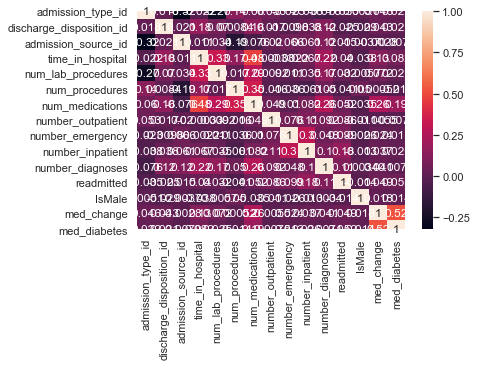

In [115]:
correlation1 = df.corr()
sn.heatmap(correlation1, annot = True)

Next, we plot the variables in a faceted bar chart looking at the amount of time patients spend in the hospital by admission source and admission type.  The bar chart is split into 2 charts for readability. Some insights we found:

* Admission type 1 = Emergency admission has the most datapoints, a wide variety of admission sources, and the largest admission category is "not available" with a hospital stay of 7 days.  This is perhaps indicating a wide variety of miscellaneous sources that don't fall into other categories. Patients with emergency admission from a CAH critical admission hospital) and from a hospice have outliers that are the longest stays.
* Admission type 2 = Urgent's largest category of admissions is from court/law enforcement, but not by much.
* Admission type 3 = Elective type hospital admissions had a larger plurality sourced from courts/law enforcement, followed by SNF transfers (skilled nursing facility).
* Admission type 4 = Newborns; understandably, there are far fewer sources for newborns, only from sources 1, 4, 7, 14; physician, hospital transfer, ER, and extramural birth, respectively. Average stays for this admission type are noticeably lower than other admission types.
* Admission type 5 = Not available.  It is difficult to draw conclusions here since this type is only used for sources 1, 4, 6, 7, 17; physician recommendation, hospital transfer, from another healthcare facility, ER, from another home health agency.
* Admission type 7 = Trauma Center, exclusively transfers from ER, average stay of 5 days.

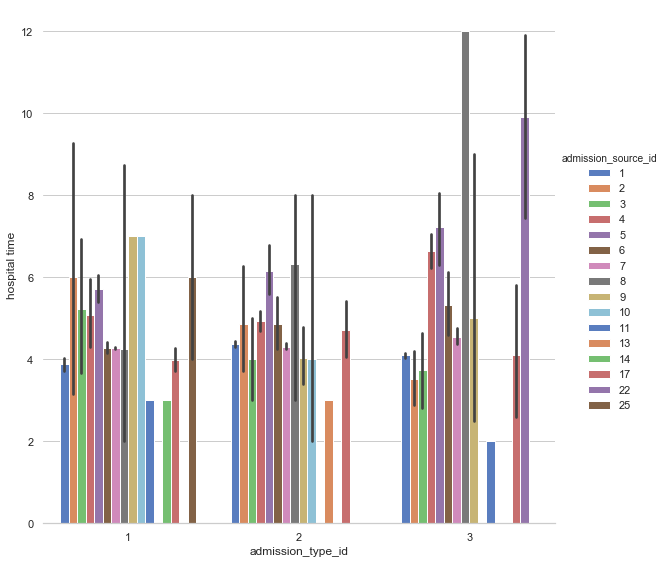

In [66]:
sns.set(style="whitegrid")

bar_df = df.copy()
bar_df1 = bar_df[bar_df['admission_type_id']<=3]
v1 = sns.catplot(x="admission_type_id", y="time_in_hospital", hue="admission_source_id", data=bar_df1,
                height=8, kind="bar", palette="muted", legend_out=True)
v1.despine(left=True)
v1.set_ylabels("hospital time")

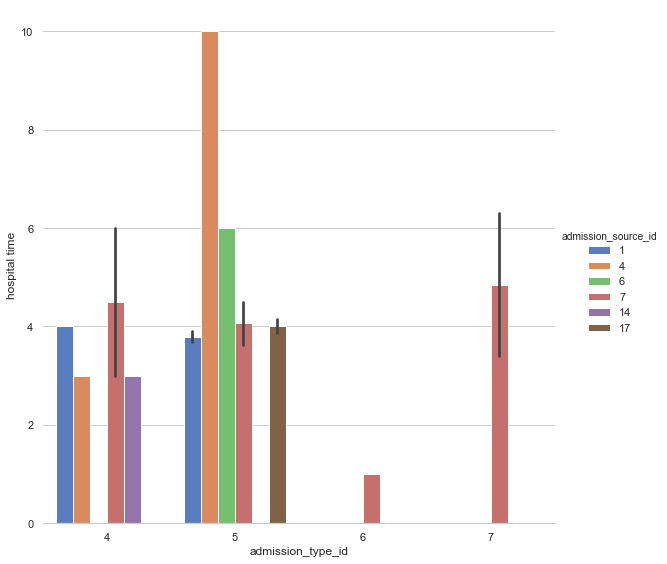

In [109]:
sns.set(style="whitegrid")

bar_df = df.copy()
bar_df1 = bar_df[bar_df['admission_type_id']>3]
v1 = sns.catplot(x="admission_type_id", y="time_in_hospital", hue="admission_source_id", data=bar_df1,
                height=8, kind="bar", palette="muted", legend_out=True)
v1.despine(left=True)
v1.set_ylabels("hospital time")

Next, we plot the variables in a faceted bar chart looking at the amount of time patients spend in the hospital by discharge disposition and admission source.  The bar chart is again split into 2 charts for readability. Some insights we found:

* Admission Source 22 = born in this hospital shows long stays in the hospital before being discharged to another type of inpatient care institution (discharge disposition 5) and before being discharged home with a home health service (discharge disposition 6). This makes sense since these patients would be newborns.
* Discharge Disposition 7 = left against medical advice overall appears to have the smallest amount of time spent in the hospital, which makes sense.
* Discharge disposition 13 = patient is expected to return for outpatient services shows a long hospital stay for clinic referrals (admission source 2). It isn't immediately obvious what might be causing this spike in hospital stay. But it's possible that multiple issues were found but could not all be addressed at the same time.
* Admission Source 5 = transfers from skilled nursing facilities show long hospital stays in multiple discharge dispositions.

<Figure size 1152x504 with 0 Axes>

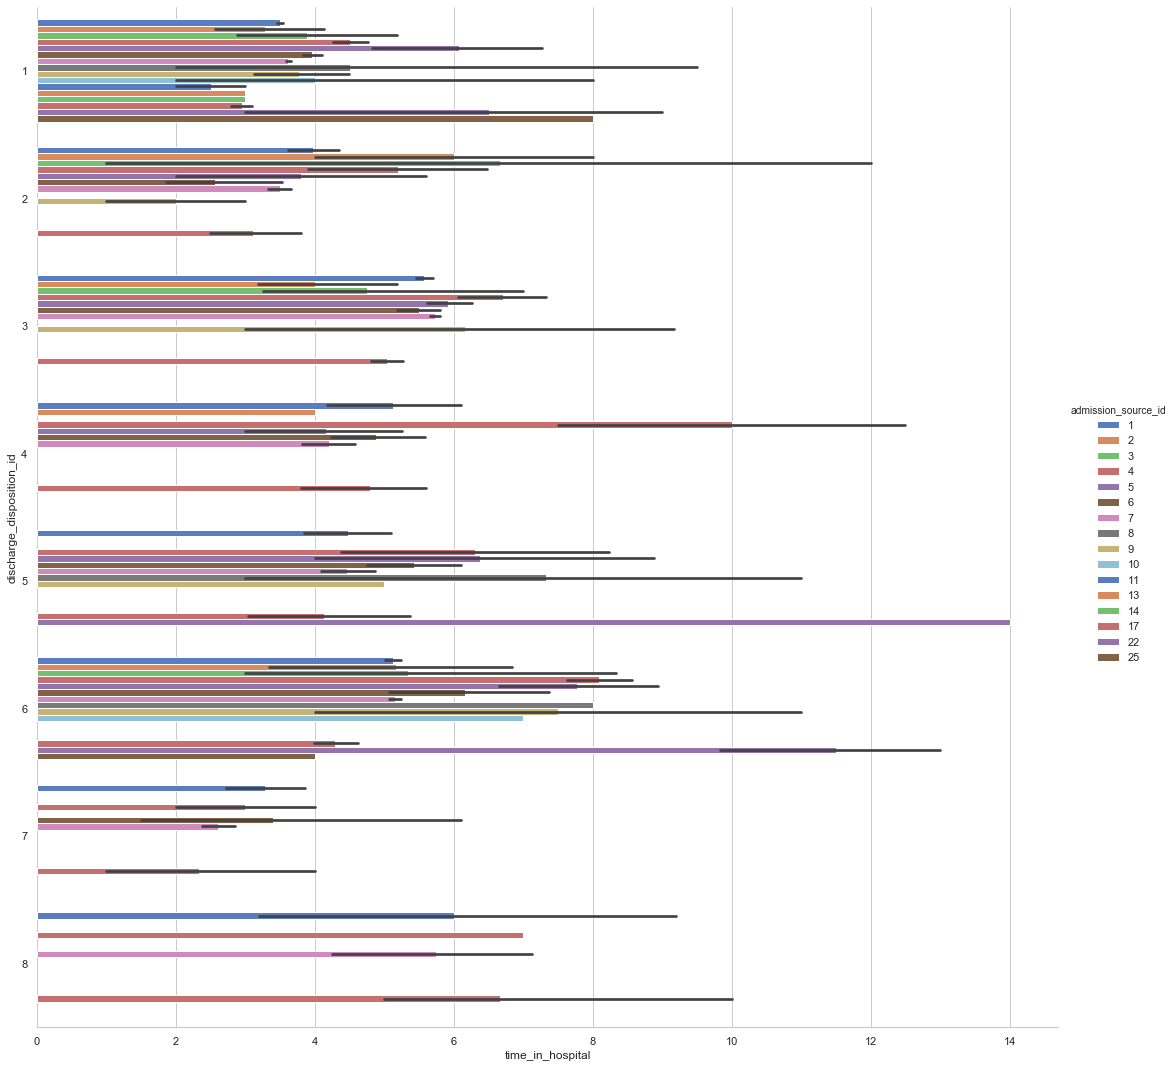

In [110]:
sns.set(style="whitegrid")

bar_df1 = df.copy()
bar_df2 = bar_df1[bar_df1['discharge_disposition_id']<=8]

plt.figure(figsize = (16, 7)) 
v2 = sns.catplot(y="discharge_disposition_id", x="time_in_hospital", hue="admission_source_id", data=bar_df2,
                height=15, kind="bar", palette="muted", orient="h")
v2.despine(left=True)

<Figure size 1152x504 with 0 Axes>

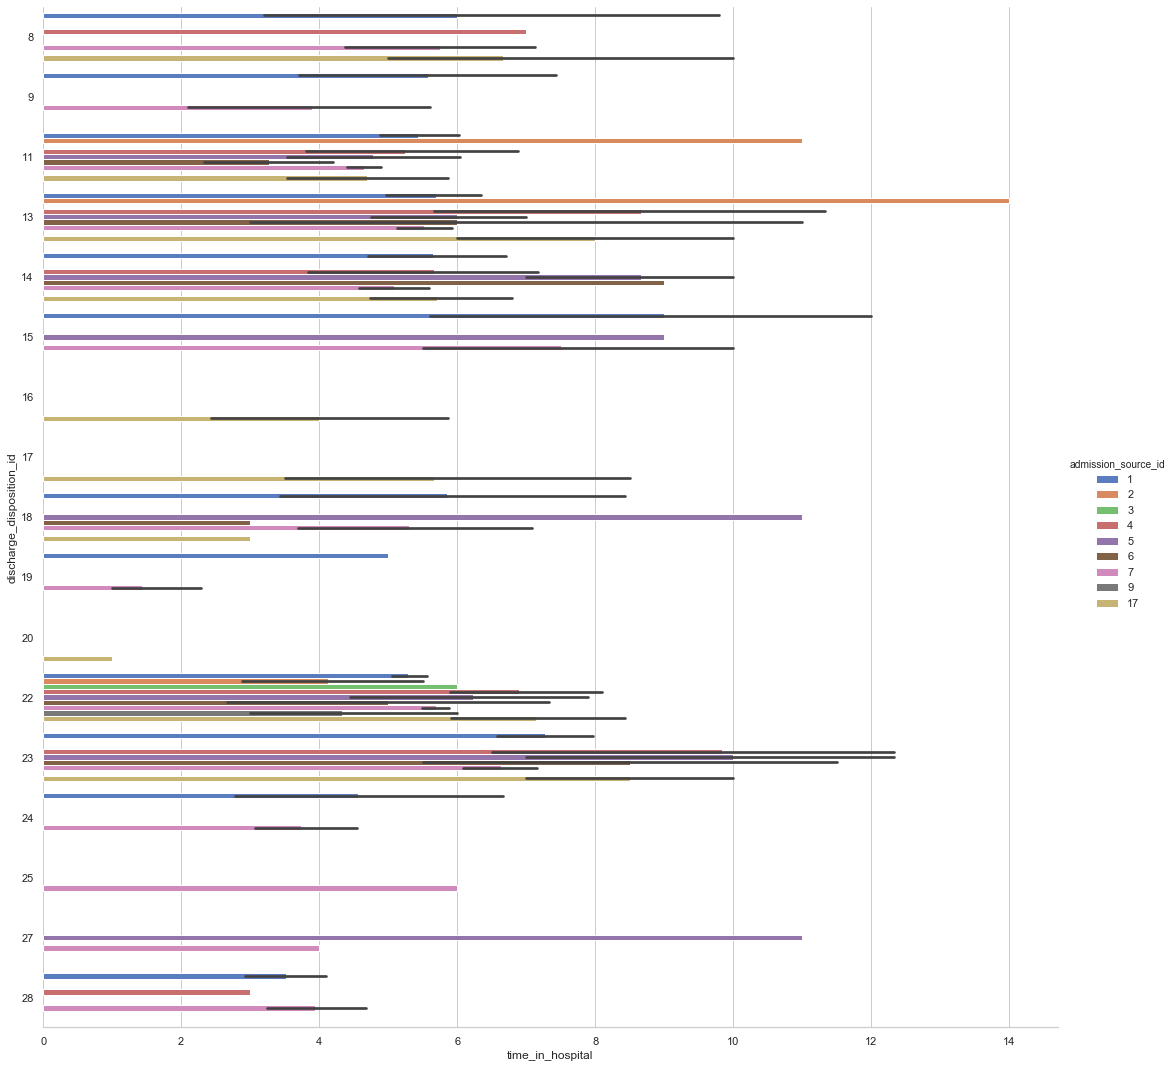

In [111]:
sns.set(style="whitegrid")

bar_df1 = df.copy()
bar_df2 = bar_df1[bar_df1['discharge_disposition_id']>=8]

plt.figure(figsize = (16, 7)) 
v2 = sns.catplot(y="discharge_disposition_id", x="time_in_hospital", hue="admission_source_id", data=bar_df2,
                height=15, kind="bar", palette="muted", orient="h")
v2.despine(left=True)

Next, we examine a violin plot of the data, which conveniently show distributions of each admission type.  The most skew is around 2 and a half days for admission type 4.  Type 7 was also notable because it seemed to have some negative distribution, which we can't explain.  The other admission types were very similarly distributed, and type 1, in particular, showed some turbulence variation in the length of hospital stays.

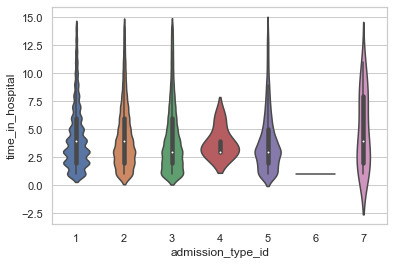

In [118]:
sns.violinplot(x="admission_type_id",y="time_in_hospital",data=df)

We also plotted a violin plot to look at the length of hospital stays for each range of ages by gender.  For very young patients, males seem to be admitted for longer; however, there wasn't much gender variation for the other age groups.

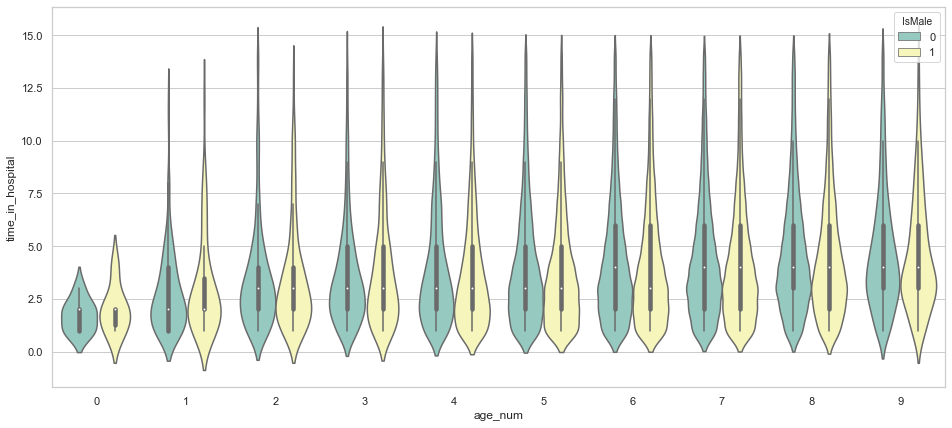

In [119]:
plt.figure(figsize = (16, 7)) 
sns.violinplot(x="age_num",y="time_in_hospital",hue='IsMale',data=df, palette="Set3")

Next, we ran a whisker plot of the number of diagnoses by race.  Predictably, as the number of diagnoses increased, so did the length of time in the hospital.  Hospital stays for Asian patients actually decreased as the number of diagnoses increased, but only up to a point.  After 8 diagnoses, they increased.  For the other races, the length of hospital stays generally increased with the number of diagnoses, although there were a few exceptions, such as Hispanic patients with 9 diagnoses, but we feel like these are just unique characteristics of this particular dataset and not really part of a larger trend.

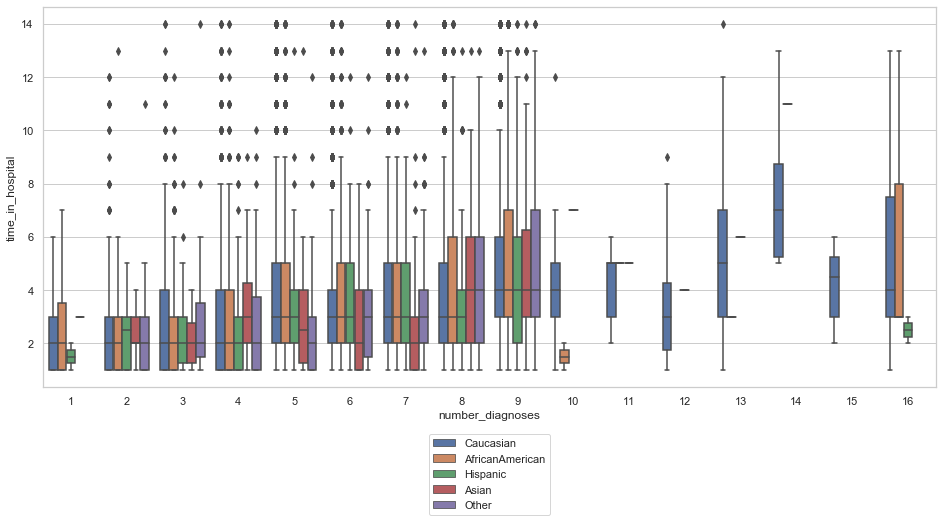

In [107]:
plt.figure(figsize = (16, 7))           
v4 =sns.boxplot(x = "number_diagnoses", y = "time_in_hospital", hue = 'race', data = df)
plt.legend(bbox_to_anchor=(.5, -.35), loc=8)

Finally, we felt like it would be beneficial to run scatter plots of each pair of variables across the entire dataset.  We did this in order to get a sense of readmission and looking for interesting clusters in the data.  Most of the pairs were not interesting and reinforced that many of these variables are correlated.

Note: These scatterplots were so large that they prevented uploading this notebook to GitHub. As such, we took screen shots and included them below.

In [ ]:
import plotly.graph_objs as go
MAX_PLOTS_PER_GRAPH = 5
all_columns = list(df)
layout = go.Layout(title='Global Font',
                   font=dict(family='Courier New, monospace', size=8))

for i in range(0, len(all_columns), MAX_PLOTS_PER_GRAPH):
    dim = []
    columns = all_columns[i:i+MAX_PLOTS_PER_GRAPH]
    for column in columns:
        dim.append(dict(label = column, values = df[column]))

    fig = go.Figure(data=go.Splom(dimensions=dim, diagonal=dict(visible=False), marker=dict(color=df['readmitted'],
                              size=5,
                              line=dict(width=0.5,
                                        color='rgb(230,230,230)') )),
                    layout=layout)

    title = "Scatterplot Matrix for Diabetes Dataset"
    fig.update_layout(title=title,
                      dragmode='select',
                      width=1000,
                      height=1000,
                      hovermode='closest')

    fig.show()

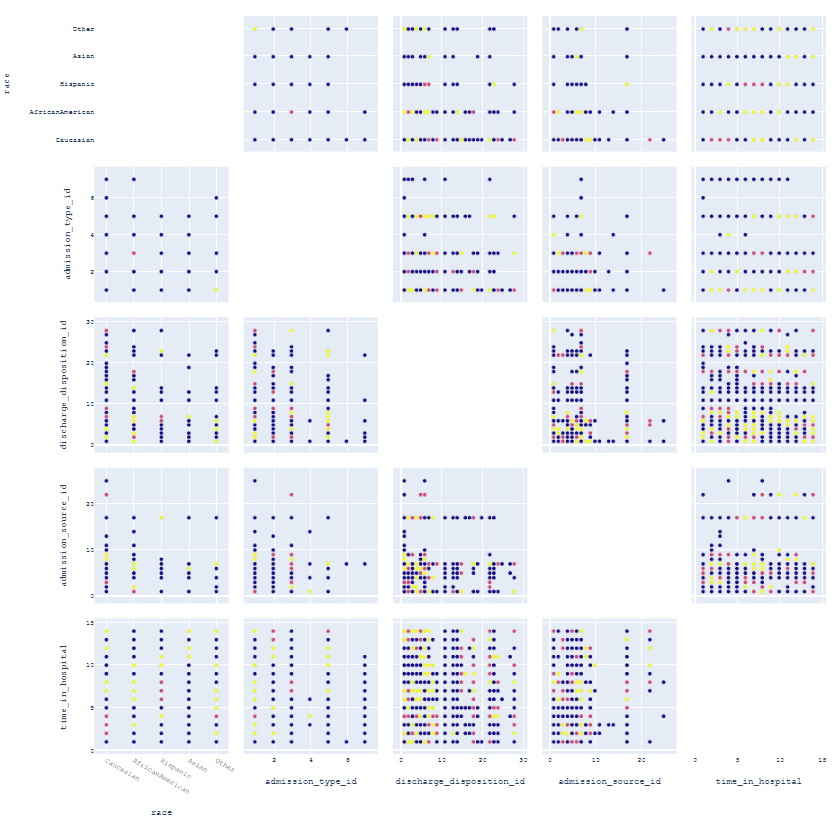

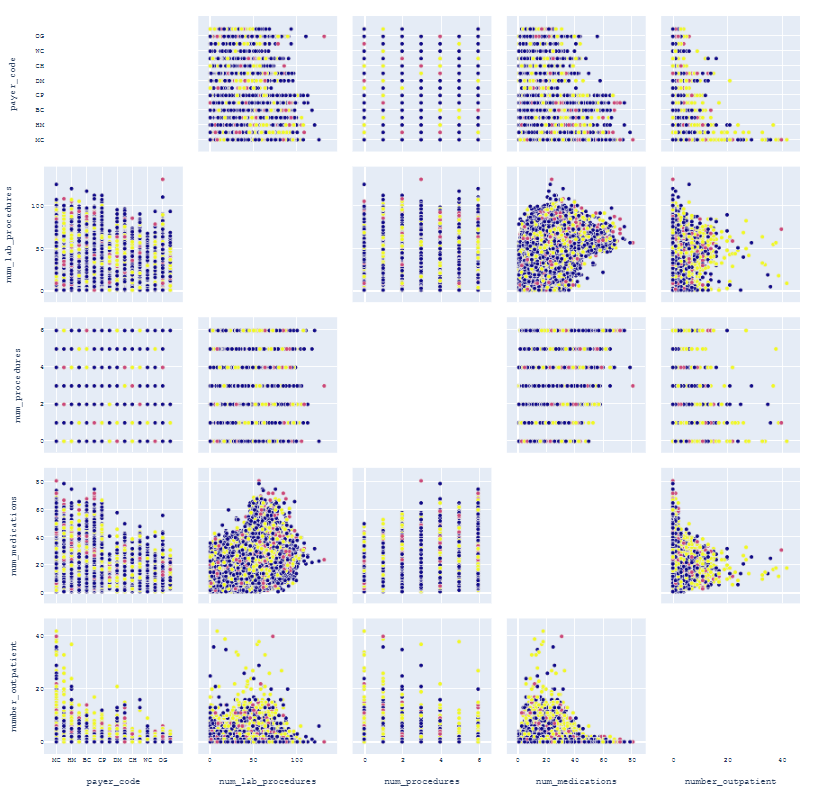

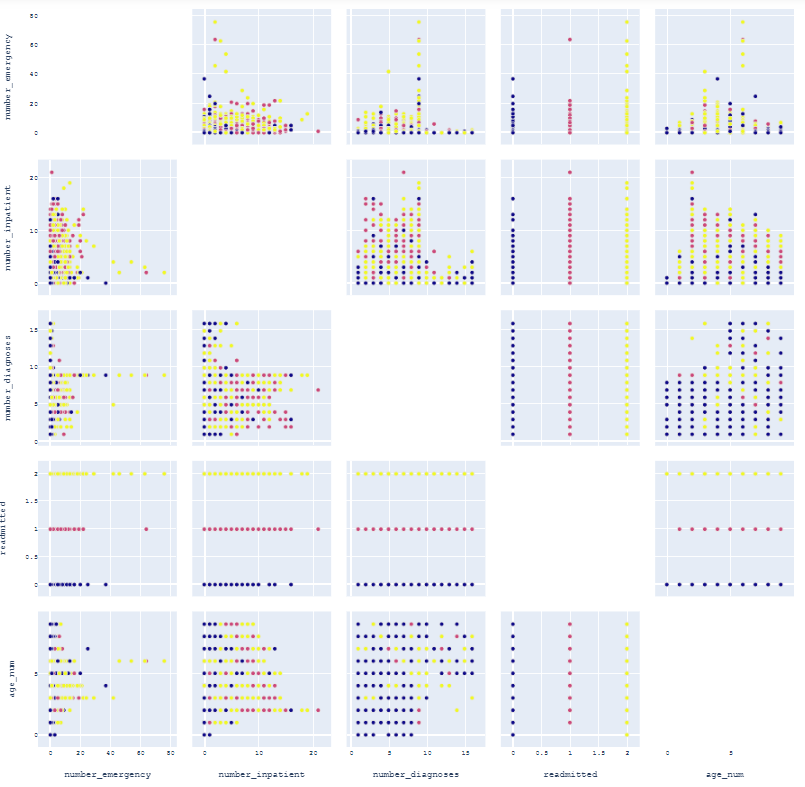

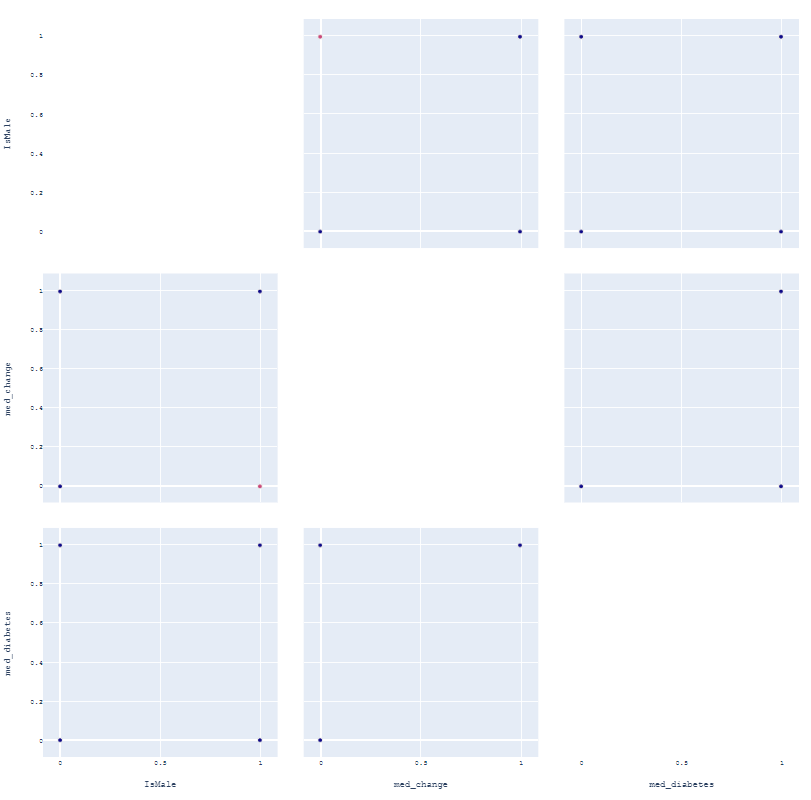

Some potential combinations for readmissions clustering were the number of lab procedures, regular procedures, number of medications, and number of outpatient visits as compared to inpatient visits.  Age and number of diagnoses also showed some clustering.  It is difficult to ascertain whether there are useful clusters with the categorical data (where no ordering is present). To learn more, though, we should apply some clustering algorithms, which we examine next.

<a id = 'Section_5'></a>

## 5. Modeling and Evaluation 1
*(10 points)*
	
*Train and adjust parameters. How did you determine a suitable number of clusters for each method?*

We evaluate a range in the number of clusters for each clustering method. The cluster labels are added back to the primary dataset and a LightGBM model is used to classify `readmitted`. The primary metric used to evaluate a suitable number of clusters is the area under the Receiver Operating Characteristic curve (AUC). The Receiver Operating Characteristic curve (ROC) graphs the performance of a classification model at all classification thresholds; it plots the true positive rate (TPR) against the false positive rate (FPR) as shown in Figure 1.

<h4 align="center">Figure 1: Area Under the Reciever Operating Curve</h4> 
<img src="https://marlin-prod.literatumonline.com/cms/attachment/34661288-1f8f-459e-b8b4-936efc49e9bc/fx1_lrg.jpg" style="width:350px;height:300px"/>

Source: [Journal of Thoracic and Cardiovascular Surgery](https://www.jtcvs.org/article/S0022-5223(18)32875-7/fulltext)

Each curve represents the graph of a single model. Movement along the curve indicates changing the threshold used for classifying a positive instance. The area under the ROC curve measures the two-dimensional area under the ROC curve and is given by the integral of the curve, or the area under the curve (AUC): $$AUC = \int_{0}^{1}TPR(x)dx = \int_{0}^{1}P(A>\tau (x))dx$$

where $x$ is the false positive rate and $A$ is the distribution of scores the model produces for data points that are actually in the positive class.

This metric is measured between 0 and 1. A higher score indicates a better model. Visually, a superior model will graph as a curve above and to the left of another curve. A straight diagonal line beginning at 0 on the bottom left and ending at 1 on the top right indicates a naive model (random guessing). Other metrics such as accuracy are not the best metric for data with imbalanced classes. 

The diabetes dataset is extremely imbalanced (see the table below). The table below shows that 53.34% of patients are not readmitted to the hospital, 11.01% are readmitted in less than 30 days and 35.66% are readmitted in great than 30 days. Balanced data would have approximately 33.33% of all arrests in each bucket (for both classifiers). 

A model with a high ROC AUC will also have a high accuracy, therefore, the AUC score will be the metric employed in this analysis.

We have chosen to use the micro-averaging method for averaging AUC, which averages the individual class's AUC by weight.

For each cluster we also print out the following metrics:

* Homogeneity - calculates if all clusters (or what ratio of clusters) have data points which are a member of a single class.
* Completeness - members of a given class are in the same cluster.
* V-measure - the harmonic mean between Homogeneity and Completeness.
* Adjusted Rand Index - the similarity between two clusters.
* Adjusted Mutual Information - the agreement between two clustering assignments.
* Silhouette Coefficient - this is the average of all Silhouette coefficients, where each Silhouette coefficient is a measure of the mean distance to the nearest cluster compared to the average distance between clusters.  There are two distance measures for this:
    * Euclidean - the simple distance between the measured points.
    * Cosine - the cosine distance is used instead.

In [129]:
count_percent(df,'readmitted')

,Count,Percent
readmitted,,
0,31885,53.34%
1,6580,11.01%
2,21316,35.66%


### LightGBM without Clustering and Cross Validation

The Gradient Boosting Machine algorithm is currently the leading model for learning on structured datasets. Gradient Boosting Machine will be implemented using the LightGBM library. LightGBM is a gradient-boosting framework that uses tree-based learning algorithms, or gradient boosted decision trees (GBDT).

Boosting is a sequential ensembling technique where instances that are hard to classify are given more weight (visualized as larger dots in Figure 3). This, in turn, allows subsequent learners to place more emphasis on learning the mis-classified data instances. Here, "learner" is used in the context to describe the program that builds a classifier.

<h4 align="center">Figure 3: Boosting</h4>
<img src="https://miro.medium.com/max/422/1*zFOpJUSU_zgg0FCPBOSXvg.png" style="width:300px;height:350px"/>

Image source: [QuantDare, "What is the difference between Bagging and Boosting?](https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/)

Gradient Boosted Decision Tree is a machine learning algorithm that sequentially trains decision trees. It is built over time by adding a new tree into the model that minimizes the error by previous learners. This is done by fitting the new tree on the residual errors of the previous trees, i.e., the new learner learns from the errors of the previous learner. The algorithm consists of splitting a node and then, using the best split, partitioning the sample space by growing nodes and updating the residuals.

Initially explained by [Jerome Friedman in 1999](https://statweb.stanford.edu/~jhf/ftp/stobst.pdf), the algorithm for GBDT for a a number of boosting rounds $M$ and a differentiable loss function $\Psi$ works as follows:

Let $F_0(x) = arg min_{\gamma}\sum_{i=1}^{n}\Psi(y_i,\gamma)$ this is a constant value that minimizes the loss function $\Psi$.
For $m=1$ to $M$ rounds:
1. Calculate the gradient, or pseudo residuals, of $\Psi$ with respect to $F_0:\;\;$ $\tilde{y}_{im} = -\left [ \frac{\partial \Psi(y_i,F_{m-1}(x_i))}{\partial xF_{m-1}(x_i)} \right ]$
2. Fit the decision tree $h_m(x)$ to $\tilde{y}_{im}$
3. Compute the step multiplier $\gamma_m$ for each leaf of $h_m(x)$
4. Let $F_m(x) = F_{m-1}(x) + \nu_m\gamma_mh_m(x)$, where $\nu_m$ is the learning rate for iteration $m$


LightGBM combines Gradient Based One Sided Sampling (GOSS) and Exclusive Feature Bundling (EFB) with gradient boosted decision trees to significantly speed up the training process of a GBDT model. GOSS retains instances with large gradients while performing random sampling on instances with small gradients. EFB identifies features that can be bundled together (mutually exclusive features) and then reduces the training complexity by merging the features (feature reduction). Additional detail of the LightGBM algorithm can be found [here](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf).

LightGBM can handle large datasets (>10,000 rows) and does not require a lot of memory to run. LightGBM grows a decision tree in a leaf-wise method (i.e., it will select the leaf with the largest delta loss, which can reduce loss and create more complex trees better than a level-wise algorithm).

We also use cross validation. Cross validation allows us to test our model on data it hasn't seen, to see how well the model performs when making predictions. Using cross validation can help identify if the model is overfitting the training data. If the model is overfitting the training data we would expect to see low evaluation metrics when predictions are created for the test dataset. We use stratified 10-fold cross validation for this project. 

In [53]:
%%time
df_cluster = df_imputed.copy()

y = df_cluster['readmitted'].values
del df_cluster['readmitted']
X = df_cluster.values

scl = StandardScaler()
X = scl.fit_transform(X)

yhat = np.zeros(y.shape)
yhat_score = np.zeros((y.shape[0],3))

cv = StratifiedKFold(n_splits=10, random_state=1)

#clf = RandomForestClassifier(n_estimators=150,random_state=1)
clf = lgb.LGBMClassifier(n_estimators=150,random_state=1)

for train, test in cv.split(X,y):
    clf_fit = clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    yhat_score[test] = clf.predict_proba(X[test])

lb=LabelBinarizer()
lb.fit(y)
y_lb = lb.transform(y)
yhat_lb = lb.transform(yhat)
print ('AUC Score Micro', roc_auc_score(y_lb, yhat_score, average='micro', multi_class='ovr'))

AUC Score Micro 0.7727171557123935
Wall time: 44.3 s


The micro AUC score for the LightGBM model is 77.27%. This is the number we are looking to try and beat from a clustering perspective. However, there are still useful insights that can be gained even if we are not able to get a higher micro AUC score.

### Clustering

The functions defined below are used throughout this project and ensure that the same results are printed for each clustering algorithm used.

In [54]:
def lgb_model(data,y):
    for train, test in cv.split(data,y):
        clf_fit = clf.fit(data[train],y[train])
        yhat[test] = clf.predict(data[test])
        yhat_score[test] = clf.predict_proba(data[test])

    lb=LabelBinarizer()
    lb.fit(y)
    y_lb = lb.transform(y)
    yhat_lb = lb.transform(yhat)
        
def cluster_metrics(y_lb, yhat_score, data, newfeature):
    print ("Clusters",i,"AUC Score Micro=", roc_auc_score(y_lb, yhat_score, average='micro', multi_class='ovr'))

    silhouette_e = metrics.silhouette_score(data, newfeature, metric='euclidean')
    silhouette_c = metrics.silhouette_score(data, newfeature, metric='cosine')
    seuclid.append(silhouette_e)
    scosine.append(silhouette_c)

    print("Homogeneity: ", metrics.homogeneity_score(y, newfeature))
    print("Completeness: ", metrics.completeness_score(y, newfeature))
    print("V-measure: ", metrics.v_measure_score(y, newfeature))
    print("Adjusted Rand Index: ", metrics.adjusted_rand_score(y, newfeature))
    print("Adjusted Mutual Information: ", metrics.adjusted_mutual_info_score(y, newfeature, average_method='arithmetic'))
    print("Silhouette Coefficient - Euclidean: ", silhouette_e)
    print("Silhouette Coefficient - Cosine: ", silhouette_c)
        
def silhouette_plot(k,seuclid,scosine):
    plt.figure(figsize=(10,5))
    plt.plot(k,seuclid,label='euclidean')
    plt.plot(k,scosine,label='cosine')
    plt.ylabel("Silhouette")
    plt.xlabel("Cluster")
    plt.title("Silhouette vs Cluster Size")
    plt.legend()
    plt.show()

### KModes Clustering

Many of the clustering algorithms reviewed in the Machine Learning course cluster on numeric variables. Categorical data can be one-hot encoded to be used in these 'numeric' clustering algorithms. Zhexue Huang in his 1998 article 'Extentions to the k-Means Algorithm for Clustering Large Data Sets with Categorical Values' introduced a k-modes algorithm that handles categorical data and a k-prototypes algorithm that handles mixed categorical and numeric data.

Both k-modes and k-prototypes are extensions of the k-means algorithm that allow for clustering with categorical variables. The k-modes extension involves using a 'simple matching dissimilarity measure', using mode instead of mean and a frequency-based method to update the cluster mode.

In the section below we cluster a variety of columns together with a range of the number of clusters. Results are printed below each cluster.

#### Admission Source and Discharge Disposition

Clusters 5 AUC Score Micro= 0.7666059773319458
Homogeneity:  0.008659675535042263
Completeness:  0.006349819546786527
V-measure:  0.007327012225455975
Adjusted Rand Index:  0.013093249017207998
Adjusted Mutual Information:  0.007267515953431243
Silhouette Coefficient - Euclidean:  0.4309310844170552
Silhouette Coefficient - Cosine:  0.004541500144291392
Clusters 6 AUC Score Micro= 0.7691300525093046
Homogeneity:  0.01765810824216597
Completeness:  0.011824329070907524
V-measure:  0.01416404487918562
Adjusted Rand Index:  0.009667627814149435
Adjusted Mutual Information:  0.01409408462479374
Silhouette Coefficient - Euclidean:  0.4375551895522113
Silhouette Coefficient - Cosine:  -0.14304852167275434
Clusters 7 AUC Score Micro= 0.7700542868289484
Homogeneity:  0.015972938994806642
Completeness:  0.009766754747785832
V-measure:  0.01212164987848909
Adjusted Rand Index:  0.005482323787392321
Adjusted Mutual Information:  0.01204203161732311
Silhouette Coefficient - Euclidean:  0.528818185

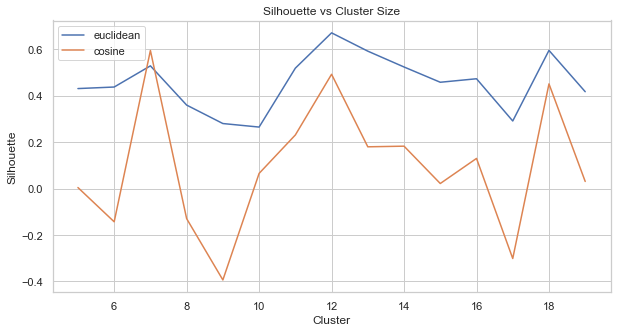

Wall time: 59min 57s


In [39]:
%%time
X1 = df[['admission_source_id','discharge_disposition_id']]

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','admission_source_1','admission_source_2','admission_source_3','admission_source_4',
               'admission_source_5','admission_source_6','admission_source_7','admission_source_8','admission_source_9',
               'admission_source_10','admission_source_11','admission_source_13','admission_source_14',
               'admission_source_17','admission_source_22','admission_source_25',
               'discharge_1','discharge_2','discharge_3','discharge_4','discharge_5','discharge_6','discharge_7',
               'discharge_8','discharge_9','discharge_11','discharge_13','discharge_14','discharge_15','discharge_16',
               'discharge_17','discharge_18','discharge_19','discharge_20','discharge_22','discharge_23','discharge_24',
               'discharge_25','discharge_27','discharge_28'], axis=1, inplace=True)
X = df_kmodes.values

scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:
    
    kp = KModes(n_clusters=i, init='Huang', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1)
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

#### KModes Results for Admission Source and Discharge Disposition

16 clusters achieved the highest micro AUC score of 77.22%. This did not beat the LightGBM model with no clustering.

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 76.66% | 0.0087 | 0.0063 | 0.0073 | 0.0131 | 0.0073 | 0.4309 | 0.0045 | 
| 6 | 76.91% | 0.0176 | 0.0118 | 0.0142 | 0.0097 | 0.0141 | 0.4376 | -0.143 | 
| 7 | 77.01% | 0.016 | 0.0098 | 0.0121 | 0.0055 | 0.012 | 0.5288 | 0.595 | 
| 8 | 77.04% | 0.0179 | 0.0109 | 0.0135 | 0.0048 | 0.0134 | 0.36 | -0.1295 | 
| 9 | 76.94% | 0.0156 | 0.0097 | 0.0119 | 0.0058 | 0.0118 | 0.2803 | -0.3936 | 
| 10 | 76.78% | 0.0121 | 0.0069 | 0.0088 | 0.0079 | 0.0087 | 0.2651 | 0.0654 | 
| 11 | 77.17% | 0.0217 | 0.0117 | 0.0152 | 0.0054 | 0.0151 | 0.5188 | 0.231 | 
| 12 | 77.02% | 0.0176 | 0.0086 | 0.0116 | 0.0042 | 0.0115 | 0.671 | 0.4925 | 
| 13 | 77.21% | 0.0242 | 0.0128 | 0.0167 | 0.0076 | 0.0166 | 0.5921 | 0.18 | 
| 14 | 77.13% | 0.0226 | 0.0115 | 0.0152 | 0.0064 | 0.0151 | 0.5239 | 0.1828 | 
| 15 | 77.12% | 0.0246 | 0.012 | 0.0161 | -0.0003 | 0.016 | 0.4581 | 0.0219 | 
| **16** | **77.22%** | **0.0243** | **0.0121** | **0.0161** | **0.0063** | **0.016** | **0.4732** | **0.13** | 
| 17 | 77.17% | 0.0194 | 0.0105 | 0.0136 | 0.004 | 0.0134 | 0.2913 | -0.3013 | 
| 18 | 77.21% | 0.0256 | 0.0123 | 0.0166 | 0.0027 | 0.0164 | 0.5954 | 0.4511 | 
| 19 | 77.17% | 0.0229 | 0.0115 | 0.0153 | 0.002 | 0.0151 | 0.4174 | 0.0307 | 

#### Admission Source and Race

Clusters 5 AUC Score Micro= 0.7723331924794767
Homogeneity:  0.004619400661885111
Completeness:  0.003636707579448766
V-measure:  0.004069571015428953
Adjusted Rand Index:  -0.00982461159530787
Adjusted Mutual Information:  0.0040074800322188586
Silhouette Coefficient - Euclidean:  0.8127773505013275
Silhouette Coefficient - Cosine:  0.7729673785547396
Clusters 6 AUC Score Micro= 0.7752335080884117
Homogeneity:  0.005890122470435238
Completeness:  0.004963798218886645
V-measure:  0.005387431927070271
Adjusted Rand Index:  -0.001988038862705702
Adjusted Mutual Information:  0.005306864931025592
Silhouette Coefficient - Euclidean:  0.6191729431960252
Silhouette Coefficient - Cosine:  0.4980895517348209
Clusters 7 AUC Score Micro= 0.7732067373022151
Homogeneity:  0.008125232947625181
Completeness:  0.006043651733360355
V-measure:  0.0069315375618479455
Adjusted Rand Index:  -0.008618436580011476
Adjusted Mutual Information:  0.0068415589469925904
Silhouette Coefficient - Euclidean:  0.845

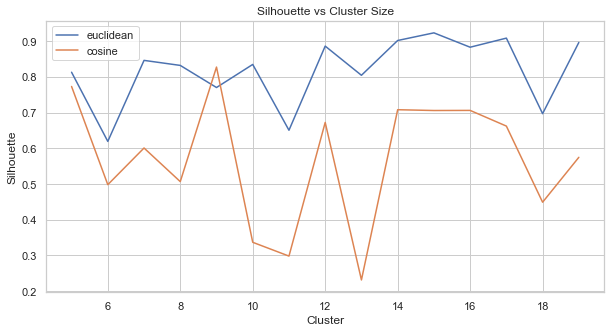

Wall time: 1h 4min 37s


In [40]:
%%time
X1 = df[['admission_source_id','race']]
cleanup_race = {"race": {"AfricanAmerican": 0, "Asian": 1, "Caucasian": 2, "Hispanic": 3, "Other": 4}}
X1.replace(cleanup_race,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','admission_source_1','admission_source_2','admission_source_3','admission_source_4',
               'admission_source_5','admission_source_6','admission_source_7','admission_source_8','admission_source_9',
               'admission_source_10','admission_source_11','admission_source_13','admission_source_14',
               'admission_source_17','admission_source_22','admission_source_25',
               'race_AfricanAmerican','race_Asian','race_Caucasian','race_Hispanic','race_Other'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:
    
    kp = KModes(n_clusters=i, init='Huang', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1)
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

#### KModes Results for Admission Source and Race

6 clusters achieved the highest micro AUC score of 77.52%. This **did** beat the LightGBM model with no clustering.

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 77.23% | 0.0046 | 0.0036 | 0.0041 | -0.0098 | 0.004 | 0.8128 | 0.773 | 
| **6** | **77.52%** | **0.0059** | **0.005** | **0.0054** | **-0.002** | **0.0053** | **0.6192** | **0.4981** | 
| 7 | 77.32% | 0.0081 | 0.006 | 0.0069 | -0.0086 | 0.0068 | 0.8459 | 0.6007 | 
| 8 | 77.30% | 0.0095 | 0.0068 | 0.0079 | -0.0092 | 0.0078 | 0.8312 | 0.5066 | 
| 9 | 77.32% | 0.0083 | 0.0057 | 0.0068 | -0.0109 | 0.0067 | 0.77 | 0.8272 | 
| 10 | 77.26% | 0.0081 | 0.0053 | 0.0064 | -0.0122 | 0.0063 | 0.8346 | 0.3368 | 
| 11 | 77.45% | 0.0074 | 0.0049 | 0.0059 | -0.0126 | 0.0057 | 0.6504 | 0.2982 | 
| 12 | 77.33% | 0.0095 | 0.0059 | 0.0073 | -0.0122 | 0.0071 | 0.8859 | 0.6723 | 
| 13 | 77.30% | 0.0097 | 0.0066 | 0.0079 | -0.0098 | 0.0077 | 0.8042 | 0.2314 | 
| 14 | 77.34% | 0.0096 | 0.0059 | 0.0072 | -0.0125 | 0.0071 | 0.9016 | 0.7079 | 
| 15 | 77.28% | 0.001 | 0.0063 | 0.0077 | -0.0121 | 0.0075 | 0.923 | 0.7056 | 
| 16 | 77.35% | 0.0097 | 0.0059 | 0.0074 | -0.0121 | 0.0072 | 0.8823 | 0.7059 | 
| 17 | 77.34% | 0.0102 | 0.0061 | 0.0077 | -0.0124 | 0.0075 | 0.9082 | 0.662 | 
| 18 | 77.46% | 0.0077 | 0.0048 | 0.0059 | -0.013 | 0.0057 | 0.6968 | 0.449 | 
| 19 | 77.27% | 0.0091 | 0.0056 | 0.0069 | -0.0125 | 0.0067 | 0.8961 | 0.5747 | 

#### Admission Source, Discharge Disposition and Admission Type

Clusters 5 AUC Score Micro= 0.7636677058452146
Homogeneity:  0.004904057177943592
Completeness:  0.003515014800840779
V-measure:  0.004094948613832888
Adjusted Rand Index:  0.011923314954187839
Adjusted Mutual Information:  0.0040361033362918824
Silhouette Coefficient - Euclidean:  0.32795946038708945
Silhouette Coefficient - Cosine:  0.21131741266828205
Clusters 6 AUC Score Micro= 0.766141872634019
Homogeneity:  0.006704908264590163
Completeness:  0.004219500860652912
V-measure:  0.005179477602621828
Adjusted Rand Index:  0.01031840803957022
Adjusted Mutual Information:  0.005111491746102561
Silhouette Coefficient - Euclidean:  0.40187342076139615
Silhouette Coefficient - Cosine:  0.36047920348337387
Clusters 7 AUC Score Micro= 0.7651757398191079
Homogeneity:  0.005720534585466052
Completeness:  0.0032656096074999332
V-measure:  0.004157741585530398
Adjusted Rand Index:  0.007224075235686005
Adjusted Mutual Information:  0.004080291845088312
Silhouette Coefficient - Euclidean:  0.3111

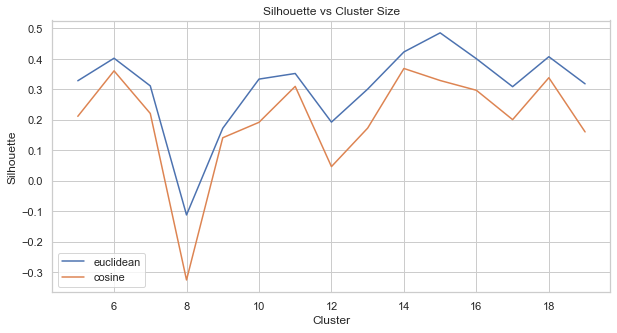

Wall time: 56min 41s


In [41]:
%%time
X1 = df[['admission_source_id','discharge_disposition_id','admission_type_id']]

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','admission_source_1','admission_source_2','admission_source_3','admission_source_4',
               'admission_source_5','admission_source_6','admission_source_7','admission_source_8','admission_source_9',
               'admission_source_10','admission_source_11','admission_source_13','admission_source_14',
               'admission_source_17','admission_source_22','admission_source_25',
               'discharge_1','discharge_2','discharge_3','discharge_4','discharge_5','discharge_6','discharge_7',
               'discharge_8','discharge_9','discharge_11','discharge_13','discharge_14','discharge_15','discharge_16',
               'discharge_17','discharge_18','discharge_19','discharge_20','discharge_22','discharge_23','discharge_24',
               'discharge_25','discharge_27','discharge_28',
               'admission_type_1','admission_type_2','admission_type_3','admission_type_4','admission_type_5',
               'admission_type_6','admission_type_7'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:
    
    kp = KModes(n_clusters=i, init='Huang', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1)
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

#### KModes Results for Admission Source, Discharge Disposition and Admission Type

15 clusters achieved the highest micro AUC score of 77.01%. This did not beat the LightGBM model with no clustering.

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 76.34% | 0.0049 | 0.0035 | 0.0041 | 0.0119 | 0.004 | 0.328 | 0.2113 | 
| 6 | 76.61% | 0.0067 | 0.0042 | 0.0052 | 0.0103 | 0.0051 | 0.4019 | 0.3605 | 
| 7 | 76.52% | 0.0057 | 0.0033 | 0.0042 | 0.0072 | 0.0041 | 0.3112 | 0.2208 | 
| 8 | 76.71% | 0.0135 | 0.0082 | 0.0102 | -0.0066 | 0.01 | -0.1121 | -0.3254 | 
| 9 | 76.46% | 0.0058 | 0.0032 | 0.0041 | 0.0008 | 0.004 | 0.1721 | 0.141 | 
| 10 | 76.65% | 0.0114 | 0.0057 | 0.0076 | 0.0051 | 0.0075 | 0.3334 | 0.1916 | 
| 11 | 77.13% | 0.0173 | 0.0056 | 0.0114 | 0.0033 | 0.0113 | 0.3518 | 0.3095 | 
| 12 | 76.39% | 0.0078 | 0.0037 | 0.005 | 0.0006 | 0.0049 | 0.1923 | 0.0464 | 
| 13 | 76.94% | 0.0186 | 0.0085 | 0.0116 | 0.0007 | 0.0115 | 0.3007 | 0.1728 | 
| 14 | 77.00% | 0.0177 | 0.0078 | 0.0108 | 0.0049 | 0.0107 | 0.4225 | 0.3683 | 
| **15** | **77.01%** | **0.0195** | **0.0085** | **0.0118** | **0.0035** | **0.0117** | **0.4851** | **0.3288** | 
| 16 | 76.86% | 0.0173 | 0.0078 | 0.0107 | 0.0015 | 0.0105 | 0.4002 | 0.2967 | 
| 17 | 76.71% | 0.0185 | 0.0082 | 0.0114 | 0.0004 | 0.0112 | 0.3086 | 0.2005 | 
| 18 | 76.98% | 0.0195 | 0.0086 | 0.012 | 0.001 | 0.0118 | 0.4069 | 0.3379 | 
| 19 | 76.78% | 0.0173 | 0.0072 | 0.0102 | 0.0009 | 0.01 | 0.3179 | 0.1602 | 

#### Admission Source and Payer Code

Clusters 5 AUC Score Micro= 0.7724993010535302
Homogeneity:  0.0028656355798864644
Completeness:  0.002387580182411711
V-measure:  0.002604855779827176
Adjusted Rand Index:  -0.005379613999818833
Adjusted Mutual Information:  0.00254069369582187
Silhouette Coefficient - Euclidean:  0.3838955659701799
Silhouette Coefficient - Cosine:  -0.03862021598659089
Clusters 6 AUC Score Micro= 0.7727357530306093
Homogeneity:  0.007206951040108488
Completeness:  0.00448099155349566
V-measure:  0.005526085789445084
Adjusted Rand Index:  -0.0016576853279339152
Adjusted Mutual Information:  0.005458627883243053
Silhouette Coefficient - Euclidean:  0.29680242121472805
Silhouette Coefficient - Cosine:  0.06258724305998735
Clusters 7 AUC Score Micro= 0.772226482697487
Homogeneity:  0.006264103323801357
Completeness:  0.003681254481279044
V-measure:  0.0046372908615030526
Adjusted Rand Index:  -0.0038362896147805057
Adjusted Mutual Information:  0.004559068139397412
Silhouette Coefficient - Euclidean:  0.

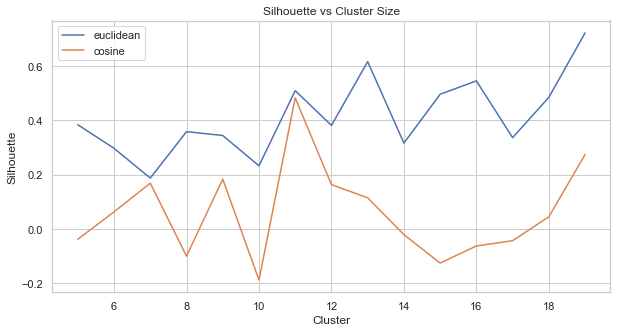

Wall time: 51min 11s


In [43]:
%%time
X1 = df[['admission_source_id','payer_code']]
cleanup_pc = {"payer_code": {"BC": 0, "CH": 1, "CM": 2, "CP": 3, "DM": 4, "HM": 5, "MC": 6, "MD": 7, "MP":8, "OG": 9,
                         "OT": 10, "PO": 11, "SI": 12, "SP": 13, "UN": 14, "WC": 15}}
X1.replace(cleanup_pc,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','admission_source_1','admission_source_2','admission_source_3','admission_source_4',
               'admission_source_5','admission_source_6','admission_source_7','admission_source_8','admission_source_9',
               'admission_source_10','admission_source_11','admission_source_13','admission_source_14',
               'admission_source_17','admission_source_22','admission_source_25',
               'payer_BC','payer_CH','payer_CM','payer_CP','payer_DM','payer_HM','payer_MC',
               'payer_MD','payer_MP','payer_OG','payer_OT','payer_PO','payer_SI','payer_SP','payer_UN',
               'payer_WC'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:

    kp = KModes(n_clusters=i, init='Huang', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1)
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

#### KModes Results for Admission Source and Payer Code

9 clusters achieved the highest micro AUC score of 77.49%. This **did**  beat the LightGBM model with no clustering.

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 77.26% | 0.0029 | 0.0024 | 0.0026 | -0.0054 | 0.0025 | 0.3839 | -0.0386 | 
| 6 | 77.27% | 0.0072 | 0.0045 | 0.0055 | -0.0017 | 0.0055 | 0.2968 | 0.0626 | 
| 7 | 77.22% | 0.0063 | 0.0037 | 0.0046 | -0.0038 | 0.0046 | 0.1871 | 0.1684 | 
| 8 | 77.24% | 0.0068 | 0.0041 | 0.0051 | -0.0006 | 0.005 | 0.3583 | -0.1007 | 
| **9** | **77.49%** | **0.0079** | **0.0044** | **0.0057** | **-0.0014** | **0.0056** | **0.3442** | **0.1831** | 
| 10 | 77.22% | 0.0042 | 0.0023 | 0.0029 | -0.0046 | 0.0028 | 0.2325 | -0.1886 | 
| 11 | 77.23% | 0.0076 | 0.0039 | 0.0052 | -0.0022 | 0.0051 | 0.5095 | 0.4831 | 
| 12 | 77.35% | 0.0077 | 0.0035 | 0.0048 | -0.0066 | 0.0047 | 0.3814 | 0.163 | 
| 13 | 77.27% | 0.0075 | 0.0037 | 0.005 | -0.0003 | 0.0048 | 0.6166 | 0.1142 | 
| 14 | 77.25% | 0.009 | 0.0041 | 0.0056 | -0.0121 | 0.0054 | 0.3162 | -0.0214 | 
| 15 | 77.30% | 0.0087 | 0.0039 | 0.0054 | -0.0074 | 0.0052 | 0.4963 | -0.1264 | 
| 16 | 77.29% | 0.0097 | 0.0042 | 0.0059 | -0.0091 | 0.0057 | 0.5456 | -0.0633 | 
| 17 | 77.46% | 0.0077 | 0.0035 | 0.0048 | -0.0072 | 0.0047 | 0.3363 | -0.0439 | 
| 18 | 77.44% | 0.0076 | 0.0033 | 0.0046 | -0.0069 | 0.0044 | 0.4849 | 0.0442 | 
| 19 | 77.24% | 0.0095 | 0.0039 | 0.0056 | -0.0077 | 0.0054 | 0.7227 | 0.274 | 

#### Admission Type and Payer Code

Clusters 5 AUC Score Micro= 0.7729360557664924
Homogeneity:  0.0024770955818110576
Completeness:  0.0015480660049871841
V-measure:  0.0019053682087609867
Adjusted Rand Index:  -0.0029590866874920465
Adjusted Mutual Information:  0.0018510459629018576
Silhouette Coefficient - Euclidean:  0.16271625720094027
Silhouette Coefficient - Cosine:  0.035205627529058967
Clusters 6 AUC Score Micro= 0.7729630261800873
Homogeneity:  0.0027183488194803796
Completeness:  0.0016027294763263237
V-measure:  0.0020165234146051043
Adjusted Rand Index:  -0.0020105885447466248
Adjusted Mutual Information:  0.0019510360687725518
Silhouette Coefficient - Euclidean:  0.1794354296648501
Silhouette Coefficient - Cosine:  -0.05659216951193773
Clusters 7 AUC Score Micro= 0.7730796234255009
Homogeneity:  0.003031395893854159
Completeness:  0.0017096511488194992
V-measure:  0.0021862805518722685
Adjusted Rand Index:  -0.002781007669895521
Adjusted Mutual Information:  0.0021098328856357686
Silhouette Coefficient - E

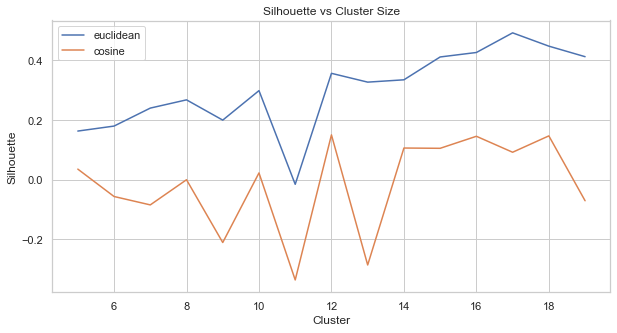

Wall time: 51min 32s


In [35]:
%%time
X1 = df[['admission_type_id','payer_code']]
cleanup_pc = {"payer_code": {"BC": 0, "CH": 1, "CM": 2, "CP": 3, "DM": 4, "HM": 5, "MC": 6, "MD": 7, "MP":8, "OG": 9,
                         "OT": 10, "PO": 11, "SI": 12, "SP": 13, "UN": 14, "WC": 15}}
X1.replace(cleanup_pc,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','admission_type_1','admission_type_2','admission_type_3','admission_type_4',
                'admission_type_5','admission_type_6','admission_type_7',
                'payer_BC','payer_CH','payer_CM','payer_CP','payer_DM','payer_HM','payer_MC',
                'payer_MD','payer_MP','payer_OG','payer_OT','payer_PO','payer_SI','payer_SP','payer_UN',
                'payer_WC'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:
    
    kp = KModes(n_clusters=i, init='Huang', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1)
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

#### KModes Results for Admission Type and Payer Code

13 clusters achieved the highest micro AUC score of 77.35%. This **did**  beat the LightGBM model with no clustering.

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 77.29% | 0.0025 | 0.0015 | 0.0019 | -0.003 | 0.0019 | 0.1627 | 0.0352 | 
| 6 | 77.30% | 0.0027 | 0.0016 | 0.002 | -0.002 | 0.002 | 0.1794 | -0.0566 | 
| 7 | 77.31% | 0.003 | 0.0017 | 0.0022 | -0.0028 | 0.0021 | 0.2397 | -0.0847 | 
| 8 | 77.28% | 0.0029 | 0.0015 | 0.002 | -0.0037 | 0.0019 | 0.2673 | -0.0004 | 
| 9 | 77.33% | 0.003 | 0.0016 | 0.0021 | -0.0036 | 0.002 | 0.1994 | -0.2108 | 
| 10 | 77.28% | 0.0033 | 0.0016 | 0.0021 | -0.0036 | 0.002 | 0.2982 | 0.0224 | 
| 11 | 77.30% | 0.0027 | 0.0014 | 0.0018 | -0.0052 | 0.0017 | -0.0157 | -0.3363 | 
| 12 | 77.33% | 0.0042 | 0.0019 | 0.0026 | -0.0046 | 0.0025 | 0.3562 | 0.15 | 
| **13** | **77.35%** | **0.0044** | **0.002** | **0.0027** | **-0.0046** | **0.0026** | **0.3267** | **-0.286** | 
| 14 | 77.30% | 0.004 | 0.0018 | 0.0025 | -0.0045 | 0.0024 | 0.3345 | 0.1059 | 
| 15 | 77.29% | 0.0033 | 0.0015 | 0.002 | -0.0044 | 0.0019 | 0.411 | 0.1049 | 
| 16 | 77.26% | 0.0046 | 0.0019 | 0.0027 | -0.0033 | 0.0026 | 0.4261 | 0.1452 | 
| 17 | 77.32% | 0.0047 | 0.0019 | 0.0027 | -0.0063 | 0.0025 | 0.4919 | 0.0917 | 
| 18 | 77.31% | 0.0039 | 0.0016 | 0.0023 | -0.0057 | 0.0021 | 0.4473 | 0.1466 | 
| 19 | 77.31% | 0.0049 | 0.0021 | 0.0029 | -0.0053 | 0.0027 | 0.412 | -0.0708 | 

#### Admission Source, Payer Code and Admission Type

Clusters 5 AUC Score Micro= 0.7746358544289383
Homogeneity:  0.0015070214598440466
Completeness:  0.0011448406252731887
V-measure:  0.001301198429639827
Adjusted Rand Index:  -0.0037535088382280746
Adjusted Mutual Information:  0.0012401766991869505
Silhouette Coefficient - Euclidean:  0.2866049934383883
Silhouette Coefficient - Cosine:  0.14325917646173295
Clusters 6 AUC Score Micro= 0.7743858393161076
Homogeneity:  0.0035311236396985924
Completeness:  0.0022220049571240953
V-measure:  0.0027276199721875155
Adjusted Rand Index:  -0.0025619410188596247
Adjusted Mutual Information:  0.002659479595558419
Silhouette Coefficient - Euclidean:  0.07342721693153184
Silhouette Coefficient - Cosine:  -0.022594583445439163
Clusters 7 AUC Score Micro= 0.7737656634893091
Homogeneity:  0.0026604397518748125
Completeness:  0.0015593244331444775
V-measure:  0.001966218265340466
Adjusted Rand Index:  -0.0031845768072264182
Adjusted Mutual Information:  0.001887899529828875
Silhouette Coefficient - Euc

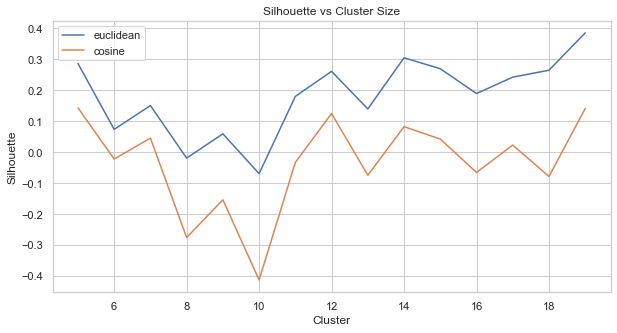

Wall time: 50min 2s


In [36]:
%%time
X1 = df[['admission_source_id','payer_code','admission_type_id']]
cleanup_pc = {"payer_code": {"BC": 0, "CH": 1, "CM": 2, "CP": 3, "DM": 4, "HM": 5, "MC": 6, "MD": 7, "MP":8, "OG": 9,
                         "OT": 10, "PO": 11, "SI": 12, "SP": 13, "UN": 14, "WC": 15}}
X1.replace(cleanup_pc,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','admission_source_1','admission_source_2','admission_source_3','admission_source_4',
               'admission_source_5','admission_source_6','admission_source_7','admission_source_8','admission_source_9',
               'admission_source_10','admission_source_11','admission_source_13','admission_source_14',
               'admission_source_17','admission_source_22','admission_source_25',
               'payer_BC','payer_CH','payer_CM','payer_CP','payer_DM','payer_HM','payer_MC',
               'payer_MD','payer_MP','payer_OG','payer_OT','payer_PO','payer_SI','payer_SP','payer_UN','payer_WC',
                'admission_type_1','admission_type_2','admission_type_3','admission_type_4',
                'admission_type_5','admission_type_6','admission_type_7'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:

    kp = KModes(n_clusters=i, init='Huang', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1)
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

#### KModes Results for Admission Source, Payer Code and Admission Type

17 clusters achieved the highest micro AUC score of 77.47%. This **did**  beat the LightGBM model with no clustering.

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 77.46% | 0.0015 | 0.0011 | 0.0013 | -0.0038 | 0.0012 | 0.2866 | 0.1433 | 
| 6 | 77.44% | 0.0035 | 0.0022 | 0.0027 | -0.0026 | 0.0027 | 0.0734 | -0.0226 | 
| 7 | 77.38% | 0.0027 | 0.0016 | 0.002 | -0.0032 | 0.0019 | 0.1505 | 0.0452 | 
| 8 | 77.46% | 0.0037 | 0.0022 | 0.0028 | -0.0033 | 0.0027 | -0.0196 | -0.2767 | 
| 9 | 77.44% | 0.0064 | 0.0032 | 0.0043 | -0.0013 | 0.0042 | 0.0591 | -0.1545 | 
| 10 | 77.27% | 0.0042 | 0.0023 | 0.003 | -0.0019 | 0.0029 | -0.07 | -0.4138 | 
| 11 | 77.39% | 0.004 | 0.0019 | 0.0026 | -0.0036 | 0.0024 | 0.1802 | -0.0334 | 
| 12 | 77.40% | 0.0074 | 0.0037 | 0.005 | -0.0021 | 0.0048 | 0.2613 | 0.1248 | 
| 13 | 77.41% | 0.0039 | 0.0018 | 0.0022 | -0.0023 | 0.0023 | 0.134 | -0.075 | 
| 14 | 77.24% | 0.0061 | 0.0027 | 0.0037 | -0.0029 | 0.0036 | 0.3052 | 0.0821 | 
| 15 | 77.27% | 0.0067 | 0.0029 | 0.0041 | -0.0028 | 0.0039 | 0.2697 | 0.0421 | 
| 16 | 77.45% | 0.0041 | 0.0019 | 0.0026 | -0.0019 | 0.0024 | 0.1894 | -0.066 | 
| **17** | **77.47%** | **0.0046** | **0.0019** | **0.0026** | **-0.0043** | **0.0025** | **0.2425** | **0.0225** | 
| 18 | 77.38% | 0.0072 | 0.0031 | 0.0043 | -0.0023 | 0.0042 | 0.2648 | -0.079 | 
| 19 | 77.28% | 0.0074 | 0.003 | 0.0043 | -0.0034 | 0.0041 | 0.3858 | 0.141 | 

#### Discharge Disposition and Race

Clusters 5 AUC Score Micro= 0.7623806478856057
Homogeneity:  0.002252299723659043
Completeness:  0.002451386602501491
V-measure:  0.0023476299160035234
Adjusted Rand Index:  0.0007368551049974985
Adjusted Mutual Information:  0.0022732757471847042
Silhouette Coefficient - Euclidean:  0.06905002967112246
Silhouette Coefficient - Cosine:  0.31604088103589667
Clusters 6 AUC Score Micro= 0.7637371376053925
Homogeneity:  0.004987400860727888
Completeness:  0.003607526398387765
V-measure:  0.004186697507029038
Adjusted Rand Index:  0.004628274807084982
Adjusted Mutual Information:  0.0041121963432372306
Silhouette Coefficient - Euclidean:  0.5315708382832263
Silhouette Coefficient - Cosine:  0.3073929395864401
Clusters 7 AUC Score Micro= 0.767144010024886
Homogeneity:  0.01339129709235038
Completeness:  0.010155618461816557
V-measure:  0.011551143814645181
Adjusted Rand Index:  0.0052495722940992156
Adjusted Mutual Information:  0.011459993793319547
Silhouette Coefficient - Euclidean:  0.394

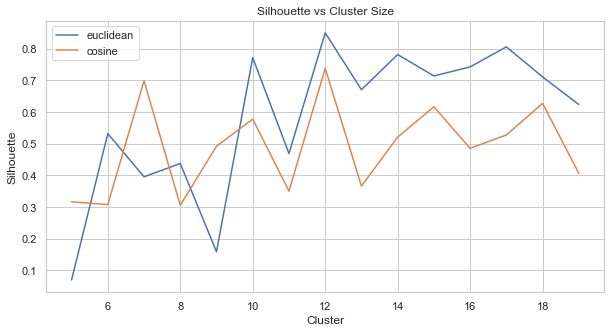

Wall time: 49min 35s


In [38]:
%%time
X1 = df[['discharge_disposition_id','race']]
cleanup_race = {"race": {"AfricanAmerican": 0, "Asian": 1, "Caucasian": 2, "Hispanic": 3, "Other": 4}}
X1.replace(cleanup_race,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','admission_source_1','discharge_1','discharge_2','discharge_3','discharge_4','discharge_5',
                'discharge_6','discharge_7','discharge_8','discharge_9','discharge_11','discharge_13','discharge_14',
                'discharge_15','discharge_16','discharge_17','discharge_18','discharge_19','discharge_20',
                'discharge_22','discharge_23','discharge_24','discharge_25','discharge_27','discharge_28',
                'race_AfricanAmerican','race_Asian','race_Caucasian','race_Hispanic','race_Other'],
               axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:
    
    kp = KModes(n_clusters=i, init='Huang', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1)
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

#### KModes Results for Discharge Disposition and Race

17 clusters achieved the highest micro AUC score of 77.14%. This did not beat the LightGBM model with no clustering.

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 76.24% | 0.0023 | 0.0025 | 0.0023 | 0.0007 | 0.0023 | 0.0691 | 0.316 | 
| 6 | 76.37% | 0.005 | 0.0036 | 0.0042 | 0.0046 | 0.0041 | 0.5316 | 0.3074 | 
| 7 | 76.71% | 0.0134 | 0.0102 | 0.0116 | 0.0052 | 0.0115 | 0.395 | 0.6987 | 
| 8 | 76.91% | 0.0155 | 0.0104 | 0.0124 | 0.0052 | 0.1235 | 0.437 | 0.3051 | 
| 9 | 76.75% | 0.0136 | 0.0091 | 0.0109 | 0.0054 | 0.0108 | 0.1581 | 0.4915 | 
| 10 | 76.68% | 0.0083 | 0.0048 | 0.006 | 0.0073 | 0.0059 | 0.7714 | 0.5772 | 
| 11 | 76.88% | 0.0157 | 0.0097 | 0.012 | 0.0062 | 0.0119 | 0.4687 | 0.3499 | 
| 12 | 77.01% | 0.0173 | 0.0093 | 0.0121 | 0.0069 | 0.0119 | 0.8499 | 0.7375 | 
| 13 | 76.68% | 0.0097 | 0.0056 | 0.0072 | 0.0077 | 0.007 | 0.6704 | 0.3657 | 
| 14 | 77.09% | 0.0186 | 0.0103 | 0.0133 | 0.0091 | 0.0134 | 0.7814 | 0.5205 | 
| 15 | 76.97% | 0.0163 | 0.0094 | 0.012 | 0.0099 | 0.0118 | 0.7137 | 0.6161 | 
| 16 | 77.04% | 0.0189 | 0.0106 | 0.0136 | 0.0073 | 0.0134 | 0.7423 | 0.485 | 
| **17** | **77.15%** | **0.0196** | **0.0107** | **0.0138** | **0.0071** | **0.0136** | **0.8057** | **0.5273** | 
| 18 | 77.06% | 0.0189 | 0.01 | 0.0131 | 0.007 | 0.0129 | 0.7106 | 0.627 | 
| 19 | 76.94% | 0.0175 | 0.0097 | 0.0125 | 0.0106 | 0.0123 | 0.6234 | 0.4058 | 

### KPrototypes Clustering

k-prototypes combines k-means and k-modes to handle both numeric and categorical data. The dissimilarity measure used weights the k-mean Euclidean dissimilarity measure and a dissimilarity measure for categorical variables. The k-modes approach for updating cluster centers is used for k-prototypes.

Below we try a variety of variable combinations and run through a range in the number of clusters for each combination. Results are again printed below each variable group.

#### Payer Code and Number of Procedures

Clusters 5 AUC Score Micro= 0.77256637367901
Homogeneity:  0.0013214863508954728
Completeness:  0.0009223970116020188
V-measure:  0.001086451355993958
Adjusted Rand Index:  -0.0027270410067541644
Adjusted Mutual Information:  0.0010283397541512153
Silhouette Coefficient - Euclidean:  -0.11754386330973349
Silhouette Coefficient - Cosine:  -0.5210858332036123
Clusters 6 AUC Score Micro= 0.7725797852940123
Homogeneity:  0.002170891185408113
Completeness:  0.0013705878023003231
V-measure:  0.001680313218950889
Adjusted Rand Index:  -0.00441506938027137
Adjusted Mutual Information:  0.0016119627578036202
Silhouette Coefficient - Euclidean:  -0.03872515884651907
Silhouette Coefficient - Cosine:  0.19271384403610162
Clusters 7 AUC Score Micro= 0.7728971486517839
Homogeneity:  0.0023620977614669325
Completeness:  0.0013367900415989793
V-measure:  0.0017073395749906013
Adjusted Rand Index:  -0.004710995807442723
Adjusted Mutual Information:  0.001630746520730794
Silhouette Coefficient - Euclide

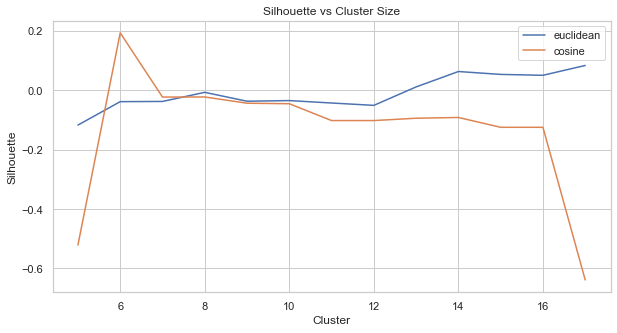

Wall time: 56min 20s


In [42]:
%%time
X1 = df[['payer_code','num_procedures']]
cleanup_pc = {"payer_code": {"BC": 0, "CH": 1, "CM": 2, "CP": 3, "DM": 4, "HM": 5, "MC": 6, "MD": 7, "MP":8, "OG": 9,
                         "OT": 10, "PO": 11, "SI": 12, "SP": 13, "UN": 14, "WC": 15}}
X1.replace(cleanup_pc,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','payer_BC','payer_CH','payer_CM','payer_CP','payer_DM','payer_HM','payer_MC',
                'payer_MD','payer_MP','payer_OG','payer_OT','payer_PO','payer_SI','payer_SP','payer_UN',
                'payer_WC','num_procedures'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,18)
for i in k:
    
    kp = KPrototypes(n_clusters=i, init='Cao', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1, categorical=[0])
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

#### KPrototypes Results for Payer Code and Number of Procedures

8 clusters achieved the highest micro AUC score of 77.31%. This **did** beat the LightGBM model with no clustering.

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 77.26% | 0.0013 | 0.0009 | 0.0011 | -0.0027 | 0.001 | -0.1175 | -0.5211 | 
| 6 | 77.26% | 0.0022 | 0.0014 | 0.0017 | -0.0044 | 0.0016 | -0.0387 | 0.1927 | 
| 7 | 77.29% | 0.0024 | 0.0013 | 0.0017 | -0.0047 | 0.0016 | -0.038 | -0.0233 | 
| **8** | **77.31%** | **0.0023** | **0.0013** | **0.0016** | **-0.0043** | **0.0016** | **-0.0074** | **-0.023** | 
| 9 | 77.28% | 0.0024 | 0.0013 | 0.0017 | -0.0039 | 0.0016 | -0.0373 | -0.044 | 
| 10 | 77.30% | 0.0025 | 0.0012 | 0.0017 | -0.0044 | 0.0015 | -0.0351 | -0.0457 | 
| 11 | 77.28% | 0.0026 | 0.0013 | 0.0017 | -0.0045 | 0.0016 | -0.0433 | -0.1024 | 
| 12 | 77.29% | 0.0026 | 0.0013 | 0.0017 | -0.0046 | 0.0016 | -0.0512 | -0.1023 | 
| 13 | 77.28% | 0.0026 | 0.0013 | 0.0017 | -0.0045 | 0.0016 | 0.0108 | -0.0945 | 
| 14 | 77.26% | 0.003 | 0.0013 | 0.0019 | -0.0049 | 0.0017 | 0.0626 | -0.092 | 
| 15 | 77.26% | 0.003 | 0.0014 | 0.0019 | -0.0049 | 0.0017 | 0.0523 | -0.125 | 
| 16 | 77.26% | 0.003 | 0.0014 | 0.0019 | -0.0048 | 0.0017 | 0.0499 | -0.125 | 
| 17 | 77.26% | 0.003 | 0.0013 | 0.0018 | -0.0041 | 0.0017 | 0.083 | -0.6356 | 

#### Discharge Disposition and Time in Hospital

Clusters 5 AUC Score Micro= 0.7616962127105488
Homogeneity:  0.002005598405683109
Completeness:  0.0012316203611369835
V-measure:  0.0015260852050042908
Adjusted Rand Index:  0.005203075011891395
Adjusted Mutual Information:  0.0014723286200464404
Silhouette Coefficient - Euclidean:  0.2093357800154266
Silhouette Coefficient - Cosine:  -0.21213888906348274
Clusters 6 AUC Score Micro= 0.7616571228755273
Homogeneity:  0.0023901111699783546
Completeness:  0.0013367947352146347
V-measure:  0.0017146062229007658
Adjusted Rand Index:  0.0004926979808083474
Adjusted Mutual Information:  0.0016512647887610217
Silhouette Coefficient - Euclidean:  0.17030469671046103
Silhouette Coefficient - Cosine:  -0.27554962339821637
Clusters 7 AUC Score Micro= 0.7614888405453473
Homogeneity:  0.0026381454841724467
Completeness:  0.0013061171931987533
V-measure:  0.0017472097864099736
Adjusted Rand Index:  0.0015833544172775135
Adjusted Mutual Information:  0.0016770385536953585
Silhouette Coefficient - Eucl

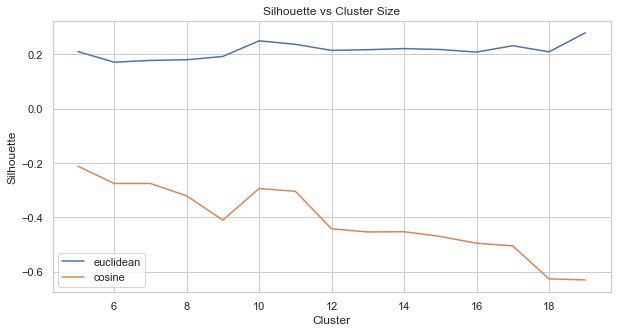

Wall time: 1h 5min 32s


In [37]:
%%time
X1 = df[['discharge_disposition_id','time_in_hospital']]

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','discharge_1','discharge_2','discharge_3','discharge_4','discharge_5','discharge_6',
                'discharge_7','discharge_8','discharge_9','discharge_11','discharge_13','discharge_14','discharge_15',
                'discharge_16','discharge_17','discharge_18','discharge_19','discharge_20','discharge_22',
                'discharge_23','discharge_24','discharge_25','discharge_27','discharge_28',
                'time_in_hospital'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:

    kp = KPrototypes(n_clusters=i, init='Cao', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1, categorical=[0])
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

#### KPrototypes Results for Discharge Disposition and Time in Hospital

17 clusters achieved the highest micro AUC score of 76.49%. This did not beat the LightGBM model with no clustering.

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 76.17% | 0.002 | 0.0012 | 0.0015 | 0.0052 | 0.0015 | 0.2093 | -0.2121 | 
| 6 | 76.17% | 0.0024 | 0.0013 | 0.0017 | 0.0005 | 0.0017 | 0.1703 | -0.2755 | 
| 7 | 76.15% | 0.0026 | 0.0013 | 0.0017 | 0.0016 | 0.0017 | 0.1768 | -0.2755 | 
| 8 | 76.16% | 0.0027 | 0.0013 | 0.0017 | 0.0026 | 0.0016 | 0.1792 | -0.3208 | 
| 9 | 76.14% | 0.0029 | 0.0013 | 0.0018 | 0.0032 | 0.0017 | 0.1914 | -0.4102 | 
| 10 | 76.20% | 0.0041 | 0.0018 | 0.0025 | 0.0044 | 0.0025 | 0.2488 | -0.2941 | 
| 11 | 76.20% | 0.0041 | 0.0017 | 0.0025 | 0.0044 | 0.0023 | 0.2361 | -0.3043 | 
| 12 | 76.29% | 0.0049 | 0.0022 | 0.0031 | 0.0104 | 0.0029 | 0.2136 | -0.4422 | 
| 13 | 76.28% | 0.005 | 0.0022 | 0.0031 | 0.0105 | 0.003 | 0.2161 | -0.4539 | 
| 14 | 76.28% | 0.005 | 0.0022 | 0.003 | 0.0108 | 0.0029 | 0.2203 | -0.4529 | 
| 15 | 76.48% | 0.0084 | 0.0036 | 0.0051 | 0.0104 | 0.0049 | 0.2168 | -0.4703 | 
| **16** | **76.49%** | **0.0085** | **0.0036** | **0.005** | **0.0107** | **0.0049** | **0.2074** | **-0.4952** | 
| 17 | 76.47% | 0.0089 | 0.0037 | 0.0052 | 0.0108 | 0.005 | 0.2309 | -0.5049 | 
| 18 | 76.24% | 0.0047 | 0.0019 | 0.0027 | 0.0087 | 0.0025 | 0.2083 | -0.6261 | 
| 19 | 76.33% | 0.0059 | 0.0024 | 0.0034 | 0.0103 | 0.0032 | 0.2781 | -0.6302 | 

#### Discharge Disposition and Number of Diagnoses

Clusters 5 AUC Score Micro= 0.7616679699703648
Homogeneity:  0.00890484631714561
Completeness:  0.006192886509667906
V-measure:  0.007305295869347568
Adjusted Rand Index:  -0.0035968115234675333
Adjusted Mutual Information:  0.007247670690132044
Silhouette Coefficient - Euclidean:  0.1717828619738056
Silhouette Coefficient - Cosine:  -0.2993155933513264
Clusters 6 AUC Score Micro= 0.761617399395562
Homogeneity:  0.009197840541794263
Completeness:  0.005644638743772782
V-measure:  0.006995931890131309
Adjusted Rand Index:  -0.002469148399201597
Adjusted Mutual Information:  0.006929124597891742
Silhouette Coefficient - Euclidean:  0.11189675272135177
Silhouette Coefficient - Cosine:  -0.3878171447635762
Clusters 7 AUC Score Micro= 0.7627766934642347
Homogeneity:  0.009773307930869486
Completeness:  0.006066785430263954
V-measure:  0.007486390491354965
Adjusted Rand Index:  0.0003926975507319802
Adjusted Mutual Information:  0.0074054869021683315
Silhouette Coefficient - Euclidean:  0.35

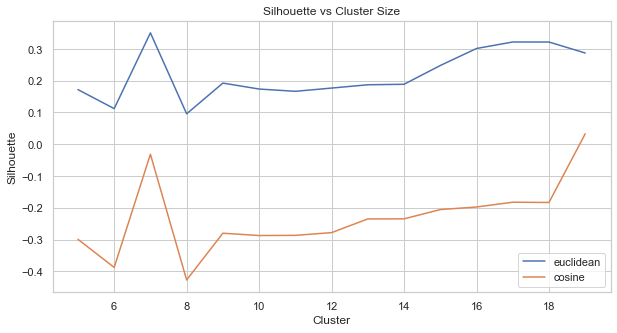

Wall time: 58min 53s


In [39]:
%%time
X1 = df[['discharge_disposition_id','number_diagnoses']]

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','discharge_1','discharge_2','discharge_3','discharge_4','discharge_5','discharge_6',
                'discharge_7','discharge_8','discharge_9','discharge_11','discharge_13','discharge_14','discharge_15',
                'discharge_16','discharge_17','discharge_18','discharge_19','discharge_20','discharge_22',
                'discharge_23','discharge_24','discharge_25','discharge_27','discharge_28',
                'number_diagnoses'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:

    kp = KPrototypes(n_clusters=i, init='Cao', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1, categorical=[0])
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

#### KPrototypes Results for Discharge Disposition and Number of Diagnoses

17 clusters achieved the highest micro AUC score of 76.512%. This did not beat the LightGBM model with no clustering.

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 76.17% | 0.0089 | 0.0062 | 0.0073 | -0.0036 | 0.0072 | 0.1718 | -0.2993 | 
| 6 | 76.16% | 0.0092 | 0.0056 | 0.007 | -0.0025 | 0.0069 | 0.1119 | -0.3878 | 
| 7 | 76.28% | 0.0098 | 0.0061 | 0.0075 | 0.0004 | 0.0074 | 0.3503 | -0.0317 | 
| 8 | 76.26% | 0.0106 | 0.0064 | 0.008 | -0.0025 | 0.0079 | 0.0955 | -0.4272 | 
| 9 | 76.28% | 0.0097 | 0.0053 | 0.0069 | 0.0015 | 0.0068 | 0.1922 | -0.2802 | 
| 10 | 76.30% | 0.01 | 0.0054 | 0.007 | 0.0015 | 0.0069 | 0.1735 | -0.2874 | 
| 11 | 76.30% | 0.01 | 0.0054 | 0.007 | 0.0015 | 0.0069 | 0.1663 | -0.287 | 
| 12 | 76.38% | 0.0121 | 0.0065 | 0.0084 | 0.0011 | 0.0083 | 0.1766 | -0.2783 | 
| 13 | 76.47% | 0.0136 | 0.0068 | 0.0091 | 0.0065 | 0.0089 | 0.187 | -0.2352 | 
| 14 | 76.50% | 0.0137 | 0.0068 | 0.0091 | 0.0065 | 0.0089 | 0.1885 | -0.235 | 
| 15 | 76.48% | 0.0137 | 0.0067 | 0.009 | 0.0066 | 0.0088 | 0.2475 | -0.2058 | 
| 16 | 76.48% | 0.0138 | 0.0065 | 0.0088 | 0.0044 | 0.0086 | 0.3011 | -0.1977 | 
| **17** | **76.512%** | **0.0141** | **0.0065** | **0.0089** | **0.0043** | **0.0087** | **0.3215** | **-0.1826** | 
| 18 | 76.509% | 0.0142 | 0.0065 | 0.0089 | 0.0043 | 0.0088 | 0.3214 | -0.1834 | 
| 19 | 76.50% | 0.0143 | 0.0067 | 0.0091 | 0.0026 | 0.0089 | 0.2869 | 0.0326 | 

#### Payer Code and Number of Medications

Clusters 5 AUC Score Micro= 0.7722932832012146
Homogeneity:  0.004265617371314091
Completeness:  0.002696102937363056
V-measure:  0.003303937249571036
Adjusted Rand Index:  0.0018407463020663646
Adjusted Mutual Information:  0.003249312397041337
Silhouette Coefficient - Euclidean:  0.3194917160535232
Silhouette Coefficient - Cosine:  -0.16452196508761413
Clusters 6 AUC Score Micro= 0.7721553391585739
Homogeneity:  0.004567303436265832
Completeness:  0.0025788266172244497
V-measure:  0.0032964089884231318
Adjusted Rand Index:  0.0007076285536665179
Adjusted Mutual Information:  0.0032327793471076615
Silhouette Coefficient - Euclidean:  0.2902652077400051
Silhouette Coefficient - Cosine:  -0.19896054329639332
Clusters 7 AUC Score Micro= 0.7724254869439185
Homogeneity:  0.004778747666730386
Completeness:  0.0024653749980038174
V-measure:  0.003252679603751146
Adjusted Rand Index:  0.0009379160332392746
Adjusted Mutual Information:  0.0031806626381384786
Silhouette Coefficient - Euclidean:

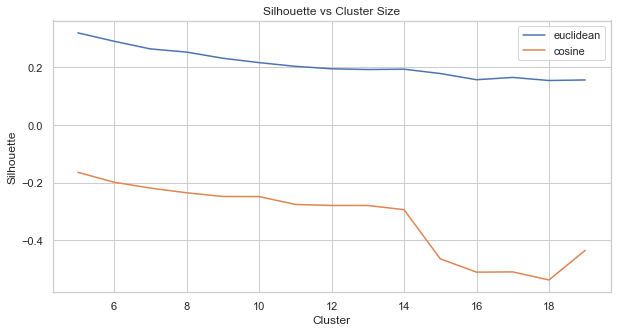

Wall time: 1h 16min 34s


In [40]:
%%time
X1 = df[['payer_code','num_medications']]
cleanup_pc = {"payer_code": {"BC": 0, "CH": 1, "CM": 2, "CP": 3, "DM": 4, "HM": 5, "MC": 6, "MD": 7, "MP":8, "OG": 9,
                         "OT": 10, "PO": 11, "SI": 12, "SP": 13, "UN": 14, "WC": 15}}
X1.replace(cleanup_pc,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','payer_BC','payer_CH','payer_CM','payer_CP','payer_DM','payer_HM','payer_MC',
                'payer_MD','payer_MP','payer_OG','payer_OT','payer_PO','payer_SI','payer_SP','payer_UN','payer_WC',
                'num_medications'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:

    kp = KPrototypes(n_clusters=i, init='Cao', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1, categorical=[0])
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

#### KPrototypes Results for Payer Code and Number of Medications

9 clusters achieved the highest micro AUC score of 76.26%. This did not beat the LightGBM model with no clustering.

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 77.23% | 0.0043 | 0.0027 | 0.0033 | 0.0018 | 0.0032 | 0.3195 | 0.1645 | 
| 6 | 77.22% | 0.0046 | 0.0026 | 0.0033 | 0.0007 | 0.0032 | 0.2903 | -0.199 | 
| 7 | 77.24% | 0.0048 | 0.0026 | 0.0033 | 0.0009 | 0.0032 | 0.2637 | -0.2193 | 
| 8 | 77.24% | 0.0047 | 0.0026 | 0.0031 | 0.0006 | 0.003 | 0.2527 | -0.2356 | 
| **9** | **77.26%** | **0.0049** | **0.0022** | **0.0031** | **0.0016** | **0.003** | **0.2313** | **-0.2484** | 
| 10 | 77.24% | 0.0049 | 0.0021 | 0.003 | 0.0016 | 0.0029 | 0.2162 | -0.2487 | 
| 11 | 77.24% | 0.005 | 0.0021 | 0.0029 | 0.0017 | 0.0028 | 0.2033 | -0.276 | 
| 12 | 77.23% | 0.005 | 0.002 | 0.0028 | 0.0027 | 0.0027 | 0.1948 | -0.2796 | 
| 13 | 77.22% | 0.005 | 0.0019 | 0.0028 | 0.0029 | 0.0027 | 0.1922 | -0.2796 | 
| 14 | 77.22% | 0.0051 | 0.002 | 0.0028 | 0.0048 | 0.0027 | 0.1933 | -0.2942 | 
| 15 | 77.23% | 0.0051 | 0.002 | 0.0028 | 0.0049 | 0.0027 | 0.1783 | -0.4648 | 
| 16 | 77.25% | 0.0052 | 0.002 | 0.0029 | 0.005 | 0.0027 | 0.1569 | -0.511 | 
| 17 | 77.22% | 0.0053 | 0.002 | 0.003 | 0.0046 | 0.0028 | 0.1648 | -0.5102 | 
| 18 | 77.23% | 0.0054 | 0.002 | 0.0029 | 0.005 | 0.0028 | 0.1541 | -0.5381 | 
| 19 | 77.22% | 0.0057 | 0.0019 | 0.0029 | -0.0008 | 0.0027 | 0.156 | -0.4354 | 

#### Payer Code and Diabetes Medication (Yes/No)

Clusters 5 AUC Score Micro= 0.7723930340814872
Homogeneity:  0.0031504403604072236
Completeness:  0.002635621560921661
V-measure:  0.0028701277840386652
Adjusted Rand Index:  -0.010616374687275228
Adjusted Mutual Information:  0.0028058439804262733
Silhouette Coefficient - Euclidean:  -0.11342903115605256
Silhouette Coefficient - Cosine:  -0.5004139787087902
Clusters 6 AUC Score Micro= 0.7722436070605313
Homogeneity:  0.0036345756088409322
Completeness:  0.0027375672339004387
V-measure:  0.003122935358309109
Adjusted Rand Index:  -0.011545898496466835
Adjusted Mutual Information:  0.0030471626714874463
Silhouette Coefficient - Euclidean:  -0.06089247710266093
Silhouette Coefficient - Cosine:  -0.4599215305051002
Clusters 7 AUC Score Micro= 0.7723349883431339
Homogeneity:  0.0043420235387427305
Completeness:  0.0026592886250719643
V-measure:  0.0032984370747102913
Adjusted Rand Index:  -0.006814588505757642
Adjusted Mutual Information:  0.0032180595121732653
Silhouette Coefficient - Euc

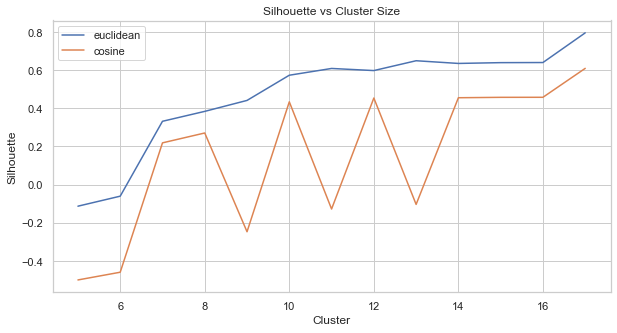

Wall time: 1h 10min 33s


In [44]:
%%time
X1 = df[['payer_code','med_diabetes']]
cleanup_pc = {"payer_code": {"BC": 0, "CH": 1, "CM": 2, "CP": 3, "DM": 4, "HM": 5, "MC": 6, "MD": 7, "MP":8, "OG": 9,
                         "OT": 10, "PO": 11, "SI": 12, "SP": 13, "UN": 14, "WC": 15}}
X1.replace(cleanup_pc,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','race_AfricanAmerican','race_Asian','race_Caucasian','race_Hispanic','race_Other',
                'med_diabetes'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,18)
for i in k:

    kp = KPrototypes(n_clusters=i, init='Cao', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1, categorical=[0])
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

#### KPrototypes Results for Payer Code and Diabetes Medication (Yes/No)

14 clusters achieved the highest micro AUC score of 77.246%. This did not beat the LightGBM model with no clustering.

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 77.24% | 0.0032 | 0.0026 | 0.0029 | -0.0106 | 0.0028 | -0.1134 | -0.5004 | 
| 6 | 77.22% | 0.0036 | 0.0027 | 0.0031 | -0.0115 | 0.003 | -0.0609 | -0.4599 | 
| 7 | 77.23% | 0.0043 | 0.0027 | 0.0033 | -0.0068 | 0.0032 | 0.332 | 0.2188 | 
| 8 | 77.23% | 0.0044 | 0.0025 | 0.0032 | -0.0068 | 0.0031 | 0.384 | 0.2707 | 
| 9 | 77.24% | 0.0038 | 0.0022 | 0.0028 | -0.0064 | 0.0027 | 0.4415 | -0.2475 | 
| 10 | 77.23% | 0.0046 | 0.0024 | 0.0032 | -0.0065 | 0.0037 | 0.5737 | 0.4341 | 
| 11 | 77.245% | 0.0049 | 0.0026 | 0.0034 | -0.0072 | 0.0032 | 0.6092 | -0.1282 | 
| 12 | 77.23% | 0.0045 | 0.0024 | 0.0031 | -0.0063 | 0.003 | 0.5981 | 0.4541 | 
| 13 | 77.22% | 0.0052 | 0.0027 | 0.0035 | -0.0068 | 0.0034 | 0.6497 | -0.1041 | 
| **14** | **77.246%** | **0.005** | **0.0026** | **0.0034** | **-0.0068** | **0.0033** | **0.6355** | **0.4556** | 
| 15 | 77.24% | 0.0051 | 0.0026 | 0.0035 | -0.0067 | 0.0033 | 0.6397 | 0.4577 | 
| 16 | 77.22% | 0.0051 | 0.0026 | 0.0035 | -0.0068 | 0.0033 | 0.6403 | 0.4579 | 
| 17 | 77.22% | 0.0055 | 0.0026 | 0.0035 | -0.0108 | 0.0034 | 0.796 | 0.6097 | 

#### Race, Payer Code and Diabetes Medication (Yes/No)

Clusters 5 AUC Score Micro= 0.7723930340814872
Homogeneity:  0.0031504403604072236
Completeness:  0.002635621560921661
V-measure:  0.0028701277840386652
Adjusted Rand Index:  -0.010616374687275228
Adjusted Mutual Information:  0.0028058439804262733
Silhouette Coefficient - Euclidean:  -0.13294046243700677
Silhouette Coefficient - Cosine:  -0.30582385305097026
Clusters 6 AUC Score Micro= 0.7722436070605313
Homogeneity:  0.0036345756088409322
Completeness:  0.0027375672339004387
V-measure:  0.003122935358309109
Adjusted Rand Index:  -0.011545898496466835
Adjusted Mutual Information:  0.0030471626714874463
Silhouette Coefficient - Euclidean:  -0.09701643855108519
Silhouette Coefficient - Cosine:  -0.2706230898995994
Clusters 7 AUC Score Micro= 0.7723349883431339
Homogeneity:  0.0043420235387427305
Completeness:  0.0026592886250719643
V-measure:  0.0032984370747102913
Adjusted Rand Index:  -0.006814588505757642
Adjusted Mutual Information:  0.0032180595121732653
Silhouette Coefficient - Eu

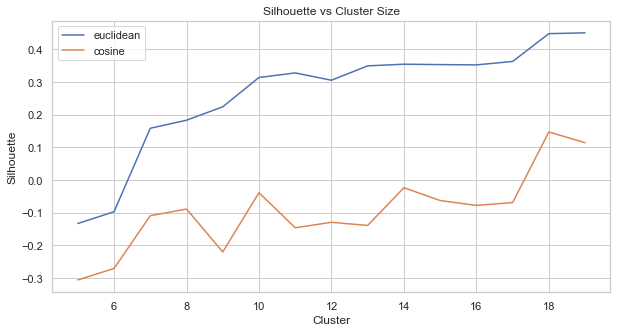

Wall time: 51min 26s


In [43]:
%%time
X1 = df[['race','payer_code','med_diabetes']]
cleanup_race = {"race": {"AfricanAmerican": 0, "Asian": 1, "Caucasian": 2, "Hispanic": 3, "Other": 4}}
X1.replace(cleanup_race,inplace=True)
cleanup_pc = {"payer_code": {"BC": 0, "CH": 1, "CM": 2, "CP": 3, "DM": 4, "HM": 5, "MC": 6, "MD": 7, "MP":8, "OG": 9,
                         "OT": 10, "PO": 11, "SI": 12, "SP": 13, "UN": 14, "WC": 15}}
X1.replace(cleanup_pc,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','race_AfricanAmerican','race_Asian','race_Caucasian','race_Hispanic','race_Other',
                'med_diabetes'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:

    kp = KPrototypes(n_clusters=i, init='Cao', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1, categorical=[0,1])
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

#### KPrototypes Results for Race, Payer Code and Diabetes Medication (Yes/No)

18 clusters achieved the highest micro AUC score of 77.27%. This has the same micro AUC as the LightGBM model with no clustering.

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 77.24% | 0.0032 | 0.0026 | 0.0029 | -0.0106 | 0.0028 | -0.133 | -0.3058 | 
| 6 | 77.22% | 0.0036 | 0.0028 | 0.0031 | -0.0115 | 0.003 | -0.097 | -0.2706 | 
| 7 | 77.23% | 0.0043 | 0.0027 | 0.0033 | -0.0068 | 0.0032 | 0.1586 | -0.1092 | 
| 8 | 77.23% | 0.0044 | 0.0025 | 0.0032 | -0.0068 | 0.0031 | 0.1832 | -0.0888 | 
| 9 | 77.24% | 0.0038 | 0.0022 | 0.0028 | -0.0064 | 0.0027 | 0.2243 | -0.22 | 
| 10 | 77.23% | 0.0046 | 0.0024 | 0.0032 | -0.0065 | 0.0031 | 0.315 | -0.0387 | 
| 11 | 77.25% | 0.0049 | 0.0026 | 0.0034 | -0.0072 | 0.0032 | 0.328 | -0.1461 | 
| 12 | 77.23% | 0.0045 | 0.0024 | 0.0031 | -0.0063 | 0.003 | 0.3056 | -0.1293 | 
| 13 | 77.22% | 0.0052 | 0.0027 | 0.0035 | -0.0069 | 0.0034 | 0.3496 | -0.139 | 
| 14 | 77.23% | 0.0051 | 0.0025 | 0.0034 | -0.008 | 0.0032 | 0.3547 | -0.0235 | 
| 15 | 77.24% | 0.0052 | 0.0026 | 0.0034 | -0.008 | 0.0033 | 0.3535 | -0.0626 | 
| 16 | 77.23% | 0.0052 | 0.0026 | 0.0034 | -0.008 | 0.0033 | 0.3526 | -0.0776 | 
| 17 | 77.24% | 0.0052 | 0.0026 | 0.0034 | -0.0087 | 0.0032 | 0.363 | -0.069 | 
| **18** | **77.27%** | **0.0054** | **0.0024** | **0.0033** | **-0.0059** | **0.0032** | **0.4482** | **0.1482** | 
| 19 | 77.25% | 0.0054 | 0.0024 | 0.0033 | -0.0057 | 0.0031 | 0.4507 | 0.1143 | 

### Agglomerative Clustering

In this section, we explore using the hierarchical agglomerative clustering (HAC) algorithm, which is a "bottom up" algorithm.  In other words, it will begin at the bottom of a data tree at the leaf nodes and work it's way up to encompassing the entire tree.   In this algorithm, individual data points are defined as clusters to start.  After calculating dissimilarities between points, new clusters are formed of those points which are least dissimilar.  The process continues until all of the data points are part of a single, final cluster.

Dissimilarities are calculated using a linkage.  Ward linkage, for instance, uses an ANOVA method that minimizes variance at each step.  Complete linkage, calculates the similarity of the pair that is the farthest away, and average linkage calculates similarity between the mean of a group of data points.

We clustered on scatters that compared medication changes to diabetes medication, the time in hospital versus the number of diagnoses, the number of lab procedures against the total number of medical procedures, and three dimensions with the number of outpatient visits, number of emergency room visit, and number of inpatient visits.

For each of these clusters, we computed the HAC tree using ward, complete, and average linkage for various target sizes of clusters, which ranged from 5 clusters to 20 clusters.  

#### Medication Change  and Diabetes Medication (Yes/No)

These variables are not inherently numeric, but have been transformed to numeric. First we plot the 2 variables to show possible clusters. Then we run agglomerative clustering to find the highest micro AUC score.

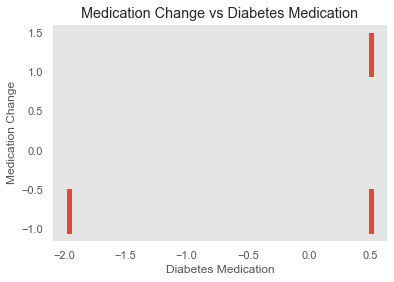

In [113]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X1 = df_imputed[['med_change','med_diabetes']].values
X1 = scl.fit_transform(X1)

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('Diabetes Medication'), plt.ylabel('Medication Change')
plt.grid()
plt.title('Medication Change vs Diabetes Medication')
plt.show()

Computing 5 clusters using ward linkage...
Clusters 5 AUC Score Micro= 0.715418460543975
Homogeneity:  0.0054190742862652115
Completeness:  0.005477880838393763
V-measure:  0.005448318884490877
Adjusted Rand Index:  -0.004848931385589807
Adjusted Mutual Information:  0.005326063808903624
Silhouette Coefficient - Euclidean:  0.06712507068972942
Silhouette Coefficient - Cosine:  0.07105862874698829
Computing 6 clusters using ward linkage...
Clusters 6 AUC Score Micro= 0.7154702662297443
Homogeneity:  0.005482839417772426
Completeness:  0.0047546928362780586
V-measure:  0.0050928713395420495
Adjusted Rand Index:  -0.0064113701758928285
Adjusted Mutual Information:  0.0049526070964129015
Silhouette Coefficient - Euclidean:  0.06244746177944582
Silhouette Coefficient - Cosine:  0.07800139373513928
Computing 7 clusters using ward linkage...
Clusters 7 AUC Score Micro= 0.7154268172700762
Homogeneity:  0.006284329177070659
Completeness:  0.005106953407806718
V-measure:  0.005634795918279937
Ad

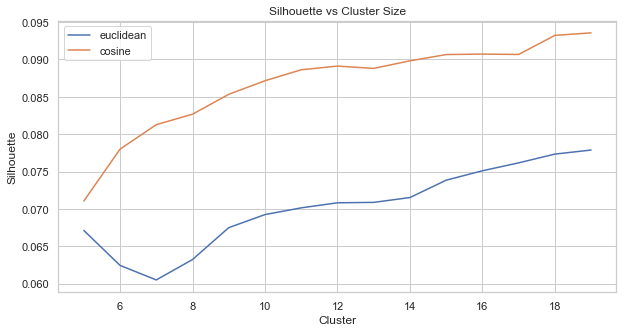

Computing 5 clusters using complete linkage...
Clusters 5 AUC Score Micro= 0.7154873862556294
Homogeneity:  9.275384666430661e-05
Completeness:  0.05611758391502632
V-measure:  0.0001852015832281011
Adjusted Rand Index:  -0.00010571026765413136
Adjusted Mutual Information:  -4.612089781372887e-05
Silhouette Coefficient - Euclidean:  0.9313642940003094
Silhouette Coefficient - Cosine:  0.0015377913186985625
Computing 6 clusters using complete linkage...
Clusters 6 AUC Score Micro= 0.7154873862556294
Homogeneity:  0.00012986042691960292
Completeness:  0.05672112770383779
V-measure:  0.00025912759306980795
Adjusted Rand Index:  -0.00014797510639104737
Adjusted Mutual Information:  -3.6314734379491244e-05
Silhouette Coefficient - Euclidean:  0.9252475904508705
Silhouette Coefficient - Cosine:  0.0007358717149582477
Computing 7 clusters using complete linkage...
Clusters 7 AUC Score Micro= 0.7154873862556294
Homogeneity:  0.00016696988877677838
Completeness:  0.057063101358646326
V-measure:

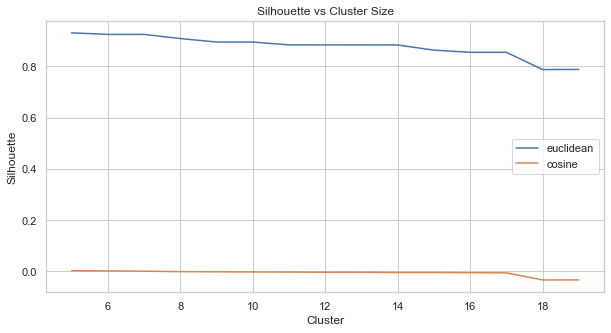

Computing 5 clusters using average linkage...
Clusters 5 AUC Score Micro= 0.7154873862556294
Homogeneity:  9.275384666430661e-05
Completeness:  0.05611758391502632
V-measure:  0.0001852015832281011
Adjusted Rand Index:  -0.00010571026765413136
Adjusted Mutual Information:  -4.612089781372887e-05
Silhouette Coefficient - Euclidean:  0.9313642940003094
Silhouette Coefficient - Cosine:  0.0015377913186985625
Computing 6 clusters using average linkage...
Clusters 6 AUC Score Micro= 0.7154873862556294
Homogeneity:  0.00012986042691960292
Completeness:  0.05672112770383779
V-measure:  0.00025912759306980795
Adjusted Rand Index:  -0.00014797510639104737
Adjusted Mutual Information:  -3.6314734379491244e-05
Silhouette Coefficient - Euclidean:  0.9252475904508705
Silhouette Coefficient - Cosine:  0.0007358717149582477
Computing 7 clusters using average linkage...
Clusters 7 AUC Score Micro= 0.7154873862556294
Homogeneity:  0.00016696988877677838
Completeness:  0.057063101358646326
V-measure:  0

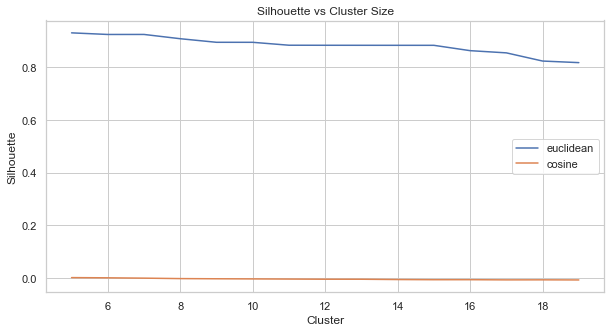

Wall time: 2h 22min 7s


In [124]:
%%time 
df_agglom0 = df_imputed.copy()
df_agglom = pd.DataFrame.sample(df_agglom0, frac = .6, random_state = 34128)

X1 = df_agglom[['med_change','med_diabetes']]
y = df_agglom['readmitted'].values

df_agglom.drop(['readmitted','med_change','med_diabetes'], axis=1, inplace=True)

X = df_agglom.values

scl = StandardScaler()
X = scl.fit_transform(X)
X1 = scl.fit_transform(X)

k = range(5,20)
for link in ['ward', 'complete', 'average']:
    seuclid = []
    scosine = []
    for i in k:

        # append on the clustering
        cls = AgglomerativeClustering(n_clusters=i, linkage=link)
        cls.fit(X1)
        newfeature = cls.labels_ # the labels from kmeans clustering

        X2 = np.column_stack((X,pd.get_dummies(newfeature)))

        lgb_model(X2,y)
        print("Computing", i, "clusters using", link, "linkage...")  
        cluster_metrics(y_lb, yhat_score, X1, newfeature)

    silhouette_plot(k,seuclid,scosine)

#### Agglomerative Results for Medication Change  and Diabetes Medication (Yes/No)

Ward linkage with 13 clusters achieved the highest micro AUC score of 71.57%. This did not beat the LightGBM model with no clustering.

##### Ward Linkage

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 71.54% | 0.0054 | 0.0055 | 0.0054 | -0.0048 | 0.0053 | 0.0671 | 0.0711 | 
| 6 | 71.55% | 0.0055 | 0.0048 | 0.0051 | -0.0064 | 0.005 | 0.0624 | 0.078 | 
| 7 | 71.54% | 0.0063 | 0.0051 | 0.0056 | -0.0087 | 0.0055 | 0.0605 | 0.0813 | 
| 8 | 71.54% | 0.0073 | 0.0057 | 0.0064 | -0.0096 | 0.0062 | 0.0632 | 0.0827 | 
| 9 | 71.53% | 0.0078 | 0.0061 | 0.0068 | -0.0096 | 0.0066 | 0.0675 | 0.0853 | 
| 10 | 71.54% | 0.008 | 0.0061 | 0.0069 | -0.0092 | 0.0067 | 0.0692 | 0.0871 | 
| 11 | 71.56% | 0.0083 | 0.0063 | 0.0071 | -0.0096 | 0.0069 | 0.0701 | 0.0886 | 
| 12 | 71.55% | 0.0083 | 0.0063 | 0.0071 | -0.0094 | 0.0069 | 0.0708 | 0.0891 | 
| **13** | **71.57%** | **0.0086** | **0.0065** | **0.0074** | **-0.0095** | **0.0071** | **0.0709** | **0.0888** | 
| 14 | 71.55% | 0.0086 | 0.0065 | 0.0074 | -0.0095 | 0.0071 | 0.0715 | 0.0898 | 
| 15 | 71.54% | 0.0087 | 0.0065 | 0.0075 | -0.9955 | 0.0071 | 0.0738 | 0.0907 | 
| 16 | 71.56% | 0.0088 | 0.0066 | 0.0075 | -0.0095 | 0.0071 | 0.0751 | 0.0907 | 
| 17 | 71.55% | 0.0088 | 0.0066 | 0.0075 | -0.0095 | 0.0071 | 0.0762 | 0.0907 | 
| 18 | 71.54% | 0.009 | 0.0066 | 0.0076 | -0.0098 | 0.0072 | 0.0773 | 0.0932 | 
| 19 | 71.55% | 0.0091 | 0.0067 | 0.0077 | -0.0697 | 0.0072 | 0.0779 | 0.0936 | 

##### Complete Linkage

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 71.55% | 0.0001 | 0.0561 | 0.0002 | -0.0001 | -0.0001 | 0.9314 | 0.0015 | 
| 6 | 71.55% | 0.0001 | 0.0567 | 0.0003 | -0.0001 | 0 | 0.9252 | 0.0007 | 
| 7 | 71.55% | 0.0002 | 0.0571 | 0.0003 | -0.0002 | 0 | 0.9253 | -0.0005 | 
| 8 | 71.55% | 0.0002 | 0.0579 | 0.0004 | -0.0003 | 0 | 0.9091 | -0.0023 | 
| 9 | 71.55% | 0.0002 | 0.0474 | 0.0005 | -0.0003 | 0 | 0.8955 | -0.0029 | 
| 10 | 71.55% | 0.0003 | 0.0502 | 0.0006 | -0.0004 | 0.0001 | 0.8954 | -0.0035 | 
| 11 | 71.53% | 0.0003 | 0.0417 | 0.0006 | -0.0003 | 0 | 0.8843 | -0.004 | 
| 12 | 71.55% | 0.0003 | 0.0383 | 0.0007 | -0.0004 | 0 | 0.8842 | -0.0046 | 
| 13 | 71.55% | 0.0004 | 0.0419 | 0.0009 | -0.0005 | 0.0001 | 0.8841 | -0.0047 | 
| 14 | 71.55% | 0.0005 | 0.0403 | 0.0009 | -0.0004 | 0.0001 | 0.884 | -0.0058 | 
| 15 | 71.55% | 0.0006 | 0.0439 | 0.0012 | -0.0003 | 0.0003 | 0.8637 | -0.0058 | 
| **16** | **71.56%** | **0.0006** | **0.0391** | **0.0012** | **-0.0002** | **0.0003** | **0.8554** | **-0.0065** | 
| 17 | 71.56% | 0.0006 | 0.039 | 0.0012 | -0.0002 | 0.0002 | 0.8553 | -0.0071 | 
| 18 | 71.54% | 0.0007 | 0.0388 | 0.0013 | -0.0002 | 0.0002 | 0.7875 | -0.0347 | 
| 19 | 71.53% | 0.0008 | 0.037 | 0.0015 | 0.0001 | 0.0004 | 0.7884 | -0.0346 | 

##### Average Linkage

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 71.55% | 0.0001 | 0.0561 | 0.0002 | -0.0001 | -0.0001 | 0.9314 | 0.0015 | 
| 6 | 71.55% | 0.0001 | 0.0567 | 0.00026 | -0.0001 | 0 | 0.9252 | 0.0007 | 
| 7 | 71.55% | 0.0002 | 0.0571 | 0.0003 | -0.0002 | 0 | 0.9253 | -0.0005 | 
| 8 | 71.55% | 0.0002 | 0.0579 | 0.0004 | -0.0003 | 0 | 0.9091 | -0.0023 | 
| 9 | 71.55% | 0.0002 | 0.0474 | 0.0005 | -0.0003 | 0 | 0.8955 | -0.0029 | 
| 10 | 71.55% | 0.0003 | 0.0502 | 0.0006 | -0.0004 | 0.0001 | 0.8954 | -0.0035 | 
| 11 | 71.53% | 0.0003 | 0.0417 | 0.0006 | -0.0003 | 0 | 0.8844 | -0.004 | 
| 12 | 71.55% | 0.0003 | 0.0383 | 0.0007 | -0.0004 | 0 | 0.8842 | -0.0046 | 
| 13 | 71.55% | 0.0004 | 0.0419 | 0.0009 | -0.0005 | 0.0001 | 0.8841 | -0.0047 | 
| 14 | 71.55% | 0.0005 | 0.0403 | 0.0009 | -0.0004 | 0.0001 | 0.884 | -0.0058 | 
| 15 | 71.55% | 0.0005 | 0.0402 | 0.0009 | -0.0004 | 0.0001 | 0.884 | -0.0065 | 
| 16 | 71.55% | 0.0006 | 0.0439 | 0.0012 | -0.0003 | 0.0003 | 0.8637 | -0.0064 | 
| **17** | **71.56%** | **0.0006** | **0.039** | **0.0012** | **-0.0002** | **0.0002** | **0.8553** | **-0.0071** | 
| 18 | 71.54% | 0.0007 | 0.037 | 0.0014 | 0 | 0.0003 | 0.8243 | -0.0069 | 
| 19 | 71.54% | 0.001 | 0.0421 | 0.0019 | -0.0002 | 0.0007 | 0.8182 | -0.0074 | 

#### Time in Hospital and Number of Diagnoses

The variables are inherently numeric. From the plot of the variables below there are a few possible clusters, essentially separating out the number of diagnoses between -2 and 1 (this variable has been normalized) as having longer time in the hospital. Then we run agglomerative clustering to find the highest micro AUC score.

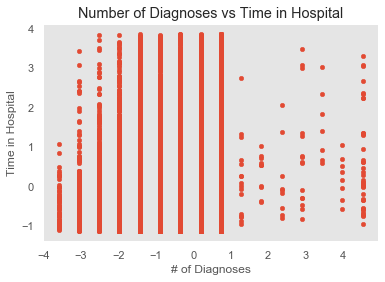

In [114]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X1 = df_imputed[['time_in_hospital','number_diagnoses']].values
X1 = scl.fit_transform(X1)

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('# of Diagnoses'), plt.ylabel('Time in Hospital')
plt.grid()
plt.title('Number of Diagnoses vs Time in Hospital')
plt.show()

Computing 5 clusters using ward linkage...
Clusters 5 AUC Score Micro= 0.7151609673295183
Homogeneity:  0.004006109878108782
Completeness:  0.004046478801034177
V-measure:  0.0040261931516179465
Adjusted Rand Index:  -0.005509099046406004
Adjusted Mutual Information:  0.003903809928723545
Silhouette Coefficient - Euclidean:  0.05313497210400319
Silhouette Coefficient - Cosine:  0.06628502024136328
Computing 6 clusters using ward linkage...
Clusters 6 AUC Score Micro= 0.7153525490179411
Homogeneity:  0.005135495782156179
Completeness:  0.004794022744583947
V-measure:  0.004958887687871473
Adjusted Rand Index:  -0.0072222870382569184
Adjusted Mutual Information:  0.0048130257907802055
Silhouette Coefficient - Euclidean:  0.05258901081039375
Silhouette Coefficient - Cosine:  0.06883979493680394
Computing 7 clusters using ward linkage...
Clusters 7 AUC Score Micro= 0.7153400503049616
Homogeneity:  0.005193656731579394
Completeness:  0.00472219288815947
V-measure:  0.004946716584443654
Adju

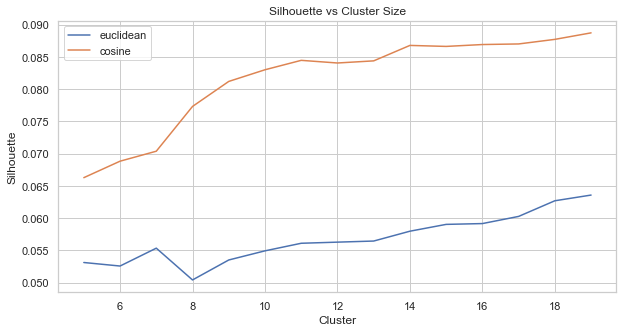

Computing 5 clusters using complete linkage...
Clusters 5 AUC Score Micro= 0.7153373711998533
Homogeneity:  9.275384666430661e-05
Completeness:  0.05611758391502632
V-measure:  0.0001852015832281011
Adjusted Rand Index:  -0.00010571026765413136
Adjusted Mutual Information:  -4.612089781372887e-05
Silhouette Coefficient - Euclidean:  0.9313048485616156
Silhouette Coefficient - Cosine:  0.0008408891338695972
Computing 6 clusters using complete linkage...
Clusters 6 AUC Score Micro= 0.7153373711998533
Homogeneity:  0.00012986042691960292
Completeness:  0.05672112770383779
V-measure:  0.00025912759306980795
Adjusted Rand Index:  -0.00014797510639104737
Adjusted Mutual Information:  -3.6314734379491244e-05
Silhouette Coefficient - Euclidean:  0.9251808780273768
Silhouette Coefficient - Cosine:  0.00020908971674595762
Computing 7 clusters using complete linkage...
Clusters 7 AUC Score Micro= 0.7153373711998533
Homogeneity:  0.00016696988877677838
Completeness:  0.057063101358646326
V-measure

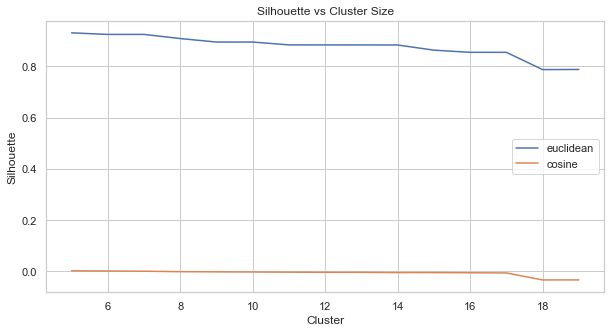

Computing 5 clusters using average linkage...
Clusters 5 AUC Score Micro= 0.7153373711998533
Homogeneity:  9.275384666430661e-05
Completeness:  0.05611758391502632
V-measure:  0.0001852015832281011
Adjusted Rand Index:  -0.00010571026765413136
Adjusted Mutual Information:  -4.612089781372887e-05
Silhouette Coefficient - Euclidean:  0.9313048485616156
Silhouette Coefficient - Cosine:  0.0008408891338695972
Computing 6 clusters using average linkage...
Clusters 6 AUC Score Micro= 0.7153373711998533
Homogeneity:  0.00012986042691960292
Completeness:  0.05672112770383779
V-measure:  0.00025912759306980795
Adjusted Rand Index:  -0.00014797510639104737
Adjusted Mutual Information:  -3.6314734379491244e-05
Silhouette Coefficient - Euclidean:  0.9251808780273768
Silhouette Coefficient - Cosine:  0.00020908971674595762
Computing 7 clusters using average linkage...
Clusters 7 AUC Score Micro= 0.7153373711998533
Homogeneity:  0.00016696988877677838
Completeness:  0.057063101358646326
V-measure:  

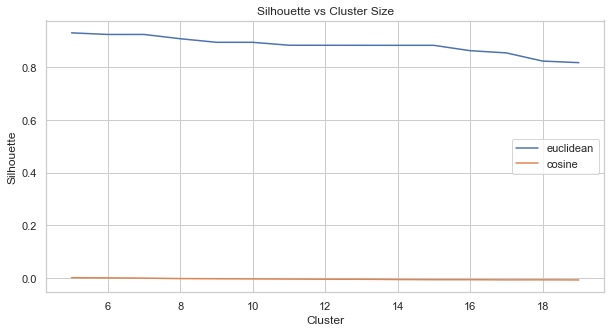

Wall time: 2h 45min 10s


In [125]:
%%time 
df_agglom0 = df_imputed.copy()
df_agglom = pd.DataFrame.sample(df_agglom0, frac = .6, random_state = 34128)

X1 = df_agglom[['time_in_hospital','number_diagnoses']]
y = df_agglom['readmitted'].values

df_agglom.drop(['readmitted','time_in_hospital','number_diagnoses'], axis=1, inplace=True)

X = df_agglom.values

scl = StandardScaler()
X = scl.fit_transform(X)
X1 = scl.fit_transform(X)

k = range(5,20)
for link in ['ward', 'complete', 'average']:
    seuclid = []
    scosine = []
    for i in k:

        # append on the clustering
        cls = AgglomerativeClustering(n_clusters=i, linkage=link)
        cls.fit(X1)
        newfeature = cls.labels_ # the labels from kmeans clustering

        X2 = np.column_stack((X,pd.get_dummies(newfeature)))

        lgb_model(X2,y)
        print("Computing", i, "clusters using", link, "linkage...")  
        cluster_metrics(y_lb, yhat_score, X1, newfeature)

    silhouette_plot(k,seuclid,scosine)

#### Agglomerative Results for Time in Hospital and Number of Diagnoses

Average linkage with 19 clusters achieved the highest micro AUC score of 71.55%. This did not beat the LightGBM model with no clustering. This is the same micro AUC that ward linkage achieved with 8 clusters, but the euclidean silhouette score was higher for average linkage.

##### Ward Linkage

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 71.52% | 0.004 | 0.004 | 0.004 | -0.0055 | 0.0039 | 0.0531 | 0.0663 | 
| 6 | 71.54% | 0.0051 | 0.0048 | 0.005 | -0.0072 | 0.0048 | 0.0526 | 0.0688 | 
| 7 | 71.53% | 0.0052 | 0.0047 | 0.0049 | -0.0074 | 0.0048 | 0.0554 | 0.0704 | 
| **8** | **71.55%** | **0.0053** | **0.0042** | **0.0047** | **-0.0077** | **0.0045** | **0.0504** | **0.0773** | 
| 9 | 71.52% | 0.0067 | 0.0052 | 0.0059 | -0.0087 | 0.0056 | 0.0535 | 0.0812 | 
| 10 | 71.52% | 0.0068 | 0.0052 | 0.0059 | -0.0083 | 0.0057 | 0.0549 | 0.083 | 
| 11 | 71.53% | 0.0071 | 0.0054 | 0.0062 | -0.0087 | 0.0059 | 0.0561 | 0.0845 | 
| 12 | 71.50% | 0.0074 | 0.0056 | 0.0064 | -0.009 | 0.0061 | 0.0563 | 0.0841 | 
| 13 | 71.52% | 0.0075 | 0.0057 | 0.0065 | -0.0087 | 0.0062 | 0.0565 | 0.0844 | 
| 14 | 71.51% | 0.0077 | 0.0058 | 0.0066 | -0.0089 | 0.0063 | 0.058 | 0.0868 | 
| 15 | 71.52% | 0.0078 | 0.0058 | 0.0063 | -0.0089 | 0.0063 | 0.059 | 0.0866 | 
| 16 | 71.52% | 0.0078 | 0.0058 | 0.0067 | -0.0088 | 0.0063 | 0.0592 | 0.0869 | 
| 17 | 71.52% | 0.0079 | 0.0058 | 0.0067 | -0.0088 | 0.0063 | 0.0603 | 0.087 | 
| 18 | 71.52% | 0.0081 | 0.006 | 0.0069 | -0.0088 | 0.0064 | 0.0627 | 0.0877 | 
| 19 | 71.51% | 0.0081 | 0.006 | 0.0069 | -0.0088 | 0.0064 | 0.0635 | 0.0887 | 

##### Complete Linkage

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 71.53% | 0.0001 | 0.0561 | 0.0002 | -0.0001 | 0.0001 | 0.9313 | 0.0008 | 
| 6 | 71.53% | 0.0001 | 0.0567 | 0.0003 | -0.0001 | 0 | 0.9252 | 0.0002 | 
| 7 | 71.53% | 0.0002 | 0.0571 | 0.0003 | -0.0002 | 0 | 0.9252 | -0.0007 | 
| 8 | 71.53% | 0.0002 | 0.079 | 0.0004 | -0.0002 | 0 | 0.909 | -0.0025 | 
| 9 | 71.53% | 0.0002 | 0.0474 | 0.0005 | -0.0003 | 0 | 0.8954 | -0.0032 | 
| 10 | 71.537% | 0.0003 | 0.0502 | 0.0006 | -0.0004 | 0 | 0.8953 | -0.0038 | 
| **11** | **71.541%** | **0.0003** | **0.042** | **0.0006** | **-0.0003** | **0** | **0.8842** | **-0.0044** | 
| 12 | 71.539% | 0.0003 | 0.0383 | 0.0007 | -0.0004 | 0 | 0.8841 | -0.005 | 
| 13 | 71.52% | 0.0004 | 0.0419 | 0.0009 | -0.0005 | 0.0001 | 0.884 | -0.005 | 
| 14 | 71.53% | 0.0005 | 0.0403 | 0.0009 | -0.0004 | 0.0001 | 0.8839 | -0.006 | 
| 15 | 71.52% | 0.0006 | 0.0439 | 0.0012 | -0.0003 | 0.0003 | 0.8636 | -0.0061 | 
| 16 | 71.52% | 0.0006 | 0.0391 | 0.0012 | -0.0002 | 0.0003 | 0.8551 | -0.0068 | 
| 17 | 71.52% | 0.0006 | 0.039 | 0.0012 | -0.0002 | 0.0002 | 0.81 | -0.0074 | 
| 18 | 71.53% | 0.0007 | 0.0388 | 0.0013 | -0.0002 | 0.0002 | 0.7877 | -0.0348 | 
| 19 | 71.538% | 0.0008 | 0.037 | 0.0015 | 0.0001 | 0.0004 | 0.7882 | -0.0346 | 

##### Average Linkage

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 71.53% | 0.0001 | 0.0561 | 0.0002 | -0.0001 | -0.0001 | 0.9313 | 0.0008 | 
| 6 | 71.53% | 0.0001 | 0.0567 | 0.0003 | -0.0001 | 0 | 0.9252 | 0.0002 | 
| 7 | 71.53% | 0.0002 | 0.0571 | 0.0003 | -0.0002 | 0 | 0.9252 | -0.0007 | 
| 8 | 71.53% | 0.0002 | 0.0579 | 0.0004 | -0.0003 | 0 | 0.909 | -0.0025 | 
| 9 | 71.53% | 0.0002 | 0.0474 | 0.0005 | -0.0003 | 0 | 0.8954 | -0.0032 | 
| 10 | 71.54% | 0.0003 | 0.0503 | 0.0006 | -0.0004 | 0.0001 | 0.8953 | -0.0038 | 
| 11 | 71.54% | 0.0003 | 0.0417 | 0.0006 | -0.0003 | 0 | 0.8842 | -0.0044 | 
| 12 | 71.54% | 0.0003 | 0.0383 | 0.0007 | -0.0004 | 0 | 0.8841 | -0.005 | 
| 13 | 71.52% | 0.0004 | 0.0419 | 0.0009 | -0.0005 | 0.0001 | 0.884 | -0.0051 | 
| 14 | 71.53% | 0.0005 | 0.0403 | 0.0009 | -0.0004 | 0.0001 | 0.8839 | -0.0061 | 
| 15 | 71.53% | 0.0005 | 0.0402 | 0.0009 | -0.0004 | 0.0001 | 0.8839 | -0.0068 | 
| 16 | 71.52% | 0.0006 | 0.0438 | 0.0012 | -0.0003 | 0.0003 | 0.8636 | -0.0067 | 
| 17 | 71.52% | 0.0006 | 0.039 | 0.0012 | -0.0002 | 0.0002 | 0.8551 | -0.0073 | 
| 18 | 71.53% | 0.0007 | 0.037 | 0.0014 | 0 | 0.0003 | 0.8241 | -0.0072 | 
| **19** | **71.55%** | **0.001** | **0.0421** | **0.0019** | **-0.0002** | **0.0007** | **0.8181** | **-0.0077** | 

#### Number of Lab Procedures and Number of Procedures

The variables are inherently numeric. From the plot of the variables below there do not appear to be any obvious clusters. We expected to see an increase in one leading to an increase in the other. We will still attempt to cluster here to see what happens.

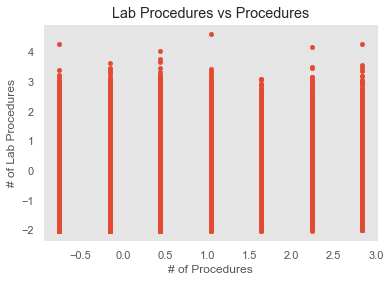

In [115]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X1 = df_imputed[['num_lab_procedures','num_procedures']].values
X1 = scl.fit_transform(X1)

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('# of Procedures'), plt.ylabel('# of Lab Procedures')
plt.grid()
plt.title('Lab Procedures vs Procedures')
plt.show()

Computing 5 clusters using ward linkage...
Clusters 5 AUC Score Micro= 0.7153937790310836
Homogeneity:  0.0032403694508079776
Completeness:  0.003040930851725618
V-measure:  0.0031374839473847856
Adjusted Rand Index:  -0.006294438105833798
Adjusted Mutual Information:  0.003019490910794699
Silhouette Coefficient - Euclidean:  0.06011684233092076
Silhouette Coefficient - Cosine:  0.07512547316666236
Computing 6 clusters using ward linkage...
Clusters 6 AUC Score Micro= 0.7153293326253534
Homogeneity:  0.0033762849284475786
Completeness:  0.002786277142812958
V-measure:  0.0030530371670019186
Adjusted Rand Index:  -0.006977805736275336
Adjusted Mutual Information:  0.0029162248505953388
Silhouette Coefficient - Euclidean:  0.05716677114993025
Silhouette Coefficient - Cosine:  0.08160742664887866
Computing 7 clusters using ward linkage...
Clusters 7 AUC Score Micro= 0.7155258820397713
Homogeneity:  0.004307870966148574
Completeness:  0.0033152986744523633
V-measure:  0.003746966046175602


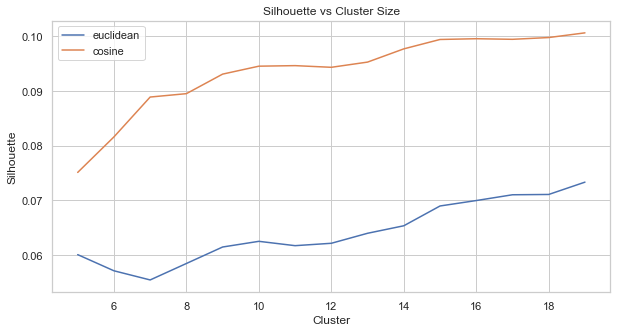

Computing 5 clusters using complete linkage...
Clusters 5 AUC Score Micro= 0.7156029074658773
Homogeneity:  9.275384666430661e-05
Completeness:  0.05611758391502632
V-measure:  0.0001852015832281011
Adjusted Rand Index:  -0.00010571026765413136
Adjusted Mutual Information:  -4.612089781372887e-05
Silhouette Coefficient - Euclidean:  0.9313257322144943
Silhouette Coefficient - Cosine:  0.001075476296967458
Computing 6 clusters using complete linkage...
Clusters 6 AUC Score Micro= 0.7156029074658773
Homogeneity:  0.00012986042691960292
Completeness:  0.05672112770383779
V-measure:  0.00025912759306980795
Adjusted Rand Index:  -0.00014797510639104737
Adjusted Mutual Information:  -3.6314734379491244e-05
Silhouette Coefficient - Euclidean:  0.9251969698821246
Silhouette Coefficient - Cosine:  -0.0002356615149470576
Computing 7 clusters using complete linkage...
Clusters 7 AUC Score Micro= 0.7156029074658773
Homogeneity:  0.00016696988877677838
Completeness:  0.057063101358646326
V-measure:

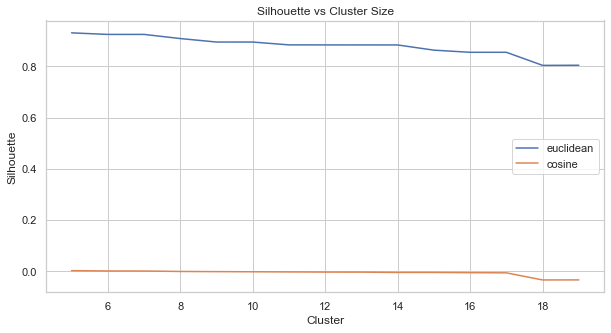

Computing 5 clusters using average linkage...
Clusters 5 AUC Score Micro= 0.7156029074658773
Homogeneity:  9.275384666430661e-05
Completeness:  0.05611758391502632
V-measure:  0.0001852015832281011
Adjusted Rand Index:  -0.00010571026765413136
Adjusted Mutual Information:  -4.612089781372887e-05
Silhouette Coefficient - Euclidean:  0.9313257322144943
Silhouette Coefficient - Cosine:  0.001075476296967458
Computing 6 clusters using average linkage...
Clusters 6 AUC Score Micro= 0.7156029074658773
Homogeneity:  0.00012986042691960292
Completeness:  0.05672112770383779
V-measure:  0.00025912759306980795
Adjusted Rand Index:  -0.00014797510639104737
Adjusted Mutual Information:  -3.6314734379491244e-05
Silhouette Coefficient - Euclidean:  0.9251969698821246
Silhouette Coefficient - Cosine:  -0.0002356615149470576
Computing 7 clusters using average linkage...
Clusters 7 AUC Score Micro= 0.7156029074658773
Homogeneity:  0.00016696988877677838
Completeness:  0.057063101358646326
V-measure:  0

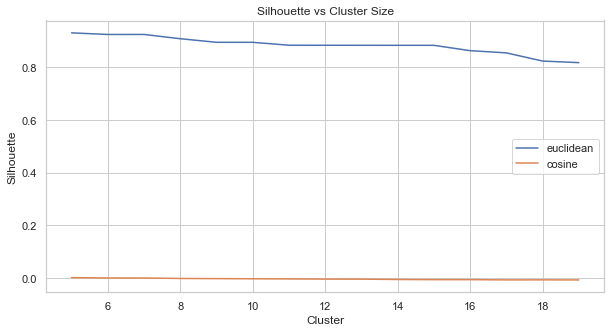

Wall time: 2h 40min 43s


In [126]:
%%time 
df_agglom0 = df_imputed.copy()
df_agglom = pd.DataFrame.sample(df_agglom0, frac = .6, random_state = 34128)

X1 = df_agglom[['num_lab_procedures','num_procedures']]
y = df_agglom['readmitted'].values

df_agglom.drop(['readmitted','num_lab_procedures','num_procedures'], axis=1, inplace=True)

X = df_agglom.values

scl = StandardScaler()
X = scl.fit_transform(X)
X1 = scl.fit_transform(X)

k = range(5,20)
for link in ['ward', 'complete', 'average']:
    seuclid = []
    scosine = []
    for i in k:

        # append on the clustering
        cls = AgglomerativeClustering(n_clusters=i, linkage=link)
        cls.fit(X1)
        newfeature = cls.labels_ # the labels from kmeans clustering

        X2 = np.column_stack((X,pd.get_dummies(newfeature)))

        lgb_model(X2,y)
        print("Computing", i, "clusters using", link, "linkage...")  
        cluster_metrics(y_lb, yhat_score, X1, newfeature)

    silhouette_plot(k,seuclid,scosine)

#### Agglomerative Results for Number of Lab Procedures and Number of Procedures

Average linkage with 19 clusters achieved the highest micro AUC score of 71.564%. This did not beat the LightGBM model with no clustering. 

##### Ward Linkage

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 71.54% | 0.0032 | 0.003 | 0.0031 | -0.0063 | 0.003 | 0.0601 | 0.0751 | 
| 6 | 71.53% | 0.0034 | 0.0028 | 0.0031 | -0.007 | 0.0029 | 0.0572 | 0.0816 | 
| 7 | 71.55% | 0.0043 | 0.0033 | 0.0037 | -0.0085 | 0.0036 | 0.0555 | 0.0889 | 
| 8 | 71.557% | 0.0043 | 0.0033 | 0.0038 | -0.0087 | 0.0036 | 0.0585 | 0.0895 | 
| 9 | 71.55% | 0.0057 | 0.0042 | 0.0049 | -0.0097 | 0.0047 | 0.0615 | 0.0931 | 
| 10 | 71.556% | 0.0061 | 0.0044 | 0.0051 | -0.01 | 0.0049 | 0.0625 | 0.0945 | 
| 11 | 71.54% | 0.0063 | 0.0046 | 0.0053 | -0.01 | 0.005 | 0.0618 | 0.0946 | 
| 12 | 71.54% | 0.0064 | 0.0047 | 0.0054 | -0.01 | 0.0051 | 0.0622 | 0.0943 | 
| 13 | 71.54% | 0.0066 | 0.0047 | 0.0055 | -0.0101 | 0.0052 | 0.064 | 0.0953 | 
| 14 | 71.55% | 0.0068 | 0.0048 | 0.0057 | -0.0103 | 0.0053 | 0.0654 | 0.0977 | 
| **15** | **71.562%** | **0.007** | **0.005** | **0.0058** | **-0.0102** | **0.0055** | **0.069** | **0.0994** | 
| 16 | 71.55% | 0.007 | 0.005 | 0.0058 | -0.0102 | 0.0055 | 0.07 | 0.0995 | 
| 17 | 71.55% | 0.0071 | 0.005 | 0.0059 | -0.0102 | 0.0055 | 0.071 | 0.0994 | 
| 18 | 71.55% | 0.0072 | 0.0051 | 0.0059 | -0.0101 | 0.0055 | 0.0711 | 0.0998 | 
| 19 | 71.55% | 0.0073 | 0.0052 | 0.0061 | -0.0101 | 0.0056 | 0.0734 | 0.1006 | 

##### Complete Linkage

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 71.560% | 0.0001 | 0.0561 | 0.0002 | -0.0001 | 0.0001 | 0.9313 | 0.0011 | 
| 6 | 71.560% | 0.0001 | 0.0567 | 0.0003 | -0.0001 | 0 | 0.9252 | -0.0002 | 
| 7 | 71.560% | 0.0002 | 0.0571 | 0.0003 | -0.0002 | 0 | 0.9253 | -0.0004 | 
| 8 | 71.560% | 0.0002 | 0.0579 | 0.0004 | -0.0003 | 0 | 0.909 | -0.0021 | 
| 9 | 71.560% | 0.0002 | 0.0474 | 0.0005 | -0.0003 | 0 | 0.8954 | -0.0028 | 
| **10** | **71.561%** | **0.0003** | **0.0502** | **0.0006** | **-0.0004** | **0.0001** | **0.8953** | **-0.0034** | 
| 11 | 71.55% | 0.0003 | 0.0417 | 0.0006 | -0.0003 | 0 | 0.8843 | -0.004 | 
| 12 | 71.559% | 0.0003 | 0.0383 | 0.0007 | -0.0003 | 0 | 0.8841 | -0.0046 | 
| 13 | 71.55% | 0.0004 | 0.0419 | 0.0009 | -0.0005 | 0.0001 | 0.884 | -0.0048 | 
| 14 | 71.55% | 0.0005 | 0.0403 | 0.0009 | -0.0004 | 0.0001 | 0.8839 | -0.006 | 
| 15 | 71.55% | 0.0006 | 0.0439 | 0.0012 | -0.0003 | 0.0003 | 0.8636 | -0.006 | 
| 16 | 71.54% | 0.0006 | 0.0391 | 0.0013 | -0.0002 | 0.0003 | 0.8853 | -0.0069 | 
| 17 | 71.54% | 0.0006 | 0.039 | 0.0012 | -0.0002 | 0.0002 | 0.8552 | -0.0076 | 
| 18 | 71.558% | 0.0007 | 0.0422 | 0.0014 | -0.0002 | 0.0003 | 0.8041 | -0.0354 | 
| 19 | 71.560% | 0.0008 | 0.034 | 0.0016 | 0.0001 | 0.0005 | 0.8046 | -0.0352 | 

##### Average Linkage

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 71.560% | 0.0001 | 0.0561 | 0.0002 | -0.0001 | 0.0001 | 0.9313 | 0.0011 | 
| 6 | 71.560% | 0.0001 | 0.0567 | 0.0003 | -0.0001 | 0 | 0.9252 | -0.0002 | 
| 7 | 71.560% | 0.0002 | 0.0571 | 0.0003 | -0.0002 | 0 | 0.9253 | -0.0004 | 
| 8 | 71.560% | 0.0002 | 0.0579 | 0.0004 | -0.0003 | 0 | 0.909 | -0.0021 | 
| 9 | 71.560% | 0.0002 | 0.0474 | 0.0005 | -0.0003 | 0 | 0.8954 | -0.0028 | 
| 10 | 71.561% | 0.0003 | 0.0502 | 0.0006 | -0.0004 | 0.0001 | 0.8953 | -0.0033 | 
| 11 | 71.55% | 0.0003 | 0.0417 | 0.0006 | -0.0003 | 0 | 0.8843 | -0.004 | 
| 12 | 71.56% | 0.0003 | 0.0383 | 0.0007 | -0.0004 | 0 | 0.8841 | -0.0046 | 
| 13 | 71.55% | 0.0004 | 0.0419 | 0.0009 | -0.0005 | 0.0001 | 0.884 | -0.0048 | 
| 14 | 71.55% | 0.0005 | 0.0403 | 0.0009 | -0.0004 | 0.0001 | 0.8839 | -0.006 | 
| 15 | 71.55% | 0.0005 | 0.0402 | 0.0009 | -0.0004 | 0.0001 | 0.8839 | -0.0067 | 
| 16 | 71.55% | 0.0006 | 0.0438 | 0.0012 | -0.0003 | 0.0003 | 0.8636 | -0.0067 | 
| 17 | 71.54% | 0.0006 | 0.039 | 0.0012 | -0.0002 | 0.0002 | 0.8552 | -0.0076 | 
| 18 | 71.53% | 0.0007 | 0.00037 | 0.0014 | 0 | 0.0003 | 0.8241 | -0.0074 | 
| **19** | **71.564%** | **0.001** | **0.0421** | **0.0019** | **-0.0002** | **0.0007** | **0.8181** | **-0.0078** | 

#### Number of Outpatient Visits, Number of Emergency Visits and Number of Inpatient Visits

The plot below shows some possible clusters, mainly in the outer edges of each axis.

Text(0.5, 0, 'Emergency')

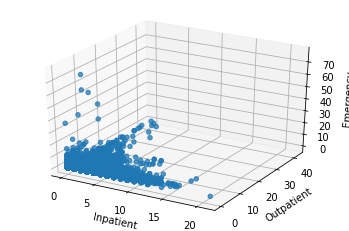

In [51]:
from mpl_toolkits.mplot3d import Axes3D

# initialize figure and 3d projection for the PC3 data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# assign x,y,z coordinates from PC1, PC2 & PC3
#xs = X_pca_3.T[0]
#ys = X_pca_3.T[1]
#zs = X_pca_3.T[2]

# initialize scatter plot and label axes
ax.scatter(df['number_inpatient'], df['number_outpatient'], df['number_emergency'], 
           alpha=0.75, depthshade=True)
ax.set_xlabel('Inpatient')
ax.set_ylabel('Outpatient')
ax.set_zlabel('Emergency')

Computing 5 clusters using ward linkage...
Clusters 5 AUC Score Micro= 0.7238654422253353
Homogeneity:  0.004272892929219049
Completeness:  0.004348056438839171
V-measure:  0.004310147019816202
Adjusted Rand Index:  -0.006443373316703868
Adjusted Mutual Information:  0.004187347803747583
Silhouette Coefficient - Euclidean:  0.06749176473670598
Silhouette Coefficient - Cosine:  0.06762711432294212
Computing 6 clusters using ward linkage...
Clusters 6 AUC Score Micro= 0.7238309443224649
Homogeneity:  0.0043839282246509875
Completeness:  0.0038862053230710476
V-measure:  0.004120089501406609
Adjusted Rand Index:  -0.0074733688388724144
Adjusted Mutual Information:  0.003978031760809168
Silhouette Coefficient - Euclidean:  0.06110409941620103
Silhouette Coefficient - Cosine:  0.07422106637121874
Computing 7 clusters using ward linkage...
Clusters 7 AUC Score Micro= 0.7236983415611297
Homogeneity:  0.005590853003813646
Completeness:  0.004616207819733096
V-measure:  0.005056997269114909
Adj

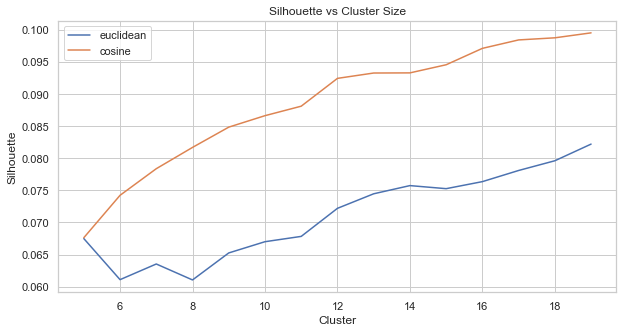

Computing 5 clusters using complete linkage...
Clusters 5 AUC Score Micro= 0.7241992158539026
Homogeneity:  9.275384666430661e-05
Completeness:  0.05611758391502632
V-measure:  0.0001852015832281011
Adjusted Rand Index:  -0.00010571026765413136
Adjusted Mutual Information:  -4.612089781372887e-05
Silhouette Coefficient - Euclidean:  0.9317288961946618
Silhouette Coefficient - Cosine:  0.0007056893174929417
Computing 6 clusters using complete linkage...
Clusters 6 AUC Score Micro= 0.7241992158539026
Homogeneity:  0.00012986042691960292
Completeness:  0.05672112770383779
V-measure:  0.00025912759306980795
Adjusted Rand Index:  -0.00014797510639104737
Adjusted Mutual Information:  -3.6314734379491244e-05
Silhouette Coefficient - Euclidean:  0.9256415955678247
Silhouette Coefficient - Cosine:  -4.5432372747096936e-05
Computing 7 clusters using complete linkage...
Clusters 7 AUC Score Micro= 0.7241992158539026
Homogeneity:  0.00016696988877677838
Completeness:  0.057063101358646326
V-measur

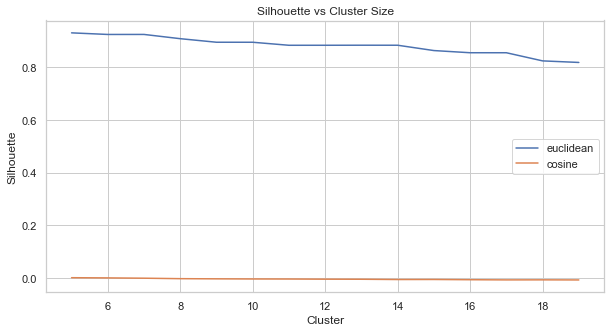

Computing 5 clusters using average linkage...
Clusters 5 AUC Score Micro= 0.7241992158539026
Homogeneity:  9.275384666430661e-05
Completeness:  0.05611758391502632
V-measure:  0.0001852015832281011
Adjusted Rand Index:  -0.00010571026765413136
Adjusted Mutual Information:  -4.612089781372887e-05
Silhouette Coefficient - Euclidean:  0.9317288961946618
Silhouette Coefficient - Cosine:  0.0007056893174929417
Computing 6 clusters using average linkage...
Clusters 6 AUC Score Micro= 0.7241992158539026
Homogeneity:  0.00012986042691960292
Completeness:  0.05672112770383779
V-measure:  0.00025912759306980795
Adjusted Rand Index:  -0.00014797510639104737
Adjusted Mutual Information:  -3.6314734379491244e-05
Silhouette Coefficient - Euclidean:  0.9256415955678247
Silhouette Coefficient - Cosine:  -4.5432372747096936e-05
Computing 7 clusters using average linkage...
Clusters 7 AUC Score Micro= 0.7241992158539026
Homogeneity:  0.00016696988877677838
Completeness:  0.057063101358646326
V-measure: 

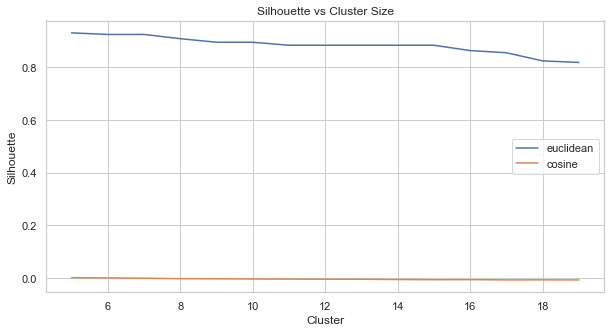

Wall time: 2h 22min 20s


In [127]:
%%time 
df_agglom0 = df_imputed.copy()
df_agglom = pd.DataFrame.sample(df_agglom0, frac = .6, random_state = 34128)

X1 = df_agglom[['number_outpatient','number_emergency','number_inpatient']]
y = df_agglom['readmitted'].values

df_agglom.drop(['readmitted','number_outpatient','number_emergency','number_inpatient'], axis=1, inplace=True)

X = df_agglom.values

scl = StandardScaler()
X = scl.fit_transform(X)
X1 = scl.fit_transform(X)

k = range(5,20)
for link in ['ward', 'complete', 'average']:
    seuclid = []
    scosine = []
    for i in k:

        # append on the clustering
        cls = AgglomerativeClustering(n_clusters=i, linkage=link)
        cls.fit(X1)
        newfeature = cls.labels_ # the labels from kmeans clustering

        X2 = np.column_stack((X,pd.get_dummies(newfeature)))

        lgb_model(X2,y)
        print("Computing", i, "clusters using", link, "linkage...")  
        cluster_metrics(y_lb, yhat_score, X1, newfeature)

    silhouette_plot(k,seuclid,scosine)

#### Agglomerative Results for Number of Outpatient Visits, Number of Emergency Visits and Number of Inpatient Visits

Ward linkage with 5 clusters achieved the highest micro AUC score of 72.87%. This did not beat the LightGBM model with no clustering. 

##### Ward Linkage

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| **5** | **72.87%** | **0.0043** | **0.0043** | **0.0043** | **-0.0064** | **0.0042** | **0.0675** | **0.0676** | 
| 6 | 72.38% | 0.0044 | 0.0039 | 0.0041 | -0.0075 | 0.004 | 0.0611 | 0.0742 | 
| 7 | 72.37% | 0.0056 | 0.0046 | 0.0051 | -0.0092 | 0.0049 | 0.0635 | 0.0784 | 
| 8 | 72.42% | 0.0152 | 0.0112 | 0.0129 | -0.0138 | 0.0127 | 0.0611 | 0.0817 | 
| 9 | 72.39% | 0.0165 | 0.0119 | 0.0138 | -0.014 | 0.0136 | 0.0653 | 0.0848 | 
| 10 | 72.38% | 0.0165 | 0.0119 | 0.0139 | -0.0135 | 0.0136 | 0.067 | 0.0866 | 
| 11 | 72.37% | 0.0168 | 0.012 | 0.014 | -0.0139 | 0.0138 | 0.0678 | 0.0881 | 
| 12 | 72.39% | 0.0168 | 0.0119 | 0.0139 | -0.0143 | 0.0137 | 0.0722 | 0.0924 | 
| 13 | 72.34% | 0.0169 | 0.012 | 0.014 | -0.0143 | 0.0137 | 0.0745 | 0.0932 | 
| 14 | 72.38% | 0.0169 | 0.012 | 0.014 | -0.0143 | 0.0137 | 0.0757 | 0.0933 | 
| 15 | 72.36% | 0.017 | 0.0118 | 0.014 | -0.0144 | 0.0136 | 0.0753 | 0.0945 | 
| 16 | 72.38% | 0.0172 | 0.0119 | 0.014 | -0.0146 | 0.0137 | 0.0763 | 0.0971 | 
| 17 | 72.37% | 0.0172 | 0.0119 | 0.014 | -0.0146 | 0.0138 | 0.0781 | 0.0983 | 
| 18 | 72.37% | 0.0173 | 0.0119 | 0.0141 | -0.0146 | 0.0137 | 0.0976 | 0.0987 | 
| 19 | 72.38% | 0.0175 | 0.012 | 0.0143 | -0.0146 | 0.0138 | 0.0822 | 0.0995 | 

##### Complete Linkage

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 72.42% | 0.0001 | 0.0561 | 0.0002 | -0.0001 | 1 | 0.9317 | 0.0007 | 
| 6 | 72.42% | 0.0001 | 0.0567 | 0.0003 | -0.0001 | 0 | 0.9256 | 0.0001 | 
| 7 | 72.42% | 0.0002 | 0.0571 | 0.0003 | -0.0002 | 0 | 0.9257 | -0.0012 | 
| 8 | 72.42% | 0.0002 | 0.0579 | 0.0004 | -0.0003 | 0 | 0.9096 | -0.003 | 
| 9 | 72.42% | 0.0002 | 0.0474 | 0.0005 | -0.0003 | 0 | 0.896 | -0.0037 | 
| **10** | **72.43%** | **0.0003** | **0.0502** | **0.0006** | **-0.0004** | **0.0001** | **0.896** | **-0.0042** | 
| 11 | 72.39% | 0.0004 | 0.0459 | 0.0008 | -0.0005 | 0.0002 | 0.8845 | -0.004 | 
| 12 | 72.39% | 0.0004 | 0.0479 | 0.0008 | -0.0005 | 0.0002 | 0.8845 | -0.0049 | 
| 13 | 72.40% | 0.0004 | 0.0419 | 0.0009 | -0.0005 | 0.0001 | 0.8847 | -0.0052 | 
| 14 | 72.39% | 0.0005 | 0.0403 | 0.0009 | -0.0004 | 0.0001 | 0.8846 | -0.0063 | 
| 15 | 72.38% | 0.0006 | 0.0439 | 0.0012 | -0.0003 | 0.0003 | 0.8644 | -0.0061 | 
| 16 | 72.38% | 0.0006 | 0.0391 | 0.0012 | -0.0002 | 0.0003 | 0.8561 | -0.007 | 
| 17 | 72.38% | 0.0006 | 0.039 | 0.0012 | -0.0002 | 0.0002 | 0.8561 | -0.0077 | 
| 18 | 72.42% | 0.0007 | 0.037 | 0.0014 | 0 | 0.0003 | 0.8251 | -0.0075 | 
| 19 | 72.38% | 0.001 | 0.0421 | 0.0019 | -0.0002 | 0.0007 | 0.8192 | -0.0078 | 

##### Average Linkage

| Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| 5 | 72.42% | 0.0001 | 0.0561 | 0.0002 | -0.0001 | -0.0001 | 0.9317 | 0.0007 | 
| 6 | 72.42% | 0.0001 | 0.0567 | 0.0003 | -0.0001 | 0 | 0.9256 | -0.0001 | 
| 7 | 72.42% | 0.0002 | 0.0571 | 0.0003 | -0.0002 | 0 | 0.9257 | -0.0012 | 
| 8 | 72.42% | 0.0002 | 0.0579 | 0.0004 | -0.0003 | 0 | 0.9096 | -0.003 | 
| 9 | 72.42% | 0.0002 | 0.0474 | 0.0005 | -0.0002 | 0 | 0.896 | -0.0037 | 
| **10** | **72.43%** | **0.0003** | **0.0502** | **0.0006** | **-0.0004** | **0.0001** | **0.896** | **-0.0042** | 
| 11 | 72.40% | 0.0003 | 0.0448 | 0.0007 | -0.0004 | 0 | 0.8846 | -0.0048 | 
| 12 | 72.39% | 0.0003 | 0.0383 | 0.0007 | -0.0004 | 0 | 0.8843 | -0.005 | 
| 13 | 72.40% | 0.0004 | 0.0419 | 0.0009 | -0.0005 | 0.0001 | 0.8847 | -0.0052 | 
| 14 | 72.39% | 0.0005 | 0.0403 | 0.0009 | -0.0004 | 0.0001 | 0.8846 | -0.0063 | 
| 15 | 72.39% | 0.0005 | 0.0402 | 0.0009 | -0.0004 | 0.0001 | 0.8846 | -0.007 | 
| 16 | 72.38% | 0.0006 | 0.0438 | 0.0012 | -0.0003 | 0.0001 | 0.8846 | -0.007 | 
| 17 | 72.38% | 0.0006 | 0.039 | 0.0012 | -0.0002 | 0.0002 | 0.8561 | -0.0008 | 
| 18 | 72.42% | 0.0007 | 0.037 | 0.0014 | 0 | 0.0003 | 0.8251 | -0.0075 | 
| 19 | 72.38% | 0.001 | 0.0421 | 0.0019 | -0.0002 | 0.0007 | 0.8192 | -0.0078 | 

<a id = 'Section_6'></a>

## 6. Modeling and Evaluation 2
*(10 points)* 

*Evaluate and Compare. Use internal and/or external validation measures to describe and compare the clusterings and the clusters.*

The table below displays the winning clusters from each model:

| Clustered Variables | Model | Cluster Size | Micro AUC | Homogeneity | Completeness | V-Measure | Adjusted Rand Index | Adjusted Mutual Information | Euclidean Silhouette Coefficient | Cosine Silhouette Coefficient |
|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|
| Admission Source and Discharge Disposition | Kmodes | 16 | 77.22% | 0.0243 | 0.0121 | 0.0161 |  | 0.0063 | 0.016 | 0.4732 | 0.13 | 
| Admission Source and Race | KModes | 6 | 77.52% | 0.0059 | 0.005 | 0.0054 |  | -0.002 | 0.0053 | 0.6192 | 0.4981 | 
| Admission Source, Discharge Disposition and Admission Type | KModes | 15 | 77.01% | 0.0195 | 0.0085 | 0.0118 |  | 0.0035 | 0.0117 | 0.4851 | 0.3288 | 
| Admission Source and Payer Code | KModes | 9 | 77.49% | 0.0079 | 0.0044 | 0.0057 |  | -0.0014 | 0.0056 | 0.3442 | 0.1831 | 
| Admission Type and Payer Code | KModes | 13 | 77.35% | 0.0044 | 0.002 | 0.0027 |  | -0.0046 | 0.0026 | 0.3267 | -0.286 | 
| Admission Source, Payer Code and Admission Type | KModes | 17 | 77.47% | 0.0046 | 0.0019 | 0.0026 |  | -0.0043 | 0.0025 | 0.2425 | 0.0225 | 
| Discharge Disposition and Race | KModes | 17 | 77.15% | 0.0196 | 0.0107 | 0.0138 |  | 0.0071 | 0.0136 | 0.8057 | 0.5273 | 
| Payer Code and Number of Procedures | Kprototypes | 8 | 77.31% | 0.0023 | 0.0013 | 0.0016 |  | -0.0043 | 0.0016 | -0.0074 | -0.023 | 
| Discharge Disposition and Time in Hospital | KPrototypes | 16 | 76.49% | 0.0085 | 0.0036 | 0.005 |  | 0.0107 | 0.0049 | 0.2074 | -0.4952 | 
| Discharge Disposition and Number of Diagnoses | Kprototypes | 17 | 76.51% | 0.0141 | 0.0065 | 0.0089 |  | 0.0043 | 0.0087 | 0.3215 | -0.1826 | 
| Payer Code and Number of Medications | Kprototypes | 9 | 77.26% | 0.0049 | 0.0022 | 0.0031 |  | 0.0016 | 0.003 | 0.2313 | -0.2484 | 
| Payer Code and Diabetes Medication | KPrototypes | 14 | 77.25% | 0.005 | 0.0026 | 0.0034 |  | -0.0068 | 0.0033 | 0.6355 | 0.4556 | 
| Race, Payer Code and Diabetes Medication | KPrototypes | 18 | 77.27% | 0.0054 | 0.0024 | 0.0033 |  | -0.0059 | 0.0032 | 0.4482 | 0.1482 | 
| Medication Change and Diabetes Medication | Agglomerative - Ward | 13 | 71.57% | 0.0086 | 0.0065 | 0.0074 |  | -0.0095 | 0.0071 | 0.0709 | 0.0888 | 
| Time in Hospital and Number of Diagnoses | Agglomerative - Average | 19 | 71.55% | 0.001 | 0.0421 | 0.0019 |  | -0.0002 | 0.0007 | 0.8181 | -0.0077 | 
| Number of Lab Procedures and Number of Procedures | Agglomerative - Average | 19 | 71.56% | 0.001 | 0.0421 | 0.0019 |  | -0.0002 | 0.0007 | 0.8181 | -0.0078 | 
| Number of Outpatient, Emergency and Inpatient Visits | Agglomerative - Ward | 5 | 72.87% | 0.0043 | 0.0043 | 0.0043 |  | -0.0064 | 0.0042 | 0.0675 | 0.0676 | 

For our KModes models, all of the AUC results were very similar, within about .5% of each other.  The best combination seemed to be admission source and race with a cluster size of 6, resulting in 77.52% AUC, following very closely by admission source, admission type and payer code (77.47%), and admission source and payer code (77.49%).
 
The best Silhouette coefficients for KModes were all cosine.  Interestingly, the best Silhouette Coefficient, at .8057, was discharge disposition and race.  This is interesting because the AUC for those two was not at the top of the AUCs.  However, the runner-up, with a Silhouette coefficient of .619, was admission source and race with 6 clusters (the best AUC).
 
Turing our attention to KPrototypes, the best AUC was payer code and number of procedures with 8 clusters at 77.31% AUC, and the best Silhouette coefficient was payer code and diabetes medication with 14 clusters at .636, followed by race, payer code and diabetes medication at .448 with 18 clusters, which is not surprising since the latter grouping contains the former.
 
Regarding Hierarchical Agglomerative Clustering (HAC), amongst the cluster sets that we tested, there was remarkably little variation between AUC and the other measures between linkages and parameters.  AUC was in the low 70s across these.
 
For all four HAC clusters, we looked at the Silhouette coefficient as a secondary measure when the top AUC's were virtually the same.  Thus, for medication change and diabetes medication, the best parameters are 19 clusters with Ward linkage (AUC 71.55%, Cosine Silhouette .1).  For time in hospital and number of diagnoses, the best AUC was average linkage with 10 clusters (AUC 72.43%).  For number of lab procedures and number of procedures, the best AUC was Ward linkage with 15 clusters (AUC 71.56%, Cosine Silhouette .099). For number of outpatient, emergency and inpatient visits, the best AUC was average linkage with 5 clusters (AUC 72.87%)
 
Number of emergency, outpatient and inpatient visits resulted in the best HAC clustering results by a very small margin.  On the whole measures within each set of parameter tests were amazingly similar and results between sets were also very similar, which suggests that these variables are correlated, which is similar to what we saw in the heatmap.
 
So, overall across all of the models and parameters tested, the best AUC was KModes on admission source and race with 6 clusters (77.52%), followed by admission source and payer code with 9 KModes clusters (77.49%).  The best overall Silhouette coefficient was with the number of lab procedures and number of all procedures using average agglomerative clustering with 19 clusters with a cosine coefficient of .818, which tied with the time in hospital and number of diagnoses using average agglomerative clustering with 19 clusters with a cosine coefficient of .818.  It was especially interesting to us that the best Silhouette scores occurred with some of the worst AUC scores.
 
These results do make sense if you think about it.  For instance, it makes sense that the source of admission might play a bigger role since that source could be correlated with severity.  For instance, if the source were a nursing home, those patients might likely have longer stays or require more readmissions due to their age versus, say, a source of someone driving a relative to the emergency room.  Certain diagnoses, similarly, would like have longer stays; cancer, for instance, probably requires more readmissions than a broken bone.  Payer code is the same idea since those codes are insurance representations of different diagnoses, so a code associated with something like cancer would naturally predicate more readmissions.

<a id = 'Section_7'></a>

## 7.  Modeling and Evaluation 3
*(10 points)* 

*Visualize Results*

An AUC plot can help us visually evaluate the quality of a classification model (after clustering was performed). A curve above and to the left of the "Luck" like indicates a model that does better than random chance, i.e., a significant model.

We plotted the ROC curve for each class and the ROC curve that aggregates the performance of each curve (micro-average ROC curve). The individual curves let us know how well the model classifies that particular class and the micro-average ROC curve lets us know how the model performs as a whole.

We used the micro-average as it is more appropriate for a dataset with imbalanced classes. The micro average will pool the performance over all samples as opposed to the macro average which will average the performance over the number of members in each class. The micro average AUC is less sensitive to class imbalance.

Per the scikit-learn documentation, "ROC curves are typically used in binary classification to study the output of a classifier. In order to extend ROC curve and ROC area to multi-label classification, it is necessary to binarize the output. One ROC curve can be drawn per label, but one can also draw a ROC curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging)."

We have displayed the micro-averaged ROC curve for the winning models for each classification task along with the ROC curves for each class. The clustering of `admission_source_id` and `race` with 6 clusters gave the highest micro AUC score of 77.52%. This can be broken down by each class: NO readmission has a micro AUC score of 69.3%, <30 days 66.7% and >30 days 64.9%. We would hope the highest micro AUC would be for the classes <30 days and >30 days, but this is not what we found.

In [59]:
%%time
X1 = df[['admission_source_id','race']]
cleanup_race = {"race": {"AfricanAmerican": 0, "Asian": 1, "Caucasian": 2, "Hispanic": 3, "Other": 4}}
X1.replace(cleanup_race,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','admission_source_1','admission_source_2','admission_source_3','admission_source_4',
               'admission_source_5','admission_source_6','admission_source_7','admission_source_8','admission_source_9',
               'admission_source_10','admission_source_11','admission_source_13','admission_source_14',
               'admission_source_17','admission_source_22','admission_source_25',
               'race_AfricanAmerican','race_Asian','race_Caucasian','race_Hispanic','race_Other'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []

i=6
    
kp = KModes(n_clusters=i, init='Huang', n_init=3, verbose=False, random_state=1)
kp.fit_predict(X1)
newfeature = kp.labels_ 

X2 = np.column_stack((X,pd.get_dummies(newfeature)))

lgb_model(X2,y)
cluster_metrics(y_lb, yhat_score, X1, newfeature)

Clusters 6 AUC Score Micro= 0.7752335080884117
Homogeneity:  0.005890122470435238
Completeness:  0.004963798218886645
V-measure:  0.005387431927070271
Adjusted Rand Index:  -0.001988038862705702
Adjusted Mutual Information:  0.005306864931025592
Silhouette Coefficient - Euclidean:  0.6191729431960252
Silhouette Coefficient - Cosine:  0.4980895517348209
Wall time: 5min 19s


In [74]:
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

# code manipulated from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html?highlight=roc

def roc_curve(actuals, predictions):
    # Compute ROC curve for all classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    thresh = dict()
    for i in np.unique(actuals):
        fpr[i], tpr[i], thresh[i] = metrics.roc_curve(actuals, predictions[:, i], pos_label=i)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # Combined ROC over all classes
    one_hot_class_encoding = label_binarize(actuals,np.unique(actuals))
    fpr["micro"], tpr["micro"], thresh["micro"] = metrics.roc_curve(one_hot_class_encoding.ravel(), predictions.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

    n_classes = 3

    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (AUC = {0:0.3f})'
                   ''.format(roc_auc["micro"]),
             color='#7AC74F', linestyle=':', linewidth=4)

    plt.plot(fpr[0], tpr[0], color='#d42920', lw=2,
             label='NO readmission (AUC = {1:0.3f})'
             ''.format(i, roc_auc[i]))

    plt.plot(fpr[1], tpr[1], color='#32312b', lw=2,
             label='<30 days readmission (AUC = {1:0.3f})'
             ''.format(i, roc_auc[i]))

    plt.plot(fpr[2], tpr[2], color='#fac22b', lw=2,
             label='> 30 days readmission (AUC = {1:0.3f})'
             ''.format(i, roc_auc[i]))

    # Plot the "Luck" line
    plt.plot(
            [0, 1], [0, 1],
            linestyle='--',
            lw=2,
            color='black',
            label='Luck',
            alpha=.8)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-average ROC Curve and ROC curves by Class')
    plt.legend(loc="lower right")
    plt.show()

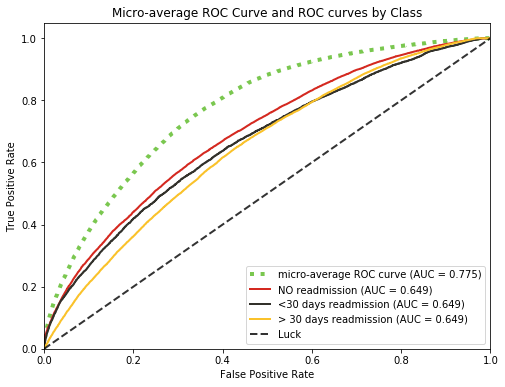

In [75]:
roc_curve(y, yhat_score)

The plot below is a visual representation of the 6 clusters found using KModes for `admission_source_id` and `race`. However, we do not feel that it is really appropriate to visualize these clusters. This would imply an inherent order to the values for each variable. For example, for `admission_source_id` a value of 1 indicates a physician referral and a value of 2 indicates a clinic referral. Plotting the data this way implies that a clinic referral is higher than a physician referral (2 > 1). But, what would that even mean?

What we can glean from this plot is:

* African Americans (0) from all admission sources except physician referral (1) are clustered with Caucasians being admitted from the ER (7). 
* All races except African Americans (0) being transferred from another hospital (4) creates a cluster.
* Asians (1) being admitted from a skilled nursing facility (5), another health care facility (6), the ER (7) and a home health agency (17) create a cluster.
* Other races (4) being admitted from a clinic referral (2), transferring from another health care facility (6), the ER (7) and a home health agency (17) create a cluster.
* Caucasians (2) being admitted from the ER (7) form their own cluster.

What we find especially interesting is how the races are clustered together for different admission sources. Since this cluster does improve the micro AUC score for our model, this information could help hospitals improve care for their patients.

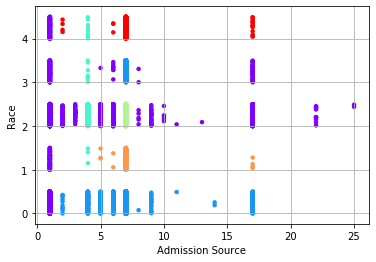

In [71]:
plt.figure()
X1=X1.values
plt.scatter(X1[:, 0], X1[:, 1]+np.random.random(X1[:, 1].shape)/2, c=newfeature, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Admission Source'), plt.ylabel('Race')
plt.grid()

We will not visualize all the clusters that we worked with, but we will plot another one with interesting results: `payer_code` and `num_procedures` from KModes with 8 clusters. 

In [80]:
%%time
X1 = df[['payer_code','num_procedures']]
cleanup_pc = {"payer_code": {"BC": 0, "CH": 1, "CM": 2, "CP": 3, "DM": 4, "HM": 5, "MC": 6, "MD": 7, "MP":8, "OG": 9,
                         "OT": 10, "PO": 11, "SI": 12, "SP": 13, "UN": 14, "WC": 15}}
X1.replace(cleanup_pc,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','payer_BC','payer_CH','payer_CM','payer_CP','payer_DM','payer_HM','payer_MC',
                'payer_MD','payer_MP','payer_OG','payer_OT','payer_PO','payer_SI','payer_SP','payer_UN',
                'payer_WC','num_procedures'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []

i=8
    
kp = KPrototypes(n_clusters=i, init='Cao', n_init=3, verbose=False, random_state=1)
kp.fit_predict(X1, categorical=[0])
newfeature = kp.labels_ 

X2 = np.column_stack((X,pd.get_dummies(newfeature)))

lgb_model(X2,y)
cluster_metrics(y_lb, yhat_score, X1, newfeature)

Clusters 8 AUC Score Micro= 0.7730931662745408
Homogeneity:  0.0023438059114763697
Completeness:  0.0012662273920246566
V-measure:  0.0016441905086152639
Adjusted Rand Index:  -0.00429795737039358
Adjusted Mutual Information:  0.0015574516577041859
Silhouette Coefficient - Euclidean:  -0.007405650196224378
Silhouette Coefficient - Cosine:  -0.0229774630061045
Wall time: 3min 39s


Below we are plotting one categorical variable and one numeric. We still have the same reservations about plotting as before.

Here is what we discover from the plot:

* At 2 procedures and up we see clusters that we would expect. There does not appear to be differences by payer code.
* Payer Code BC (0, possibly Blue Cross Blue Shield?) forms a cluster for 0 and 1 procedures.
* Payer Code CM (2) also forms a cluster for 0 and 1 procedures.
* Payer code HM (5) forms a cluster for 0 procedures.

It would be interesting to see how this relates to different policies that each insurance company has. For example, some insurance companies have stricter requirements about procedures and require approvals.

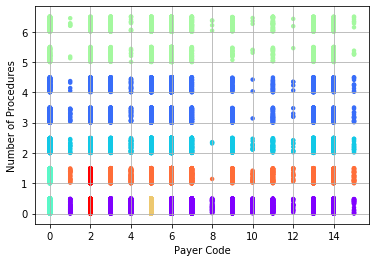

In [81]:
plt.figure()
X1=X1.values
plt.scatter(X1[:, 0], X1[:, 1]+np.random.random(X1[:, 1].shape)/2, c=newfeature, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Payer Code'), plt.ylabel('Number of Procedures')
plt.grid()

<a id = 'Section_8'></a>

## 8. Modeling and Evaluation 4
*(20 points)* 

*Summarize the ramifications. Describe your results. What findings are the most interesting and why?*

The top model clustered admission source and race as factors in classifying patients for readmission with diabetes related causes, with an AUC of 77.52%. As the clustering combination with the highest performance, these factors will be of the most interest to relevant parties looking to influence readmission rates. As diabetes is generally a chronic condition, patients admitted to a health care facility are at particular risk for readmission due to lapses in treatment or other long and short term complications. 

The KModes algorithm used for this model allowed us to cluster categorical variables that other clustering algorithms do not. This better reflects the given dataset that was primarily categorical data. Using other clustering techniques that only allow numeric data would force us to change the encoding of our categorical variables, and impose an ordering that is not inherent in the data.

The LightGBM model without clustering had a micro AUC score of 77.27%. Clustering on admission source and race improved the micro AUC score to 77.52%. Patterns recognized between these 2 variables improves the classification of our model.

In the next 2 paragraphs, we highlight some facts about the variables we clustered to reveal why they are important in classifying readmission. 

The primary admission sources in the data were physician referrals, ER, transfer from another nursing/healthcare facility, and home health agencies. 45% of all the patients in the processed dataset were transferred from an ER, indicating at least some measure of severity and urgency in whatever caused the patient to be hospitalized. It is reasonable that the source of a patient’s admission would be a strong factor in that patient’s readmission status, as more complex health issues can influence ease of treatment, recovery time, and other factors that affect readmission. While diabetic patients admitted to an emergency room make up only [12%](https://www.cdc.gov/nchs/fastats/diabetes.htm) of the total as of 2016, the dataset only records that diabetes was involved in the diagnoses of these patients, not that it was the primary cause of hospitalization. As a result, someone admitted to a hospital through the ER, all other factors being equal, will likely have more serious and complicated health issues than someone admitted through a physician referral. We can conclude that the admission source of a patient is a viable indicator for classifying the readmission status of that patient. 

The next patient attribute might seem a curious attribute to base a cluster on, as physiological differences between people of different ethnicities are fairly minor. People of African descent do have higher rates of [sickle cell anemia](https://www.who.int/genomics/public/Maphaemoglobin.pdf?ua=1), Caucasians and certain European people are more at risk to [cystic fibrosis](https://www.who.int/genomics/publications/en/HGN_WB_04.02_fig2.pdf?ua=1), and Asians tend to be lactose intolerant. Although ethnic differences in [diabetes diagnoses](https://www.diabetes.org/resources/statistics/statistics-about-diabetes) do exist, findings grouped by self identified ethnicity are both broad and too generalized to adequately group similar genetic phenotypes. More likely then is that race here serves as an associative shorthand for the correlated exposures that are common to people in that group. In the United States, a person’s race often correlates with [household income](https://www.census.gov/content/dam/Census/library/visualizations/2018/demo/p60-263/figure1.pdf), which can have profound effects on the totality of a person’s life, including their health. Socioeconomic status can affect factors such as proximity to food deserts, education, and nutritional habits, which can then directly influence a person’s vulnerability to diabetes. Another significant factor can be a person’s access to a physician, especially when the lack of regular care results in long term undiagnosed diabetes complicating other health issues that can lead to an ER visit. In some cases ethnically derived culinary predilections, geography, or other cultural values can also meaningfully contribute to instances of poor health as seen in high obesity and diabetes rates in [pacific islander communities](https://www.who.int/bulletin/volumes/88/7/10-010710/en/). Although not from physical differences between ethnic groups, it is plausible the correlated exposures associated with members of the same ethnic group can influence both the health, conditions of hospital admittance, and recovery of a patient.

What isn't obvious without clustering is how these variables interact with each other. Here are some observations noted from the clusters found from this model:

* African Americans (0) from all admission sources except physician referral (1) are clustered with Caucasians being admitted from the ER (7). 
* All races except African Americans (0) being transferred from another hospital (4) creates a cluster.
* Asians (1) being admitted from a skilled nursing facility (5), another health care facility (6), the ER (7) and a home health agency (17) create a cluster.
* Other races (4) being admitted from a clinic referral (2), transferring from another health care facility (6), the ER (7) and a home health agency (17) create a cluster.
* Caucasians (2) being admitted from the ER (7) form their own cluster.

The fact that clustering admission source and race leads to improved classification for readmission opens avenues for research to identify why this is the case. Is it the case that certain insurance companies make it too expensive for customers to obtain treatments until it's an emergency? Or are there society wide problems inherent in the way the healthcare systems treat patients of different ethnicities? Although payer code was not included in this model, we wonder how much effect it has on admission source. Further research into this is needed.

<a id = 'Section_5'></a>

## 9. Deployment

*(10 points)*

*Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?*
* *How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?*
* *How would you deploy your model for interested parties?*
* *What other data should be collected?*
* *How often would the model need to be updated, etc.?*

The focus of this project was on clustering, not classification. Since we switched datasets from the previous project we do not have a 'best' classification model to score with. We chose LightGBM because of its speed and how well it did classifying our previous dataset. However, it should not be assumed that LightGBM would perform the best in this instance. We simply did not have the time to test different classification models and perform parameter tuning.

We would expect random chance to be able to correctly classify whether someone will be readmitted and for how long at least 33.33% of the time (with target values of 'No', '<30 days' and '> 30 days). Our model significantly outperforms random chance. The LightGBM model without clustering had a 77.27% micro AUC score. Ideally, we would like this number to be as high as possible. 

The [American Diabetes Association](https://www.diabetes.org/resources/statistics/statistics-about-diabetes) stated that in 2018:
* 34.2 million Americans (10.5% of the population) had diabetes. 
* 7.3 million people of the 34.2 million are undiagnosed. 
* 26.8% of seniors have diabetes.
* 88 million Americans had prediabetes. 
* A staggering 1.5 million people are diagnosed every year. 
* Diabetes is the 7th leading cause of death in the United States. 
* The prevalence of diabetes is increasing as seen in this figure from the [2020 National Diabetes Statistice Report](https://www.cdc.gov/diabetes/pdfs/data/statistics/national-diabetes-statistics-report.pdf). 

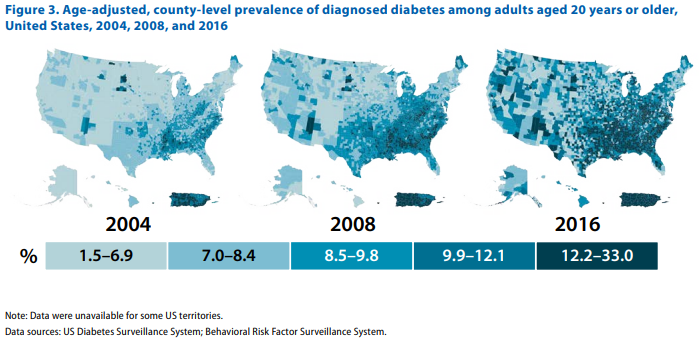

These facts highlight why this model could be useful. Being able to profile patients that have a higher chance of being readmitted could lead to different treatments or closer follow-up with the patient's doctor. Sharing this information directly with the patient could also have profound effects and possibly encourage lifestyle changes that might prevent readmission. Patient education is always a good idea, but perhaps additional education or more in-depth education could be provided to the patients who are classified by the model as being readmitted in <30 days or >30 days. Maybe there are different treatments that could be provided to the patients who are classified as being readmitted in <30 days. A production version of this model does not need to be run daily, or probably even weekly. Updating the model monthly should be sufficient to capture and identify new trends. Updating the model monthly also lines up with the cutoff for the target values of a patient being readmitted: <30 days, >30 days. 

We do feel that there is a significant amount of data missing that we imagine would be extremely useful for this classification problem. 
* `max_glu_serum` is missing in 94.75% of the observations. Blood glucose levels can identify what kind of diabetic emergency the patient is undergoing, and to what degree. 
* The type of diabetes the patient has may also provide insight into whether the patient will be readmitted and for how long. 
* The dataset does provide information about what type of diabetic medication the patient is on and whether the dosage changes, but it does not provide the dosages. Do higher or lower dosages help in classifying whether the patient will be readmitted and for how long? 
* How long has the patient been under the care of a doctor for diabetes? If the patient has only recently found out he/she is diabetic, does this increase their chance of being readmitted? Or is there any evidence to suggest that people who have been under a doctor's care for diabetes for a long period of time become complacent, which might increase their chance of being readmitted? 
* There are probably a myriad of other factors that could be examined, but we will end with one more: a flag indicating if this model was used to make any changes in treatment, follow-up or patient education. It is difficult to know how long it would take for this data to trickle in and be meaningful in the model, but it could help indicate which change, if any, had an impact on patient readmission.

Another interesting aspect to look at in this dataset is the history of hospital admissions by patient. The dataset does have multiple records for some patients who have multiple hospital admissions. This would be especially useful if more information about the patient's stay in the hospital was included. We imagine it would be possible to identify progressions in a patient's diabetes over time. This could help highlight patients whose medication may not be working or patients whose diabetes is in general not under control (not just one episode but a history of episodes).

Even though the micro AUC score was only 77.27%, this model can be used to improve patient lives and outcomes. As such, we do believe we achieved our goal in modeling. However, modeling should continue to see what improvements can be made. Small improvements can lead to fewer hospitals visits and, potentially, saved lives.

<a id = 'Section_6'></a>

## 10. Exceptional Work

*(10 points)*

*You have free reign to provide additional analyses or combine analyses.*

* Models not covered in class: KModes and KPrototypes (see earlier sections).
* MCA (below).
* DBSCAN with PCA (below).

#### Multiple Correspondence Analysis (MCA)

*Note: None of were able to get R working from Python. The MCA section was done in R and an R file has been included with submission of this project. Screen shots of the results are provided below.*

One of the issues with applying distance based clustering to this dataset was the preponderance of categorical data. Using the FactoMineR library in R, multiple correspondence analysis was used in an attempt to reduce the dataset to 5 continuous components that could be used to reach interpretable distance based conclusions. The total variance explained by the MCA procedure falls well below the recommended minimum.

![Variable Representation](mca2.png)

Looking at the plotted squared correlation between variables along MCA dimensions, most of the meaningful variables are only very weakly associated with dimension 1 and 2. 

![Variable Scree Plot](mca3.png)

Several clustering methods were tried on the MCA components, using dimension 1 as the target variable with dimensions 2:5 as the predictors.  

Random Forest Clustering

![Random Forest Predictions](rfc1.png)
![Random Forest AUC](rfc2.png)

Partitioning Around Medoids Clustering

![PAM Predictions](pamc1.png)
![PAM AUC](pamc2.png)

KMeans Clustering
![KMeans Predictions](kc1.png)
![KMeans AUC](kc2.png)

|AUC Score for MCA Dimension 1 Clustering | Method |
| --- | ---  |
| 0.50393351800554 | Random Forest |
| 0.48299168975069 | Partitioning Around Medoids |
| 0.504487534626039 | KMeans |

It is possible that poor in both the multiple correspondence analysis and subsequent dimension clustering are due to the nature of the data; that there really isn't that much separation between the various factors present in this particular dataset. However due to the better results of the other clustering methods used above, it is more likely that some part of the analysis was incorrectly executed. Nominal use cases for multiple correspondence analysis is mixed categorical and continuous datasets, such as this dataset on diabetic patients and theur readmission status. While we can say that race, number of procedures, gender, and readmission as MCA components were close to each other, the attributable variance is so low that no meaningful conclusions can be drawn. 


#### DBSCAN with PCA

Density estimation tends to become quite difficult above 4-5 dimensions, therefore, we will try to reduce the number of dimensions using principal component analysis (PCA). We will consider only numerical features, i.e., features that are either continuous or whose categories have ordered values. 

PCA is a linear transformation that chooses a new coordinate system for the dataset, and it is better suited for continuous variables. We will not consider categorical variables for PCA as they may not be in an ordered relationship even though they are represented numerically. If we apply PCA to categorical variables, we are, in effect, asking the PCA tool to find a numerical relationship between variables where one may not exist.
 
Below we create a dataframe with only continuous or ordered features.

In [28]:
# Make copy of dataset
df_dbscan = df_imputed.copy()

# Include age_num as an ordered numerical feature
df_dbscan['age_num'] = df_dbscan['age_num'].astype('int')

# Extract features and labels
y = df_dbscan['readmitted']
df_dbscan.drop(['readmitted'], axis=1, inplace=True)
X = df_dbscan

# Standardize variables
X = (X - X.mean())/X.std()

In [29]:
# Create a dataframe with only continuous or ordered features
good_data = X[['age_num',
               'time_in_hospital',
               'num_lab_procedures',
               'num_procedures',
               'num_medications',
               'number_outpatient',
               'number_emergency',
               'number_inpatient',
               'number_diagnoses']]

In [30]:
# Code adapted from Udacity customer segments project
# Available from: https://github.com/udacity/machine-learning/blob/master/projects/customer_segments/visuals.py

def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
    components.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Var'])
    variance_ratios.index = dimensions
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))
    
    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)
    
    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Var\n          %.4f"%(ev))
        
    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

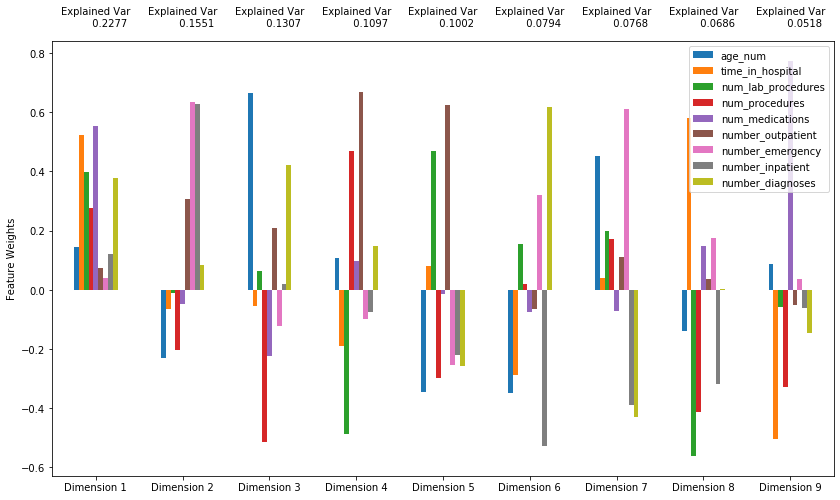

In [52]:
from sklearn.decomposition import PCA

# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components = 9).fit(good_data)

# Generate PCA results plot
pca_results = pca_results(good_data, pca)

From the plot above we can see that the first 3 principal components, or dimensions, explain more than 50% of the variation in the data and can be interpreted as follows:

- **Dimension 1**: mostly represents the variation in the number of distinct medications administered, time in hospital, and number of lab tests performed.
- **Dimension 2**: reduces the impact of distinct medications administered, time in hospital, and number of lab tests performed and mostly represents variation in the number of emergency and inpatient visits in the previous year.  
- **Dimension 3**: mostly represents the variation in the patient's age group, the number of procedures other than labs tests that were performed, and the number of diagnoses entered into the system. The positive direction in the age group indicates an older age group and the negative direction in the number of procedures indicates a lower value or fewer procedures.

In [34]:
pd.options.display.max_rows = 100
print(pca_results['Explained Var'].cumsum())

Dimension 1    0.2277
Dimension 2    0.3828
Dimension 3    0.5135
Dimension 4    0.6232
Dimension 5    0.7234
Dimension 6    0.8028
Dimension 7    0.8796
Dimension 8    0.9482
Dimension 9    1.0000
Name: Explained Var, dtype: float64


Approximately 87.96% of the variance is explained by the first 7 principal components. These 7 dimensions account for most of the variance in the data and identify seven groups with similar characteristics.

We fit and transformed both models.

In [35]:
pca_3 = PCA(n_components=3) # PCA with 3 primary components
pca_7 = PCA(n_components=7) #PCA with 7 primary components

# fit and transform both PCA models
X_pca_3 = pca_3.fit_transform(good_data)
X_pca_7 = pca_7.fit_transform(good_data)

Given that 3 principal components explain 51% of the total variance, it makes sense to look at a three-dimensional plot of the top 3 loadings (or eigenvalues). We used matplotlib's mpl_toolkits to create a projection for this subspace.

Text(0.5, 0, 'PC3')

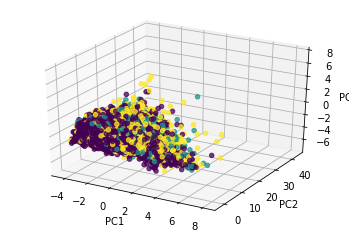

In [38]:
from mpl_toolkits.mplot3d import Axes3D

# initialize figure and 3d projection for the PC3 data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# assign x,y,z coordinates from PC1, PC2 & PC3
xs = X_pca_3.T[0]
ys = X_pca_3.T[1]
zs = X_pca_3.T[2]

# initialize scatter plot and label axes
ax.scatter(xs, ys, zs, alpha=0.75, c=df['readmitted'], cmap='viridis', depthshade=True)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

In the plot above we can see patients who have no record of readmission in purple,  patients that were readmitted in less than 30 days represented by the blue points, patients that were readmitted in more than 30 days represented in yellow. We can see that more of the yellow points tend be higher on PC3, however, it is still difficult to see any clear pattern.

#### DBSCAN

DBSCAN , first introduced in 1996 by [Ester et al](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf), is a density-based clustering algorithm that identifies arbitrarily-shaped clusters as continuous regions of high density. The algorithm achieves this by counting all instances that are a distance $\varepsilon$ from it, referred to as the instance's $\varepsilon$-neighborhood. If an instance has at least a minimum number of samples, `min_samples`, in its $\varepsilon$-neighborhood, then it is considered a core instance (i.e., core instances are those located in dense regions).

The plots below assist in identifying the optimal number of `min_samples` for the algorithm to consider. The flatter the line in the plot, the better. For both 3 and 7 principal components, 5 `min_samples` gives the flattest line.

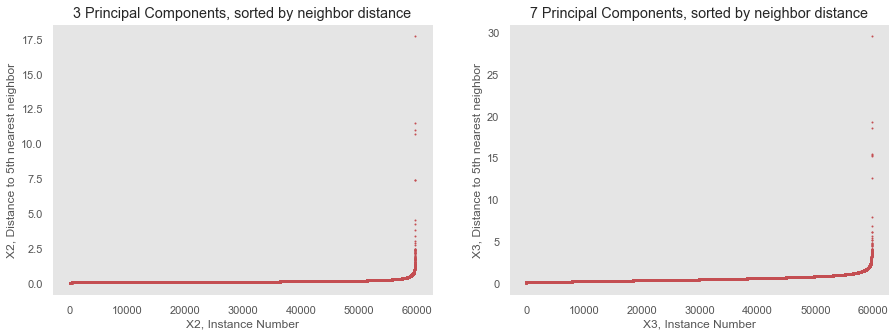

In [129]:
# lets first look at the connectivity of the graphs and distance to the nearest neighbors
from sklearn.neighbors import kneighbors_graph

#=======================================================
# CHANGE THESE VALUES TO ADJUST MINPTS FOR EACH DATASET
X2_N = 5
X3_N = 5
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X2_knn_graph = kneighbors_graph(X_pca_3, X2_N, mode='distance') # calculate distance to four nearest neighbors 
X3_knn_graph = kneighbors_graph(X_pca_7, X3_N, mode='distance') # calculate distance to four nearest neighbors 

N2 = X2_knn_graph.shape[0]
X2_4nn_distances = np.zeros((N2,1))
for i in range(N2):
    X2_4nn_distances[i] = X2_knn_graph[i,:].max()

X2_4nn_distances = np.sort(X2_4nn_distances, axis=0)

N3 = X3_knn_graph.shape[0]
X3_4nn_distances = np.zeros((N3,1))
for i in range(N2):
    X3_4nn_distances[i] = X3_knn_graph[i,:].max()

X3_4nn_distances = np.sort(X3_4nn_distances, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N2), X2_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('3 Principal Components, sorted by neighbor distance')
plt.xlabel('X2, Instance Number')
plt.ylabel('X2, Distance to {0}th nearest neighbor'.format(X2_N))
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(N3), X3_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('7 Principal Components, sorted by neighbor distance')
plt.xlabel('X3, Instance Number')
plt.ylabel('X3, Distance to {0}th nearest neighbor'.format(X3_N))
plt.grid()

plt.show()

Next, we run DBSCAN for the first 3 principal components with several values of minpts and eps to see which will give us the best accuracy. We chose to run through several values of minpts because the plots above were very similar for the range of values we tested. Visual inspection lead us to believe 5 was the ideal value, but running several will be more conclusive.

In [54]:
%%time 

df_dbscan0 = df_imputed.copy()

X1 = X_pca_3
y = df_dbscan0['readmitted'].values
df_dbscan0.drop(['readmitted',
                    'age_num',
                    'IsMale',
                    'time_in_hospital',
                    'num_lab_procedures',
                    'num_procedures',
                    'num_medications',
                    'number_outpatient',
                    'number_emergency',
                    'number_inpatient',
                    'number_diagnoses'], axis=1, inplace=True)
X = df_dbscan0.values

scl = StandardScaler()
X = scl.fit_transform(X)
X1 = scl.fit_transform(X)

# Create empty arrays for predictions
yhat = np.zeros(y.shape)
yhat_score = np.zeros((y.shape[0],3))

for eps in [0.1, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.8, 0.95]:
    for mpts in range(3,8):
        
        # append on the clustering
        cls = DBSCAN(eps=eps, min_samples=mpts).fit(X1)
        newfeature = cls.labels_ # the labels from DBSCAN clustering

        X2 = np.column_stack((X,pd.get_dummies(newfeature)))

        lgb_model(X2,y)

        print ("EPS=",eps," MPTS=",mpts, "AUC Score Micro=", roc_auc_score(y_lb, yhat_score, average='micro', multi_class='ovr'))

        silhouette_e = metrics.silhouette_score(X1, newfeature, metric='euclidean')
        silhouette_c = metrics.silhouette_score(X1, newfeature, metric='cosine')

        print("Homogeneity: ", metrics.homogeneity_score(y, newfeature))
        print("Completeness: ", metrics.completeness_score(y, newfeature))
        print("V-measure: ", metrics.v_measure_score(y, newfeature))
        print("Adjusted Rand Index: ", metrics.adjusted_rand_score(y, newfeature))
        print("Adjusted Mutual Information: ", metrics.adjusted_mutual_info_score(y, newfeature, average_method='arithmetic'))
        print("Silhouette Coefficient - Euclidean: ", silhouette_e)
        print("Silhouette Coefficient - Cosine: ", silhouette_c)

EPS= 0.1  MPTS= 3 AUC Score Micro= 0.7433316642238484
Homogeneity:  0.07339510231701216
Completeness:  0.012122689211560051
V-measure:  0.0208084422933798
Adjusted Rand Index:  0.0004166727764072193
Adjusted Mutual Information:  0.012310297892526856
Silhouette Coefficient - Euclidean:  0.911870109048144
Silhouette Coefficient - Cosine:  0.9062039714851429
EPS= 0.1  MPTS= 4 AUC Score Micro= 0.7432976443878305
Homogeneity:  0.06689528097961712
Completeness:  0.011267701008297297
V-measure:  0.019286777596609832
Adjusted Rand Index:  0.0008482662229600664
Adjusted Mutual Information:  0.012218563102800024
Silhouette Coefficient - Euclidean:  0.8884629882343413
Silhouette Coefficient - Cosine:  0.8809546394695881
EPS= 0.1  MPTS= 5 AUC Score Micro= 0.7432834267607897
Homogeneity:  0.06264219489850446
Completeness:  0.010733104801771075
V-measure:  0.018326200931513006
Adjusted Rand Index:  0.0010787814861392593
Adjusted Mutual Information:  0.012200352386370983
Silhouette Coefficient - Eucl

The results above indicate that minpts=3 gives us the lowest micro AUC. Micro AUC scores for the same minpts were identical. Other clustering measures printed were identical for each eps, so we were not able to determine an optimal value for eps from this. We would need to view the plots (as done in the modeling section of this paper).

Similar findings were noticed when using DBSCAN for the first 7 principal components.

In [55]:
%%time 

df_dbscan0 = df_imputed.copy()

X1 = X_pca_7
y = df_dbscan0['readmitted'].values
df_dbscan0.drop(['readmitted',
                    'age_num',
                    'IsMale',
                    'time_in_hospital',
                    'num_lab_procedures',
                    'num_procedures',
                    'num_medications',
                    'number_outpatient',
                    'number_emergency',
                    'number_inpatient',
                    'number_diagnoses'], axis=1, inplace=True)
X = df_dbscan0.values

scl = StandardScaler()
X = scl.fit_transform(X)
X1 = scl.fit_transform(X)

# Create empty arrays for predictions
yhat = np.zeros(y.shape)
yhat_score = np.zeros((y.shape[0],3))

for eps in [0.1, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.8, 0.95]:
    for mpts in range(3,8):
        
        # append on the clustering
        cls = DBSCAN(eps=eps, min_samples=mpts).fit(X1)
        newfeature = cls.labels_ # the labels from DBSCAN clustering

        X2 = np.column_stack((X,pd.get_dummies(newfeature)))

        lgb_model(X2,y)

        print ("EPS=",eps," MPTS=",mpts, "AUC Score Micro=", roc_auc_score(y_lb, yhat_score, average='micro', multi_class='ovr'))

        silhouette_e = metrics.silhouette_score(X1, newfeature, metric='euclidean')
        silhouette_c = metrics.silhouette_score(X1, newfeature, metric='cosine')

        print("Homogeneity: ", metrics.homogeneity_score(y, newfeature))
        print("Completeness: ", metrics.completeness_score(y, newfeature))
        print("V-measure: ", metrics.v_measure_score(y, newfeature))
        print("Adjusted Rand Index: ", metrics.adjusted_rand_score(y, newfeature))
        print("Adjusted Mutual Information: ", metrics.adjusted_mutual_info_score(y, newfeature, average_method='arithmetic'))
        print("Silhouette Coefficient - Euclidean: ", silhouette_e)
        print("Silhouette Coefficient - Cosine: ", silhouette_c)

EPS= 0.1  MPTS= 3 AUC Score Micro= 0.7433316642238484
Homogeneity:  0.07339510231701216
Completeness:  0.012122689211560051
V-measure:  0.0208084422933798
Adjusted Rand Index:  0.0004166727764072193
Adjusted Mutual Information:  0.012310297892526856
Silhouette Coefficient - Euclidean:  0.911870109048144
Silhouette Coefficient - Cosine:  0.9062039714851429
EPS= 0.1  MPTS= 4 AUC Score Micro= 0.7432976443878305
Homogeneity:  0.06689528097961712
Completeness:  0.011267701008297297
V-measure:  0.019286777596609832
Adjusted Rand Index:  0.0008482662229600664
Adjusted Mutual Information:  0.012218563102800024
Silhouette Coefficient - Euclidean:  0.8884629882343413
Silhouette Coefficient - Cosine:  0.8809546394695881
EPS= 0.1  MPTS= 5 AUC Score Micro= 0.7432834267607897
Homogeneity:  0.06264219489850446
Completeness:  0.010733104801771075
V-measure:  0.018326200931513006
Adjusted Rand Index:  0.0010787814861392593
Adjusted Mutual Information:  0.012200352386370983
Silhouette Coefficient - Eucl

Clustering on principal components for our dataset did not yield an increase in micro AUC.